In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import casadi as ca
import cvxpy as cp
import mosek
import matplotlib.pyplot as plt
from numpy.linalg import matrix_power
import gurobipy

from numba import jit,njit,vectorize


In [3]:
def integrator_rk4(f, x, u, delta_t):
    '''
    This function calculates the integration of stage cost with RK4.
    '''

    k1 = f(x, u)
    k2 = f(x + delta_t / 2 * k1, u)
    k3 = f(x + delta_t / 2 * k2, u)
    k4 = f(x + delta_t * k3, u)


    x_next = x + delta_t / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
    return x_next

In [4]:
# @njit(nogil = True)
@jit(nopython=True, parallel=True)
# @njit
def rbf_thin_plate(X, Xc):
    '''
    X: n x N_sampe
    Xc: center n x N_rbf
    Plate spline radial basis function with center at x0.
    \psi(x)=\left\|x-x_{0}\right\|^{2} \log \left(\left\|x-x_{0}\rig+ht\|\right)
    '''
    
    Nx = np.shape(X)[0]
    N_sample = np.shape(X)[1]
    N_rbf = np.shape(Xc)[1]

    rbf_refurn_np = np.zeros((N_rbf,N_sample), dtype=np.float32)

    for i in range(N_rbf):
        for j in range(N_sample):
            rbf_refurn_np[i,j] = (X[:,j] - Xc[:,i]).T @ (X[:,j] - Xc[:,i]) * np.log(np.sqrt((X[:,j] - Xc[:,i]).T @ (X[:,j] - Xc[:,i])))
            
#     rbf_return_list = [[(X[:,j] - Xc[:,i]).T @ (X[:,j] - Xc[:,i]) * np.log(np.sqrt((X[:,j] - Xc[:,i]).T @ (X[:,j] - Xc[:,i]))) for j in range(N_sample)]  for i in range(N_rbf)]            
    
#     rbf_return_list = [[np.linalg.norm(X[:,j] - Xc[:,i])**2 * np.log(np.linalg.norm(X[:,j] - Xc[:,i])) for j in range(N_sample)]  for i in range(N_rbf)]
#     rbf_return_list = [[(X[:,j] - Xc[:,i]).T @ (X[:,j] - Xc[:,i]) * np.log(np.sqrt((X[:,j] - Xc[:,i]).T @ (X[:,j] - Xc[:,i]))) for j in range(N_sample)]  for i in range(N_rbf)]            
    
    
#     rbf_refurn_np = np.array(rbf_return_list)
    return rbf_refurn_np


                


In [5]:
# def rbf_thin_plate(X, Xc):
#     '''
#     X: n x N_sampe
#     Xc: center n x N_rbf
#     Plate spline radial basis function with center at x0.
#     \psi(x)=\left\|x-x_{0}\right\|^{2} \log \left(\left\|x-x_{0}\right\|\right)
#     '''
    
#     Nx = np.shape(X)[0]
#     N_sample = np.shape(X)[1]
#     N_rbf = np.shape(Xc)[1]



#     rbf_return_list = []
#     for i in range(N_rbf):
#         list_temp = []
#         for j in range(N_sample):
#             inner_p = (X[:,j] - Xc[:,i]).T @ (X[:,j] - Xc[:,i])
#             list_temp += [inner_p * np.log(np.sqrt(inner_p))]
#         rbf_return_list += [list_temp]

    
# #     rbf_return_list = [[np.linalg.norm(X[:,j] - Xc[:,i])**2 * np.log(np.linalg.norm(X[:,j] - Xc[:,i])) for j in range(N_sample)]  for i in range(N_rbf)]
# #     rbf_return_list = [[(X[:,j] - Xc[:,i]).T @ (X[:,j] - Xc[:,i]) * np.log(np.sqrt((X[:,j] - Xc[:,i]).T @ (X[:,j] - Xc[:,i]))) for j in range(N_sample)]  for i in range(N_rbf)]            
    
    
#     rbf_refurn_np = np.array(rbf_return_list)
#     return rbf_refurn_np


            

In [6]:
def lift_func(X, Xc):
    '''
    X: Nx x (N_traj x N_sim)
    Xc: center n x N_rbf
    
    
    N_lift = (N_rbf + Nx)
    
    Return: N_lift x (N_traj x N_sim)
    '''
    
    X_rbf_np = rbf_thin_plate(X, Xc)
    X_lift_np = np.vstack([X_rbf_np, X])
    
    return X_lift_np
    

In [8]:
np.random.seed(1234)

Nx = 2
Nu = 1

x_SX = ca.SX.sym("x_SX", Nx)
u_SX = ca.SX.sym("u_SX", Nu)

ode = ca.Function("ode_func", [x_SX, u_SX], [academic_model(x_SX, u_SX)])
delta_t = 0.1


In [9]:
sys_int = integrator_rk4(ode, x_SX, u_SX, delta_t)
sys_int_fn = ca.Function("sys_int_fn",[x_SX, u_SX],[sys_int])

In [10]:
N_rbf = 50
N_sim = 200
N_traj = 1000
# Xc = np.random.rand(Nx,N_rbf)*2.5 - 2
Xc = np.random.normal(0,1.5,(Nx, N_rbf))
N_lift = N_rbf + Nx

In [11]:
# U_data_np = 20*np.random.rand(N_sim, N_traj) -10
U_data_np = np.random.normal(-7,5,(N_sim, N_traj))
# X_init_data_np = np.random.rand(Nx,N_traj)*2.5 - 2
X_init_data_np = np.random.normal(0,1.5,(Nx, N_traj))

In [12]:
# @njit(nogil = True)
# def generate_data(x_init,U):
#     N_sim, N_traj = U.shape
#     Nx = x_init.shape[0]
    
#     X_np = np.zeros((Nx,N_sim * N_traj))
#     Y_np = np.zeros((Nx,N_sim * N_traj))
#     U_np = np.zeros((1,N_sim * N_traj))
    
#     for j in range(N_traj):
#         x_init_temp = x_init[:,j]
#         for i in range(N_sim):
#             X_np[:,j*N_sim + i] = x_init_temp
#             x_init_temp = sys_int_fn(x_init_temp,U_data_np[i,j])
#             Y_np[:,j*N_sim + i] = x_init_temp    
            
#             U_np[:, j*N_sim + i] = U_data_np[i,j]

#     return X_np,Y_np,U_np

# X_np, Y_np, U_np = generate_data(X_init_data_np, U_data_np)

In [13]:
X_list = []
Y_list = []
U_list = []

X_current_np = X_init_data_np
for i in range(N_sim):
    X_next_list = [sys_int_fn(X_current_np[:,j],U_data_np[i,j]) for j in range(N_traj)]
    X_next_np = np.hstack(X_next_list)
    X_list += [X_current_np] 
    Y_list += [X_next_np]
    U_list += [U_data_np[i,:]]
    
    X_current_np = X_next_np  

In [14]:
X_np = np.hstack(X_list)
Y_np = np.hstack(Y_list)
U_np = np.hstack(U_list).reshape(1,-1)

In [15]:
X_np.shape

(2, 200000)

In [16]:
# How to accelerate this???Done
%time X_lift_np = lift_func(X_np, Xc)
%time Y_lift_np = lift_func(Y_np, Xc)

Wall time: 5min 42s
Wall time: 5min 32s


In [17]:
W_np = np.vstack([Y_lift_np, X_np])
V_np = np.vstack([X_lift_np, U_np])
VVt_np = V_np @ V_np.T
WVt_np = W_np @ V_np.T
M_np = WVt_np @ np.linalg.pinv(VVt_np)
A_lift_np = M_np[0:N_lift,0:N_lift]
B_lift_np = M_np[0:N_lift,N_lift:]
C_lift_np = M_np[N_lift:,0:N_lift]

print('Regression residual %f \n' %  (np.linalg.norm(Y_lift_np - A_lift_np @ X_lift_np - B_lift_np @ U_np,'fro') / np.linalg.norm(Y_lift_np,'fro')) )

Regression residual 0.093385 



In [18]:
N_sim = 1000
# u_list = [(-1)**(round(i/30)) for i in range(N_sim)]
# u_list = 20*np.random.rand(N_sim, 1) - 10

u_list = np.random.normal(-7,5,(N_sim, 1))

In [19]:
x0_np = np.array([[-2],[0.]])
x_true_np = x0_np

x_lift_np = lift_func(x0_np, Xc)

In [20]:
x_true_np.shape

(2, 1)

In [21]:
x_traj_true_list = []
x_traj_lift_list = []

x_traj_true_list += [x_true_np]
x_traj_lift_list += [x_lift_np]
for i in range(N_sim):
    x_true_np = np.array(sys_int_fn(x_true_np,u_list[i]))
    x_traj_true_list += [x_true_np]
    
    x_lift_np = A_lift_np @ x_lift_np + B_lift_np @ np.array(u_list[i]).reshape(-1,1)
    x_traj_lift_list += [x_lift_np]

In [22]:
x_traj_true_array = np.hstack(x_traj_true_list)
x_traj_lift_array = np.hstack(x_traj_lift_list)

In [23]:
x_koop_array = C_lift_np @ x_traj_lift_array

C:\Users\ZHENGA~1\AppData\Local\Temp/ipykernel_3676/878179045.py:6: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(2) + str(1) + str(i + 1) )
C:\Users\ZHENGA~1\AppData\Local\Temp/ipykernel_3676/878179045.py:6: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(2) + str(1) + str(i + 1) )


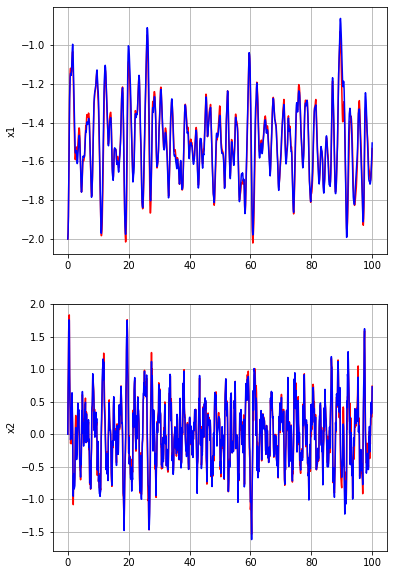

In [24]:
tgrid = [delta_t * k for k in range(N_sim + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (2):
    plt.subplot( str(2) + str(1) + str(i + 1) )
    plt.grid()
    x_koop = x_koop_array[i,:]
    x_true = x_traj_true_array[i,:]
    plt.plot(tgrid, x_koop, 'r')
    plt.plot(tgrid, x_true, 'b')
    plt.ylabel('x' + str(i + 1))

Closed-loop simulation

In [25]:
N_sim = 200
x1_start = -2
x2_start = 0
x1_ub = ca.inf
x2_ub = ca.inf

Without any bound

In [26]:
obj = 0

N_pred = 8

zi_var = ca.SX.sym('z', N_lift, N_pred+1)
z0_para = ca.SX.sym('z0', N_lift, 1)
ui_var = ca.SX.sym('u', 1, N_pred)


# Q = 10 * np.eye(N_lift)
Q = np.diag([0]* (N_lift-2) + [50,10] )
R = 1 * np.eye(1)
Qf = np.diag([0]* (N_lift-2) + [50, 10])
# Qf = 10 * np.eye(N_lift)

g = []

for i in range(N_pred):
    obj +=  zi_var[:,i].T @ Q @  zi_var[:,i] + ui_var[:,i].T @ R @ ui_var[:,i]
    if i == 0:
        g += [zi_var[:,i] - z0_para]
    else:
        g += [zi_var[:,i] - (A_lift_np @ zi_var[:,i-1] + B_lift_np @ ui_var[:,i-1])]

obj += zi_var[:, -1].T @ Qf @ zi_var[:, -1]
g += [zi_var[:, -1] - (A_lift_np @ zi_var[:,-2] + B_lift_np @ ui_var[:,-1])] # Terminal state        
# g += [terminal_state - integrator_rk4(ode, xi_var[:,-2], ui_var[:,-1], delta_t)] # Terminal state         
dec_list = [ca.reshape(zi_var,-1,1), ca.reshape(ui_var,-1,1)]
para_list = [z0_para]
nlp_prob = {
    'f': obj,
    'x': ca.vertcat(*dec_list),
    'g': ca.vertcat(*g),
    'p': ca.vertcat(*para_list)
}
    

solver_opt = {}
solver_opt['print_time'] = False
solver_opt['ipopt'] = {
    'max_iter': 1500,
    'print_level': 3,
    'acceptable_constr_viol_tol': 0.1,
    'acceptable_tol': 5e-1,
}
#    'acceptable_obj_change_tol': 5e-4}


solver_real = ca.nlpsol("solver", "ipopt", nlp_prob, solver_opt)  

In [27]:
lbg =  [0] * N_lift * (N_pred + 1)
ubg =  [0] * N_lift * (N_pred + 1)
lbx = [-ca.inf] * N_lift * (N_pred+1) + [-ca.inf] * (N_pred)
ubx = ([ca.inf] * (N_lift-2) + [x1_ub, x2_ub])  * (N_pred+1) + [ca.inf] * (N_pred)
nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg
nl['lbx'] = lbx
nl['ubx'] = ubx

In [28]:
x0 = np.array([[x1_start],[x2_start]])
z0 = lift_func(x0, Xc)
u0 = np.array([[0]])

x_pred_list = []
z_pred_list = []
xk = x0
zk = z0
uk = u0


x_pred_list.append(xk.flatten().tolist())
z_pred_list.append(zk.flatten().tolist())

u_ind = ca.reshape(zi_var,-1,1).shape[0]

In [29]:
# Simulation for 20 seconds
for i in range(N_sim):
#     print(xk.shape)
    p = np.vstack([zk])
#     print(p.shape)
    nl['p'] = p
#     print(zk)
    sol = solver_real(**nl)
    uk = sol['x'].full()[u_ind,0]
    zk = sol['x'].full()[:u_ind]
    z_pred_list += [zk]
    print("zk",zk[50::52],zk[51::52])
    x_next = integrator_rk4(ode,xk,uk,delta_t)
    print(uk,xk)
#     print("zk",zk)
#     print(zk[50::52],zk[51::52])
    x_pred_list.append(x_next.full().flatten().tolist())
    
    xk = x_next.full()
    zk = lift_func(xk, Xc)
#     print(xk.shape)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Total number of variables............................:      476
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      468
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 2

     


Number of Iterations....: 2

                                   (scaled)                 (unscaled)
Objective...............:  2.9778690052780053e+002   2.9778690052780053e+002
Dual infeasibility......:  5.3965720780979609e-012   5.3965720780979609e-012
Constraint violation....:  3.0154796699611237e-012   3.2309710462641306e-012
Complementarity.........:  0.0000000000000000e+000   0.0000000000000000e+000
Overall NLP error.......:  5.3965720780979609e-012   5.3965720780979609e-012


Number of objective function evaluations             = 3
Number of objective gradient evaluations             = 3
Number of equality constraint evaluations            = 3
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 3
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 2
Total CPU secs in IPOPT (w/o function evaluations)   =      0.070
Total CPU secs in NLP function evaluations     


Number of Iterations....: 2

                                   (scaled)                 (unscaled)
Objective...............:  3.1573405483073721e+001   3.1573405483073721e+001
Dual infeasibility......:  1.3728573833304836e-011   1.3728573833304836e-011
Constraint violation....:  3.2571208226034201e-012   3.4328095921409840e-012
Complementarity.........:  0.0000000000000000e+000   0.0000000000000000e+000
Overall NLP error.......:  1.3728573833304836e-011   1.3728573833304836e-011


Number of objective function evaluations             = 3
Number of objective gradient evaluations             = 3
Number of equality constraint evaluations            = 3
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 3
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 2
Total CPU secs in IPOPT (w/o function evaluations)   =      0.067
Total CPU secs in NLP function evaluations     


Number of Iterations....: 2

                                   (scaled)                 (unscaled)
Objective...............:  1.2204390961961497e+001   1.2204390961961497e+001
Dual infeasibility......:  3.0622615554420918e-011   3.0622615554420918e-011
Constraint violation....:  1.1549611387809237e-011   1.2172596264292679e-011
Complementarity.........:  0.0000000000000000e+000   0.0000000000000000e+000
Overall NLP error.......:  3.0622615554420918e-011   3.0622615554420918e-011


Number of objective function evaluations             = 3
Number of objective gradient evaluations             = 3
Number of equality constraint evaluations            = 3
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 3
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 2
Total CPU secs in IPOPT (w/o function evaluations)   =      0.075
Total CPU secs in NLP function evaluations     

Total number of variables............................:      476
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      468
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 2

                                   (scaled)                 (unscaled)
Objective...............:  1.5647523101566044e+001   1.5647523101566044e+001
Dual infeasibility......:  2.7974067506875144e-011   2.7974067506875144e-011
Constraint violation....:  1.5057547368194634e-011   1.5869749958596913e-011
Complementarity.........:  0.0000000000000000e+000   0.0000000000000000e+000
Overall NLP er

Total number of variables............................:      476
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      468
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 2

                                   (scaled)                 (unscaled)
Objective...............:  1.6951580607642306e+001   1.6951580607642306e+001
Dual infeasibility......:  2.4055424319158192e-011   2.4055424319158192e-011
Constraint violation....:  1.7149410038346735e-011   1.7994494783124537e-011
Complementarity.........:  0.0000000000000000e+000   0.0000000000000000e+000
Overall NLP er


Number of Iterations....: 2

                                   (scaled)                 (unscaled)
Objective...............:  1.6909882518543249e+001   1.6909882518543249e+001
Dual infeasibility......:  2.4943602738858317e-011   2.4943602738858317e-011
Constraint violation....:  1.8493423403532708e-011   1.9357404568154379e-011
Complementarity.........:  0.0000000000000000e+000   0.0000000000000000e+000
Overall NLP error.......:  2.4943602738858317e-011   2.4943602738858317e-011


Number of objective function evaluations             = 3
Number of objective gradient evaluations             = 3
Number of equality constraint evaluations            = 3
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 3
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 2
Total CPU secs in IPOPT (w/o function evaluations)   =      0.079
Total CPU secs in NLP function evaluations     


                                   (scaled)                 (unscaled)
Objective...............:  1.6543563924122555e+001   1.6543563924122555e+001
Dual infeasibility......:  2.7018387527277810e-011   2.7018387527277810e-011
Constraint violation....:  1.9067903577139038e-011   1.9936052808589011e-011
Complementarity.........:  0.0000000000000000e+000   0.0000000000000000e+000
Overall NLP error.......:  2.7018387527277810e-011   2.7018387527277810e-011


Number of objective function evaluations             = 3
Number of objective gradient evaluations             = 3
Number of equality constraint evaluations            = 3
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 3
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 2
Total CPU secs in IPOPT (w/o function evaluations)   =      0.085
Total CPU secs in NLP function evaluations           =      0.002

EXIT: Opt


                                   (scaled)                 (unscaled)
Objective...............:  1.6258000637208877e+001   1.6258000637208877e+001
Dual infeasibility......:  3.0887292723491555e-011   3.0887292723491555e-011
Constraint violation....:  1.9159981677802418e-011   2.0097035147159659e-011
Complementarity.........:  0.0000000000000000e+000   0.0000000000000000e+000
Overall NLP error.......:  3.0887292723491555e-011   3.0887292723491555e-011


Number of objective function evaluations             = 3
Number of objective gradient evaluations             = 3
Number of equality constraint evaluations            = 3
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 3
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 2
Total CPU secs in IPOPT (w/o function evaluations)   =      0.086
Total CPU secs in NLP function evaluations           =      0.001

EXIT: Opt

Total number of variables............................:      476
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      468
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 2

                                   (scaled)                 (unscaled)
Objective...............:  1.6104327238750738e+001   1.6104327238750738e+001
Dual infeasibility......:  3.2995828291859652e-011   3.2995828291859652e-011
Constraint violation....:  1.9293031809056843e-011   2.0109025555825610e-011
Complementarity.........:  0.0000000000000000e+000   0.0000000000000000e+000
Overall NLP er


                                   (scaled)                 (unscaled)
Objective...............:  1.6023158341706221e+001   1.6023158341706221e+001
Dual infeasibility......:  3.0176749987731455e-011   3.0176749987731455e-011
Constraint violation....:  1.9307960447862623e-011   2.0113022358714261e-011
Complementarity.........:  0.0000000000000000e+000   0.0000000000000000e+000
Overall NLP error.......:  3.0176749987731455e-011   3.0176749987731455e-011


Number of objective function evaluations             = 3
Number of objective gradient evaluations             = 3
Number of equality constraint evaluations            = 3
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 3
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 2
Total CPU secs in IPOPT (w/o function evaluations)   =      0.080
Total CPU secs in NLP function evaluations           =      0.001

EXIT: Opt


Number of Iterations....: 2

                                   (scaled)                 (unscaled)
Objective...............:  1.5958480010611368e+001   1.5958480010611368e+001
Dual infeasibility......:  4.3907988356295391e-011   4.3907988356295391e-011
Constraint violation....:  1.9429677889804630e-011   2.0130341837898413e-011
Complementarity.........:  0.0000000000000000e+000   0.0000000000000000e+000
Overall NLP error.......:  4.3907988356295391e-011   4.3907988356295391e-011


Number of objective function evaluations             = 3
Number of objective gradient evaluations             = 3
Number of equality constraint evaluations            = 3
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 3
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 2
Total CPU secs in IPOPT (w/o function evaluations)   =      0.084
Total CPU secs in NLP function evaluations     

Total number of variables............................:      476
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      468
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 2

                                   (scaled)                 (unscaled)
Objective...............:  1.5921132092710380e+001   1.5921132092710380e+001
Dual infeasibility......:  3.2805758110043826e-011   3.2805758110043826e-011
Constraint violation....:  1.9281372215245030e-011   2.0087265184542957e-011
Complementarity.........:  0.0000000000000000e+000   0.0000000000000000e+000
Overall NLP er

Total number of variables............................:      476
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      468
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 2

                                   (scaled)                 (unscaled)
Objective...............:  1.5900700649242360e+001   1.5900700649242360e+001
Dual infeasibility......:  2.8961721909581684e-011   2.8961721909581684e-011
Constraint violation....:  1.9309268065860207e-011   2.0111912135689636e-011
Complementarity.........:  0.0000000000000000e+000   0.0000000000000000e+000
Overall NLP er


Number of Iterations....: 2

                                   (scaled)                 (unscaled)
Objective...............:  1.5891806133464218e+001   1.5891806133464218e+001
Dual infeasibility......:  4.6123105335027503e-011   4.6123105335027503e-011
Constraint violation....:  1.9333785903314956e-011   2.0154766744440167e-011
Complementarity.........:  0.0000000000000000e+000   0.0000000000000000e+000
Overall NLP error.......:  4.6123105335027503e-011   4.6123105335027503e-011


Number of objective function evaluations             = 3
Number of objective gradient evaluations             = 3
Number of equality constraint evaluations            = 3
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 3
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 2
Total CPU secs in IPOPT (w/o function evaluations)   =      0.083
Total CPU secs in NLP function evaluations     

Total number of variables............................:      476
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      468
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 2

                                   (scaled)                 (unscaled)
Objective...............:  1.5885950100096908e+001   1.5885950100096908e+001
Dual infeasibility......:  3.8276937175396597e-011   3.8276937175396597e-011
Constraint violation....:  1.9355579536608063e-011   2.0130563882503338e-011
Complementarity.........:  0.0000000000000000e+000   0.0000000000000000e+000
Overall NLP er

Total number of variables............................:      476
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      468
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 2

                                   (scaled)                 (unscaled)
Objective...............:  1.5883362541511062e+001   1.5883362541511062e+001
Dual infeasibility......:  2.9643842935911380e-011   2.9643842935911380e-011
Constraint violation....:  1.9264046276777011e-011   2.0060619831951954e-011
Complementarity.........:  0.0000000000000000e+000   0.0000000000000000e+000
Overall NLP er

 [-0.15683129]] [[ 9.49580127e-06]
 [ 1.28312036e-03]
 [-1.09755781e-02]
 [-5.17960748e-02]
 [-1.29338081e-01]
 [-2.43363162e-01]
 [-3.94861522e-01]
 [-5.81962632e-01]
 [-7.95326981e-01]]
0.00013597232543351872 [[2.20307868e-02]
 [9.49580031e-06]]
Total number of variables............................:      476
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      468
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 2

                                   (scaled)                 (unscaled)
Objective...............:  1.5882410572792738e+001   1.5882410572792738e+0

Total number of variables............................:      476
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      468
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 2

                                   (scaled)                 (unscaled)
Objective...............:  1.5882118149613527e+001   1.5882118149613527e+001
Dual infeasibility......:  2.5842439299594844e-011   2.5842439299594844e-011
Constraint violation....:  1.9310684652024261e-011   2.0176749160327745e-011
Complementarity.........:  0.0000000000000000e+000   0.0000000000000000e+000
Overall NLP er


Number of Iterations....: 2

                                   (scaled)                 (unscaled)
Objective...............:  1.5882082297703318e+001   1.5882082297703318e+001
Dual infeasibility......:  3.2294167340296553e-011   3.2294167340296553e-011
Constraint violation....:  1.9229612336173898e-011   2.0248691612323455e-011
Complementarity.........:  0.0000000000000000e+000   0.0000000000000000e+000
Overall NLP error.......:  3.2294167340296553e-011   3.2294167340296553e-011


Number of objective function evaluations             = 3
Number of objective gradient evaluations             = 3
Number of equality constraint evaluations            = 3
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 3
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 2
Total CPU secs in IPOPT (w/o function evaluations)   =      0.108
Total CPU secs in NLP function evaluations     

Total number of variables............................:      476
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      468
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 2

                                   (scaled)                 (unscaled)
Objective...............:  1.5882185538530248e+001   1.5882185538530248e+001
Dual infeasibility......:  7.1839423299024929e-011   7.1839423299024929e-011
Constraint violation....:  1.9311883301855383e-011   2.0212276297115750e-011
Complementarity.........:  0.0000000000000000e+000   0.0000000000000000e+000
Overall NLP er

Total number of variables............................:      476
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      468
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 2

                                   (scaled)                 (unscaled)
Objective...............:  1.5882250023929467e+001   1.5882250023929467e+001
Dual infeasibility......:  3.0127011996228248e-011   3.0127011996228248e-011
Constraint violation....:  1.9304146562036329e-011   2.0074164552852380e-011
Complementarity.........:  0.0000000000000000e+000   0.0000000000000000e+000
Overall NLP er


                                   (scaled)                 (unscaled)
Objective...............:  1.5882324292212584e+001   1.5882324292212584e+001
Dual infeasibility......:  2.6336266500948113e-011   2.6336266500948113e-011
Constraint violation....:  1.9296518790383742e-011   2.0097701280974434e-011
Complementarity.........:  0.0000000000000000e+000   0.0000000000000000e+000
Overall NLP error.......:  2.6336266500948113e-011   2.6336266500948113e-011


Number of objective function evaluations             = 3
Number of objective gradient evaluations             = 3
Number of equality constraint evaluations            = 3
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 3
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 2
Total CPU secs in IPOPT (w/o function evaluations)   =      0.079
Total CPU secs in NLP function evaluations           =      0.001

EXIT: Opt


                                   (scaled)                 (unscaled)
Objective...............:  1.5882378061844715e+001   1.5882378061844715e+001
Dual infeasibility......:  2.7192470497539034e-011   2.7192470497539034e-011
Constraint violation....:  1.9280827374412702e-011   2.0216051055399475e-011
Complementarity.........:  0.0000000000000000e+000   0.0000000000000000e+000
Overall NLP error.......:  2.7192470497539034e-011   2.7192470497539034e-011


Number of objective function evaluations             = 3
Number of objective gradient evaluations             = 3
Number of equality constraint evaluations            = 3
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 3
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 2
Total CPU secs in IPOPT (w/o function evaluations)   =      0.082
Total CPU secs in NLP function evaluations           =      0.003

EXIT: Opt


Number of Iterations....: 2

                                   (scaled)                 (unscaled)
Objective...............:  1.5882496697068825e+001   1.5882496697068825e+001
Dual infeasibility......:  3.5839775591739453e-011   3.5839775591739453e-011
Constraint violation....:  1.9150937319985780e-011   2.0146329049453016e-011
Complementarity.........:  0.0000000000000000e+000   0.0000000000000000e+000
Overall NLP error.......:  3.5839775591739453e-011   3.5839775591739453e-011


Number of objective function evaluations             = 3
Number of objective gradient evaluations             = 3
Number of equality constraint evaluations            = 3
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 3
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 2
Total CPU secs in IPOPT (w/o function evaluations)   =      0.078
Total CPU secs in NLP function evaluations     


Number of Iterations....: 2

                                   (scaled)                 (unscaled)
Objective...............:  1.5882452119937909e+001   1.5882452119937909e+001
Dual infeasibility......:  4.8469672719875234e-011   4.8469672719875234e-011
Constraint violation....:  1.9218388615027949e-011   2.0195400907141448e-011
Complementarity.........:  0.0000000000000000e+000   0.0000000000000000e+000
Overall NLP error.......:  4.8469672719875234e-011   4.8469672719875234e-011


Number of objective function evaluations             = 3
Number of objective gradient evaluations             = 3
Number of equality constraint evaluations            = 3
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 3
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 2
Total CPU secs in IPOPT (w/o function evaluations)   =      0.080
Total CPU secs in NLP function evaluations     

Total number of variables............................:      476
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      468
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 2

                                   (scaled)                 (unscaled)
Objective...............:  1.5882464001383813e+001   1.5882464001383813e+001
Dual infeasibility......:  2.9576341376014170e-011   2.9576341376014170e-011
Constraint violation....:  1.9301422357874691e-011   2.0185630944524746e-011
Complementarity.........:  0.0000000000000000e+000   0.0000000000000000e+000
Overall NLP er

 [-0.15680309]] [[ 6.78801141e-08]
 [ 1.27244179e-03]
 [-1.09887830e-02]
 [-5.18114516e-02]
 [-1.29354127e-01]
 [-2.43378525e-01]
 [-3.94875499e-01]
 [-5.81975527e-01]
 [-7.95340106e-01]]
2.1089144236451546e-05 [[2.20698707e-02]
 [6.78791586e-08]]
Total number of variables............................:      476
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      468
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 2

                                   (scaled)                 (unscaled)
Objective...............:  1.5882453900402398e+001   1.5882453900402398e+0


Number of Iterations....: 2

                                   (scaled)                 (unscaled)
Objective...............:  1.5882504343767636e+001   1.5882504343767636e+001
Dual infeasibility......:  3.4980018881469732e-011   3.4980018881469732e-011
Constraint violation....:  1.9322998054834869e-011   2.0039969683693926e-011
Complementarity.........:  0.0000000000000000e+000   0.0000000000000000e+000
Overall NLP error.......:  3.4980018881469732e-011   3.4980018881469732e-011


Number of objective function evaluations             = 3
Number of objective gradient evaluations             = 3
Number of equality constraint evaluations            = 3
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 3
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 2
Total CPU secs in IPOPT (w/o function evaluations)   =      0.080
Total CPU secs in NLP function evaluations     

 [-0.15680321]] [[-1.00274571e-07]
 [ 1.27236590e-03]
 [-1.09885560e-02]
 [-5.18113767e-02]
 [-1.29354359e-01]
 [-2.43378948e-01]
 [-3.94875951e-01]
 [-5.81975863e-01]
 [-7.95340230e-01]]
2.114789407461711e-05 [[ 2.20698880e-02]
 [-1.00275526e-07]]
Total number of variables............................:      476
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      468
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 2

                                   (scaled)                 (unscaled)
Objective...............:  1.5882474378601628e+001   1.5882474378601628e+


                                   (scaled)                 (unscaled)
Objective...............:  1.5882504123947314e+001   1.5882504123947314e+001
Dual infeasibility......:  2.6993518531526206e-011   2.6993518531526206e-011
Constraint violation....:  1.9320055914340298e-011   2.0159873770353443e-011
Complementarity.........:  0.0000000000000000e+000   0.0000000000000000e+000
Overall NLP error.......:  2.6993518531526206e-011   2.6993518531526206e-011


Number of objective function evaluations             = 3
Number of objective gradient evaluations             = 3
Number of equality constraint evaluations            = 3
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 3
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 2
Total CPU secs in IPOPT (w/o function evaluations)   =      0.082
Total CPU secs in NLP function evaluations           =      0.002

EXIT: Opt

2.28807142649825e-05 [[ 2.20698005e-02]
 [-1.29251309e-09]]
Total number of variables............................:      476
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      468
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 2

                                   (scaled)                 (unscaled)
Objective...............:  1.5882430184907495e+001   1.5882430184907495e+001
Dual infeasibility......:  3.8291148030111799e-011   3.8291148030111799e-011
Constraint violation....:  1.9344355815462114e-011   2.0191404104252797e-011
Complementarity.........:  0.00


Number of Iterations....: 2

                                   (scaled)                 (unscaled)
Objective...............:  1.5882476588331169e+001   1.5882476588331169e+001
Dual infeasibility......:  3.6617819887396763e-011   3.6617819887396763e-011
Constraint violation....:  1.9266225640106321e-011   2.0216495144609326e-011
Complementarity.........:  0.0000000000000000e+000   0.0000000000000000e+000
Overall NLP error.......:  3.6617819887396763e-011   3.6617819887396763e-011


Number of objective function evaluations             = 3
Number of objective gradient evaluations             = 3
Number of equality constraint evaluations            = 3
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 3
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 2
Total CPU secs in IPOPT (w/o function evaluations)   =      0.084
Total CPU secs in NLP function evaluations     

Total number of variables............................:      476
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      468
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 2

                                   (scaled)                 (unscaled)
Objective...............:  1.5882463320064723e+001   1.5882463320064723e+001
Dual infeasibility......:  3.4837910334317712e-011   3.4837910334317712e-011
Constraint violation....:  1.9333676935148490e-011   2.0151658119971216e-011
Complementarity.........:  0.0000000000000000e+000   0.0000000000000000e+000
Overall NLP er


                                   (scaled)                 (unscaled)
Objective...............:  1.5882444845909273e+001   1.5882444845909273e+001
Dual infeasibility......:  3.7559289012278896e-011   3.7559289012278896e-011
Constraint violation....:  1.9322998054834869e-011   2.0071944106803130e-011
Complementarity.........:  0.0000000000000000e+000   0.0000000000000000e+000
Overall NLP error.......:  3.7559289012278896e-011   3.7559289012278896e-011


Number of objective function evaluations             = 3
Number of objective gradient evaluations             = 3
Number of equality constraint evaluations            = 3
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 3
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 2
Total CPU secs in IPOPT (w/o function evaluations)   =      0.083
Total CPU secs in NLP function evaluations           =      0.001

EXIT: Opt

Total number of variables............................:      476
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      468
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 2

                                   (scaled)                 (unscaled)
Objective...............:  1.5882465249453871e+001   1.5882465249453871e+001
Dual infeasibility......:  4.1517012050462654e-011   4.1517012050462654e-011
Constraint violation....:  1.9232445508502002e-011   2.0221602170522601e-011
Complementarity.........:  0.0000000000000000e+000   0.0000000000000000e+000
Overall NLP er


Number of Iterations....: 2

                                   (scaled)                 (unscaled)
Objective...............:  1.5882474606904648e+001   1.5882474606904648e+001
Dual infeasibility......:  3.2301272767654154e-011   3.2301272767654154e-011
Constraint violation....:  1.9260202359740109e-011   2.0299095737641437e-011
Complementarity.........:  0.0000000000000000e+000   0.0000000000000000e+000
Overall NLP error.......:  3.2301272767654154e-011   3.2301272767654154e-011


Number of objective function evaluations             = 3
Number of objective gradient evaluations             = 3
Number of equality constraint evaluations            = 3
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 3
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 2
Total CPU secs in IPOPT (w/o function evaluations)   =      0.082
Total CPU secs in NLP function evaluations     

Total number of variables............................:      476
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      468
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 2

                                   (scaled)                 (unscaled)
Objective...............:  1.5882501325201732e+001   1.5882501325201732e+001
Dual infeasibility......:  3.7971403799019754e-011   3.7971403799019754e-011
Constraint violation....:  1.9251775138983047e-011   2.0290213953444436e-011
Complementarity.........:  0.0000000000000000e+000   0.0000000000000000e+000
Overall NLP er

 [-0.15680307]] [[ 4.42950656e-08]
 [ 1.27245021e-03]
 [-1.09885999e-02]
 [-5.18111059e-02]
 [-1.29353798e-01]
 [-2.43378293e-01]
 [-3.94875375e-01]
 [-5.81975483e-01]
 [-7.95340097e-01]]
2.0956584426906914e-05 [[2.20697586e-02]
 [4.42941100e-08]]
Total number of variables............................:      476
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      468
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 2

                                   (scaled)                 (unscaled)
Objective...............:  1.5882464841259026e+001   1.5882464841259026e+0

Total number of variables............................:      476
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      468
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 2

                                   (scaled)                 (unscaled)
Objective...............:  1.5882461896631664e+001   1.5882461896631664e+001
Dual infeasibility......:  4.2096104380107136e-011   4.2096104380107136e-011
Constraint violation....:  1.9292378000058050e-011   2.0121460053701412e-011
Complementarity.........:  0.0000000000000000e+000   0.0000000000000000e+000
Overall NLP er

In [30]:
obj = 0

N_pred = 5

xi_var = ca.SX.sym('x', 2, N_pred+1)
x0_para = ca.SX.sym('x0', 2, 1)
ui_var = ca.SX.sym('u', 1, N_pred)


Q = 10 * np.eye(2)
R = 1 * np.eye(1)
Qf = 10 * np.eye(2)

g = []


for i in range(N_pred):
    obj +=  xi_var[:,i].T @ Q @  xi_var[:,i] + ui_var[:,i].T @ R @ ui_var[:,i]
    if i == 0:
        g += [xi_var[:,i] - x0_para]
    else:
        g += [xi_var[:,i] - integrator_rk4(ode, xi_var[:,i-1], ui_var[:,i-1], delta_t)]

obj += xi_var[:, -1].T @ Qf @ xi_var[:, -1]
g += [xi_var[:, -1] - integrator_rk4(ode, xi_var[:,-2], ui_var[:,-1], delta_t)] # Terminal state        
# g += [terminal_state - integrator_rk4(ode, xi_var[:,-2], ui_var[:,-1], delta_t)] # Terminal state         
dec_list = [ca.reshape(xi_var,-1,1), ca.reshape(ui_var,-1,1)]
para_list = [x0_para]
nlp_prob = {
    'f': obj,
    'x': ca.vertcat(*dec_list),
    'g': ca.vertcat(*g),
    'p': ca.vertcat(*para_list)
}
    

solver_opt = {}
solver_opt['print_time'] = False
solver_opt['ipopt'] = {
    'max_iter': 500,
    'print_level': 1,
    'acceptable_tol': 1e-6,
    'acceptable_obj_change_tol': 1e-6}


solver_real = ca.nlpsol("solver", "ipopt", nlp_prob, solver_opt)  



lbg =  [0] * 2 * (N_pred + 1)
ubg =  [0] * 2 * (N_pred + 1)
lbx = [-ca.inf] * 2 * (N_pred+1) + [-ca.inf] * (N_pred)
ubx = [x1_ub, x2_ub] * (N_pred+1) + [ca.inf] * (N_pred)
nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg
nl['lbx'] = lbx
nl['ubx'] = ubx

In [31]:
x0 = np.array([[x1_start],[x2_start]])
u0 = np.array([[0]])

x_real_list = []
x_real_pred_list = []
xk = x0
uk = u0


x_real_list.append(xk.flatten().tolist())

u_ind = ca.reshape(xi_var,-1,1).shape[0]

In [32]:
# Simulation for 20 seconds
for i in range(N_sim):
    p = np.vstack([xk])
    nl['p'] = p
    
    sol = solver_real(**nl)
    uk = sol['x'].full()[u_ind,0]
#     print(uk)
    x_real_pred_list += [sol['x'].full()[:u_ind]]
    
    x_next = integrator_rk4(ode,xk,uk,delta_t)
    print(uk,xk)
    x_real_list.append(x_next.full().flatten().tolist())

    x_lin = xk
    xk = x_next

-0.6602868969909749 [[-2]
 [ 0]]
-1.2072976625310157 [-1.96388, 0.698234]
-1.5538050228379092 [-1.86741, 1.20119]
-1.7165318993058054 [-1.73068, 1.50394]
-1.7338244346753362 [-1.57258, 1.63341]
-1.650690365807115 [-1.40838, 1.63251]
-1.5079012317245255 [-1.24887, 1.54571]
-1.3369763122564877 [-1.10073, 1.41041]
-1.1595555379623825 [-0.96734, 1.25409]
-0.9889836414714782 [-0.849848, 1.09487]
-0.8325180012511398 [-0.747954, 0.943535]
-0.6933475215436399 [-0.660556, 0.805705]
-0.5721460454379996 [-0.586169, 0.683648]
-0.4681545598718981 [-0.52319, 0.577612]
-0.3798852768302489 [-0.470054, 0.486728]
-0.30555489902244654 [-0.425312, 0.409578]
-0.24333683743871257 [-0.387672, 0.344544]
-0.19149808091590628 [-0.356002, 0.290004]
-0.14846539250206822 [-0.329329, 0.244436]
-0.11284982734233928 [-0.306826, 0.20647]
-0.08344777704704293 [-0.287792, 0.174902]
-0.059229666514586006 [-0.271643, 0.14869]
-0.03932292705708877 [-0.257886, 0.126946]
-0.02299306965049505 [-0.246113, 0.108919]
-0.00962497

C:\Users\ZHENGA~1\AppData\Local\Temp/ipykernel_3676/500681851.py:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(2) + str(1) + str(i + 1) )
C:\Users\ZHENGA~1\AppData\Local\Temp/ipykernel_3676/500681851.py:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(2) + str(1) + str(i + 1) )


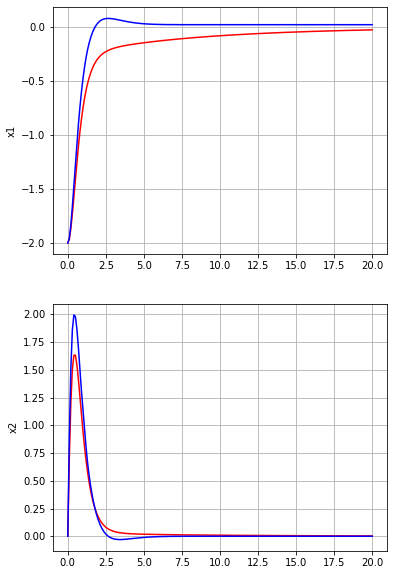

In [33]:
x_plot_real = np.array(x_real_list)
x_plot_pred = np.array(x_pred_list)
tgrid = [delta_t * k for k in range(N_sim + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (2):
    plt.subplot( str(2) + str(1) + str(i + 1) )
    plt.grid()
    
#     if i == 1:
#         constr_plot_temp = [0.65] * (N_sim + 1)
#         plt.plot(tgrid, constr_plot_temp, color="k")
    
    x_opt_real = x_plot_real[:,i]
    x_opt_pred = x_plot_pred[:,i]
    plt.plot(tgrid, x_opt_real, 'r')
    plt.plot(tgrid, x_opt_pred, 'b')
    plt.ylabel('x' + str(i + 1))

Upper bounded

In [34]:
N_sim = 200
x1_start = -2
x2_start = 0
x1_ub = ca.inf
x2_ub = 0.5

In [35]:
obj = 0

N_pred = 8

zi_var = ca.SX.sym('z', N_lift, N_pred+1)
z0_para = ca.SX.sym('z0', N_lift, 1)
ui_var = ca.SX.sym('u', 1, N_pred)


# Q = 10 * np.eye(N_lift)
Q = np.diag([0]* (N_lift-2) + [20, 10] )
R = 1 * np.eye(1)
Qf = np.diag([0]* (N_lift-2) + [20, 10])
# Qf = 10 * np.eye(N_lift)

g = []

for i in range(N_pred):
    obj +=  zi_var[:,i].T @ Q @  zi_var[:,i] + ui_var[:,i].T @ R @ ui_var[:,i]
    if i == 0:
        g += [zi_var[:,i] - z0_para]
    else:
        g += [zi_var[:,i] - (A_lift_np @ zi_var[:,i-1] + B_lift_np @ ui_var[:,i-1])]

obj += zi_var[:, -1].T @ Qf @ zi_var[:, -1]
g += [zi_var[:, -1] - (A_lift_np @ zi_var[:,-2] + B_lift_np @ ui_var[:,-1])] # Terminal state        
# g += [terminal_state - integrator_rk4(ode, xi_var[:,-2], ui_var[:,-1], delta_t)] # Terminal state         
dec_list = [ca.reshape(zi_var,-1,1), ca.reshape(ui_var,-1,1)]
para_list = [z0_para]
nlp_prob = {
    'f': obj,
    'x': ca.vertcat(*dec_list),
    'g': ca.vertcat(*g),
    'p': ca.vertcat(*para_list)
}
    

solver_opt = {}
solver_opt['print_time'] = False
solver_opt['ipopt'] = {
    'max_iter': 1500,
    'print_level': 3,
    'acceptable_constr_viol_tol': 0.1,
    'acceptable_tol': 5e-1,
}
#    'acceptable_obj_change_tol': 5e-4}


solver_real = ca.nlpsol("solver", "ipopt", nlp_prob, solver_opt)  

In [36]:
lbg =  [0] * N_lift * (N_pred + 1)
ubg =  [0] * N_lift * (N_pred + 1)
lbx = [-ca.inf] * N_lift * (N_pred+1) + [-ca.inf] * (N_pred)
ubx = ([ca.inf] * (N_lift-2) + [x1_ub, x2_ub])  * (N_pred+1) + [ca.inf] * (N_pred)
nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg
nl['lbx'] = lbx
nl['ubx'] = ubx

In [37]:
x0 = np.array([[x1_start],[x2_start]])
z0 = lift_func(x0, Xc)
u0 = np.array([[0]])

x_pred_list = []
z_pred_list = []
xk = x0
zk = z0
uk = u0


x_pred_list.append(xk.flatten().tolist())
z_pred_list.append(zk.flatten().tolist())

u_ind = ca.reshape(zi_var,-1,1).shape[0]

In [38]:
z0

array([[ 9.75994587e+00],
       [ 3.69921613e+00],
       [ 3.32607384e+01],
       [ 1.01967907e+00],
       [ 3.18970442e-01],
       [ 1.34282837e+01],
       [ 1.33620062e+01],
       [ 4.98579219e-02],
       [ 3.78378367e+00],
       [ 7.16020823e+00],
       [ 2.22025566e+01],
       [ 1.52180014e+01],
       [ 1.48714752e+01],
       [ 8.75735953e-02],
       [ 3.57489967e+00],
       [ 2.40394268e+01],
       [ 2.23319836e+01],
       [ 9.66458225e+00],
       [ 2.20963192e+01],
       [ 1.21328734e-01],
       [ 3.09253311e+00],
       [ 3.13066334e-01],
       [ 5.88389397e+00],
       [ 9.29425240e+00],
       [ 2.55254364e+01],
       [ 1.27658777e+01],
       [ 1.02020054e+01],
       [ 2.21016264e+00],
       [ 2.62494302e+00],
       [ 1.64594650e+01],
       [ 1.10180247e+00],
       [ 6.18834381e+01],
       [ 2.34736404e+01],
       [ 1.62978458e+01],
       [ 1.30555840e+01],
       [ 2.44028735e+00],
       [ 5.52679157e+00],
       [ 3.35956097e+00],
       [ 1.2

In [39]:
np.vstack(z0).shape

(52, 1)

In [40]:
# Simulation for 20 seconds
for i in range(N_sim):
#     print(xk.shape)
    p = np.vstack([zk])
#     print(p.shape)
    nl['p'] = p
#     print(zk)
    sol = solver_real(**nl)
    uk = sol['x'].full()[u_ind,0]
    zk = sol['x'].full()[:u_ind]
    z_pred_list += [zk]
    print("zk",zk[50::52],zk[51::52])
    x_next = integrator_rk4(ode,xk,uk,delta_t)
    print(uk,xk)
#     print("zk",zk)
#     print(zk[50::52],zk[51::52])
    x_pred_list.append(x_next.full().flatten().tolist())
    
    xk = x_next.full()
    zk = lift_func(xk, Xc)
#     print(xk.shape)

Total number of variables............................:      476
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        9
Total number of equality constraints.................:      468
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:  1.3958764310307718e+003   1.3958764310307718e+003
Dual infeasibility......:  6.4187588577624410e-010   6.4187588577624410e-010
Constraint violation....:  2.8534201621967190e-012   2.9103386367523854e-012
Complementarity.........:  2.5085527889724587e-009   2.5085527889724587e-009
Overall NLP e


Number of Iterations....: 16

                                   (scaled)                 (unscaled)
Objective...............:  9.2542449527934127e+002   9.2542449527934127e+002
Dual infeasibility......:  2.9802322387695312e-008   2.9802322387695312e-008
Constraint violation....:  2.8073503112661990e-002   2.8073503112661990e-002
Complementarity.........:  1.5042412372841797e-004   1.5042412372841797e-004
Overall NLP error.......:  2.8073503112661990e-002   2.8073503112661990e-002


Number of objective function evaluations             = 40
Number of objective gradient evaluations             = 18
Number of equality constraint evaluations            = 40
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 18
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 17
Total CPU secs in IPOPT (w/o function evaluations)   =      0.194
Total CPU secs in NLP function evaluation


Number of Iterations....: 15

                                   (scaled)                 (unscaled)
Objective...............:  4.6845869940105155e+002   4.6845869940105155e+002
Dual infeasibility......:  1.4901161193847656e-008   1.4901161193847656e-008
Constraint violation....:  9.4296882526430092e-003   9.4296882526430092e-003
Complementarity.........:  1.5042412372558067e-004   1.5042412372558067e-004
Overall NLP error.......:  9.4296882526430092e-003   9.4296882526430092e-003


Number of objective function evaluations             = 38
Number of objective gradient evaluations             = 17
Number of equality constraint evaluations            = 38
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 17
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 16
Total CPU secs in IPOPT (w/o function evaluations)   =      0.191
Total CPU secs in NLP function evaluation


Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:  2.5851431628654899e+002   2.5851431628654899e+002
Dual infeasibility......:  3.6692426874651574e-011   3.6692426874651574e-011
Constraint violation....:  1.0967439748279130e-012   1.1564083024495631e-012
Complementarity.........:  4.8103422230672495e-009   4.8103422230672495e-009
Overall NLP error.......:  4.8103422230672495e-009   4.8103422230672495e-009


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 11
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 11
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 10
Total CPU secs in IPOPT (w/o function evaluations)   =      0.151
Total CPU secs in NLP function evaluation

Total number of variables............................:      476
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        9
Total number of equality constraints.................:      468
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:  1.4070961533420947e+002   1.4070961533420947e+002
Dual infeasibility......:  1.4566126083082054e-011   1.4566126083082054e-011
Constraint violation....:  2.8145819008784656e-012   2.8145819008784656e-012
Complementarity.........:  2.5369200070756661e-009   2.5369200070756661e-009
Overall NLP er

Total number of variables............................:      476
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        9
Total number of equality constraints.................:      468
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  8.0268564118897174e+001   8.0268564118897174e+001
Dual infeasibility......:  1.9006130003162980e-011   1.9006130003162980e-011
Constraint violation....:  6.0663976807378873e-013   6.1750604629651207e-013
Complementarity.........:  2.5181303796344704e-009   2.5181303796344704e-009
Overall NLP er


Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  5.0287084554525840e+001   5.0287084554525840e+001
Dual infeasibility......:  2.8677504815277644e-011   2.8677504815277644e-011
Constraint violation....:  9.2131487956180013e-013   9.3969276804273250e-013
Complementarity.........:  2.5063271219726239e-009   2.5063271219726239e-009
Overall NLP error.......:  2.5063271219726239e-009   2.5063271219726239e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 6
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 5
Total CPU secs in IPOPT (w/o function evaluations)   =      0.116
Total CPU secs in NLP function evaluations     


Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  2.9671769484885488e+001   2.9671769484885488e+001
Dual infeasibility......:  2.9405811119431746e-011   2.9405811119431746e-011
Constraint violation....:  5.0896969757573500e-013   5.4534154969587689e-013
Complementarity.........:  2.5060401138286597e-009   2.5060401138286597e-009
Overall NLP error.......:  2.5060401138286597e-009   2.5060401138286597e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 6
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 5
Total CPU secs in IPOPT (w/o function evaluations)   =      0.118
Total CPU secs in NLP function evaluations     


Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  2.1852355656541594e+001   2.1852355656541594e+001
Dual infeasibility......:  3.4873437471105717e-011   3.4873437471105717e-011
Constraint violation....:  4.1647902777111604e-013   5.3645976549887564e-013
Complementarity.........:  2.5059949607189425e-009   2.5059949607189425e-009
Overall NLP error.......:  2.5059949607189425e-009   2.5059949607189425e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o function evaluations)   =      0.122
Total CPU secs in NLP function evaluations     


Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  1.8498705708097699e+001   1.8498705708097699e+001
Dual infeasibility......:  2.3938184767757775e-011   2.3938184767757775e-011
Constraint violation....:  4.4630965589931293e-013   4.6895820560166612e-013
Complementarity.........:  2.5059799799764084e-009   2.5059799799764084e-009
Overall NLP error.......:  2.5059799799764084e-009   2.5059799799764084e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o function evaluations)   =      0.126
Total CPU secs in NLP function evaluations     


Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  1.6898142499866367e+001   1.6898142499866367e+001
Dual infeasibility......:  3.0969005138103967e-011   3.0969005138103967e-011
Constraint violation....:  4.5261644413386962e-013   5.4356519285647664e-013
Complementarity.........:  2.5059730960580430e-009   2.5059730960580430e-009
Overall NLP error.......:  2.5059730960580430e-009   2.5059730960580430e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o function evaluations)   =      0.125
Total CPU secs in NLP function evaluations     


Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  1.6075481719693343e+001   1.6075481719693343e+001
Dual infeasibility......:  3.5988989566249074e-011   3.5988989566249074e-011
Constraint violation....:  4.2199530628464075e-013   5.4356519285647664e-013
Complementarity.........:  2.5059693322391240e-009   2.5059693322391240e-009
Overall NLP error.......:  2.5059693322391240e-009   2.5059693322391240e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o function evaluations)   =      0.128
Total CPU secs in NLP function evaluations     


Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  1.5631423327316142e+001   1.5631423327316142e+001
Dual infeasibility......:  3.0290436825453071e-011   3.0290436825453071e-011
Constraint violation....:  4.8939410426628705e-013   5.6132876125047915e-013
Complementarity.........:  2.5059670148861669e-009   2.5059670148861669e-009
Overall NLP error.......:  2.5059670148861669e-009   2.5059670148861669e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o function evaluations)   =      0.124
Total CPU secs in NLP function evaluations     


Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  1.5383834245547849e+001   1.5383834245547849e+001
Dual infeasibility......:  2.8052227207808755e-011   2.8052227207808755e-011
Constraint violation....:  4.8955644674236530e-013   6.0396132539608516e-013
Complementarity.........:  2.5059654751760666e-009   2.5059654751760666e-009
Overall NLP error.......:  2.5059654751760666e-009   2.5059654751760666e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o function evaluations)   =      0.123
Total CPU secs in NLP function evaluations     


Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  1.5242688259625053e+001   1.5242688259625053e+001
Dual infeasibility......:  2.7689850412571104e-011   2.7689850412571104e-011
Constraint violation....:  3.7793067838357394e-013   3.8546943414985435e-013
Complementarity.........:  2.5059644158889841e-009   2.5059644158889841e-009
Overall NLP error.......:  2.5059644158889841e-009   2.5059644158889841e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o function evaluations)   =      0.125
Total CPU secs in NLP function evaluations     


Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  1.5160697703806125e+001   1.5160697703806125e+001
Dual infeasibility......:  2.9707791782129789e-011   2.9707791782129789e-011
Constraint violation....:  3.8392598795109921e-013   4.6895820560166612e-013
Complementarity.........:  2.5059636637339360e-009   2.5059636637339360e-009
Overall NLP error.......:  2.5059636637339360e-009   2.5059636637339360e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o function evaluations)   =      0.125
Total CPU secs in NLP function evaluations     


Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  1.5112441001252867e+001   1.5112441001252867e+001
Dual infeasibility......:  3.0844660159345949e-011   3.0844660159345949e-011
Constraint violation....:  3.1718601452767116e-013   5.6132876125047915e-013
Complementarity.........:  2.5059631128794028e-009   2.5059631128794028e-009
Overall NLP error.......:  2.5059631128794028e-009   2.5059631128794028e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o function evaluations)   =      0.127
Total CPU secs in NLP function evaluations     


Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  1.5083556388542434e+001   1.5083556388542434e+001
Dual infeasibility......:  2.5167423700622749e-011   2.5167423700622749e-011
Constraint violation....:  4.9037451303382699e-013   6.2172489379008756e-013
Complementarity.........:  2.5059627212477949e-009   2.5059627212477949e-009
Overall NLP error.......:  2.5059627212477949e-009   2.5059627212477949e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o function evaluations)   =      0.122
Total CPU secs in NLP function evaluations     


Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  1.5065937761484346e+001   1.5065937761484346e+001
Dual infeasibility......:  2.8817837005590263e-011   2.8817837005590263e-011
Constraint violation....:  3.3373485006824528e-013   5.0448534238967113e-013
Complementarity.........:  2.5059624150908153e-009   2.5059624150908153e-009
Overall NLP error.......:  2.5059624150908153e-009   2.5059624150908153e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o function evaluations)   =      0.120
Total CPU secs in NLP function evaluations     


Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  1.5055061897071701e+001   1.5055061897071701e+001
Dual infeasibility......:  2.8897773063363275e-011   2.8897773063363275e-011
Constraint violation....:  3.4466322916091842e-013   4.5474735088646412e-013
Complementarity.........:  2.5059622084296638e-009   2.5059622084296638e-009
Overall NLP error.......:  2.5059622084296638e-009   2.5059622084296638e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o function evaluations)   =      0.125
Total CPU secs in NLP function evaluations     


Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  1.5048221992498636e+001   1.5048221992498636e+001
Dual infeasibility......:  4.5261572267918382e-011   4.5261572267918382e-011
Constraint violation....:  3.3275068507829503e-013   4.1211478674085811e-013
Complementarity.........:  2.5059620394548978e-009   2.5059620394548978e-009
Overall NLP error.......:  2.5059620394548978e-009   2.5059620394548978e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o function evaluations)   =      0.124
Total CPU secs in NLP function evaluations     


Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  1.5043818337849070e+001   1.5043818337849070e+001
Dual infeasibility......:  3.1612046313966857e-011   3.1612046313966857e-011
Constraint violation....:  5.1383550279955985e-013   7.8870243669371121e-013
Complementarity.........:  2.5059619146720823e-009   2.5059619146720823e-009
Overall NLP error.......:  2.5059619146720823e-009   2.5059619146720823e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o function evaluations)   =      0.123
Total CPU secs in NLP function evaluations     


Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  1.5040853917952340e+001   1.5040853917952340e+001
Dual infeasibility......:  3.9364067561109550e-011   3.9364067561109550e-011
Constraint violation....:  4.5785111662255140e-013   5.8975047068088315e-013
Complementarity.........:  2.5059618304346094e-009   2.5059618304346094e-009
Overall NLP error.......:  2.5059618304346094e-009   2.5059618304346094e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o function evaluations)   =      0.121
Total CPU secs in NLP function evaluations     


Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  1.5038940845726303e+001   1.5038940845726303e+001
Dual infeasibility......:  3.2397196036981768e-011   3.2397196036981768e-011
Constraint violation....:  4.7075953251247395e-013   5.9685589803848416e-013
Complementarity.........:  2.5059617595569996e-009   2.5059617595569996e-009
Overall NLP error.......:  2.5059617595569996e-009   2.5059617595569996e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o function evaluations)   =      0.122
Total CPU secs in NLP function evaluations     


Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  1.5037599714535528e+001   1.5037599714535528e+001
Dual infeasibility......:  4.8284931608577608e-011   4.8284931608577608e-011
Constraint violation....:  4.2264625406385437e-013   4.4320103143036249e-013
Complementarity.........:  2.5059617123725871e-009   2.5059617123725871e-009
Overall NLP error.......:  2.5059617123725871e-009   2.5059617123725871e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o function evaluations)   =      0.124
Total CPU secs in NLP function evaluations     


                                   (scaled)                 (unscaled)
Objective...............:  1.5036699692765936e+001   1.5036699692765936e+001
Dual infeasibility......:  2.7633006993710296e-011   2.7633006993710296e-011
Constraint violation....:  4.1988490005901303e-013   4.9737991503207013e-013
Complementarity.........:  2.5059616597277288e-009   2.5059616597277288e-009
Overall NLP error.......:  2.5059616597277288e-009   2.5059616597277288e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o function evaluations)   =      0.125
Total CPU secs in NLP function evaluations           =      0.002

EXIT: Opt


Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  1.5036010714549175e+001   1.5036010714549175e+001
Dual infeasibility......:  5.0031090381708054e-011   5.0031090381708054e-011
Constraint violation....:  3.8896827427253925e-013   4.5652370772586437e-013
Complementarity.........:  2.5059616342340260e-009   2.5059616342340260e-009
Overall NLP error.......:  2.5059616342340260e-009   2.5059616342340260e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o function evaluations)   =      0.127
Total CPU secs in NLP function evaluations     


Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  1.5035570726385721e+001   1.5035570726385721e+001
Dual infeasibility......:  3.1786129284228082e-011   3.1786129284228082e-011
Constraint violation....:  4.4723796266571462e-013   4.5430326167661406e-013
Complementarity.........:  2.5059616111887452e-009   2.5059616111887452e-009
Overall NLP error.......:  2.5059616111887452e-009   2.5059616111887452e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o function evaluations)   =      0.125
Total CPU secs in NLP function evaluations     


Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  1.5035210397198057e+001   1.5035210397198057e+001
Dual infeasibility......:  2.7295499194224249e-011   2.7295499194224249e-011
Constraint violation....:  4.7095628039767925e-013   5.6132876125047915e-013
Complementarity.........:  2.5059615917524559e-009   2.5059615917524559e-009
Overall NLP error.......:  2.5059615917524559e-009   2.5059615917524559e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o function evaluations)   =      0.127
Total CPU secs in NLP function evaluations     


Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  1.5035005081365259e+001   1.5035005081365259e+001
Dual infeasibility......:  3.0652813620690722e-011   3.0652813620690722e-011
Constraint violation....:  5.6177285046032921e-013   5.6177285046032921e-013
Complementarity.........:  2.5059615813530713e-009   2.5059615813530713e-009
Overall NLP error.......:  2.5059615813530713e-009   2.5059615813530713e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o function evaluations)   =      0.128
Total CPU secs in NLP function evaluations     


Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  1.5034801205500898e+001   1.5034801205500898e+001
Dual infeasibility......:  3.7630343285854906e-011   3.7630343285854906e-011
Constraint violation....:  4.1191459094841473e-013   5.2224891078367364e-013
Complementarity.........:  2.5059615750976176e-009   2.5059615750976176e-009
Overall NLP error.......:  2.5059615750976176e-009   2.5059615750976176e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o function evaluations)   =      0.125
Total CPU secs in NLP function evaluations     


Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  1.5034672684100832e+001   1.5034672684100832e+001
Dual infeasibility......:  1.8339108009968186e-011   1.8339108009968186e-011
Constraint violation....:  5.9299994020390697e-013   7.6383344094210770e-013
Complementarity.........:  2.5059615630049042e-009   2.5059615630049042e-009
Overall NLP error.......:  2.5059615630049042e-009   2.5059615630049042e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o function evaluations)   =      0.128
Total CPU secs in NLP function evaluations     

        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  1.5034576192066478e+001   1.5034576192066478e+001
Dual infeasibility......:  3.4162894735345617e-011   3.4162894735345617e-011
Constraint violation....:  4.1096274925759133e-013   5.2935433814127464e-013
Complementarity.........:  2.5059615652887867e-009   2.5059615652887867e-009
Overall NLP error.......:  2.5059615652887867e-009   2.5059615652887867e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Ja


Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  1.5034464787595306e+001   1.5034464787595306e+001
Dual infeasibility......:  2.9896085607106215e-011   2.9896085607106215e-011
Constraint violation....:  4.8193530774014657e-013   5.4711790653527714e-013
Complementarity.........:  2.5059615580603485e-009   2.5059615580603485e-009
Overall NLP error.......:  2.5059615580603485e-009   2.5059615580603485e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o function evaluations)   =      0.120
Total CPU secs in NLP function evaluations     


Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  1.5034453800384380e+001   1.5034453800384380e+001
Dual infeasibility......:  2.8471447421907214e-011   2.8471447421907214e-011
Constraint violation....:  4.0589753780295723e-013   5.7553961596568115e-013
Complementarity.........:  2.5059615534823067e-009   2.5059615534823067e-009
Overall NLP error.......:  2.5059615534823067e-009   2.5059615534823067e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o function evaluations)   =      0.124
Total CPU secs in NLP function evaluations     

In [41]:
x_pred_list

[[-2, 0],
 [-1.975675793678976, 0.47013244664142406],
 [-1.925732625200798, 0.5181404602810178],
 [-1.873024776321933, 0.5263959116111107],
 [-1.819850056125916, 0.5280735131115764],
 [-1.766720974390609, 0.5260856159911675],
 [-1.7139095786244292, 0.5223003979416746],
 [-1.6615363517524937, 0.5178683996837237],
 [-1.6096304111361226, 0.5134628707974742],
 [-1.5581700041106237, 0.5094296982493854],
 [-1.5071085946398992, 0.5059220716533258],
 [-1.4563909151265388, 0.5029657672923399],
 [-1.4059615837737849, 0.5005406236347187],
 [-1.3557690931158606, 0.498592553326583],
 [-1.305720520183572, 0.49797957398577136],
 [-1.25572568300016, 0.4978345725583353],
 [-1.2057536764573429, 0.49783236997454205],
 [-1.1557882302689826, 0.4979984891320997],
 [-1.1058096213146023, 0.49837618195481487],
 [-1.055793556320757, 0.4990136276139983],
 [-1.0057108343094812, 0.4999609565511809],
 [-0.9555281823019314, 0.5012502333675265],
 [-0.9051696872756638, 0.5036817922848323],
 [-0.8545275833867191, 0.507

Nonlinear MPC

In [42]:
obj = 0

N_pred = 5

xi_var = ca.SX.sym('x', 2, N_pred+1)
x0_para = ca.SX.sym('x0', 2, 1)
ui_var = ca.SX.sym('u', 1, N_pred)


Q = 10 * np.eye(2)
R = 1 * np.eye(1)
Qf = 10 * np.eye(2)

g = []


for i in range(N_pred):
    obj +=  xi_var[:,i].T @ Q @  xi_var[:,i] + ui_var[:,i].T @ R @ ui_var[:,i]
    if i == 0:
        g += [xi_var[:,i] - x0_para]
    else:
        g += [xi_var[:,i] - integrator_rk4(ode, xi_var[:,i-1], ui_var[:,i-1], delta_t)]

obj += xi_var[:, -1].T @ Qf @ xi_var[:, -1]
g += [xi_var[:, -1] - integrator_rk4(ode, xi_var[:,-2], ui_var[:,-1], delta_t)] # Terminal state        
# g += [terminal_state - integrator_rk4(ode, xi_var[:,-2], ui_var[:,-1], delta_t)] # Terminal state         
dec_list = [ca.reshape(xi_var,-1,1), ca.reshape(ui_var,-1,1)]
para_list = [x0_para]
nlp_prob = {
    'f': obj,
    'x': ca.vertcat(*dec_list),
    'g': ca.vertcat(*g),
    'p': ca.vertcat(*para_list)
}
    

solver_opt = {}
solver_opt['print_time'] = False
solver_opt['ipopt'] = {
    'max_iter': 500,
    'print_level': 1,
    'acceptable_tol': 1e-6,
    'acceptable_obj_change_tol': 1e-6}


solver_real = ca.nlpsol("solver", "ipopt", nlp_prob, solver_opt)  



lbg =  [0] * 2 * (N_pred + 1)
ubg =  [0] * 2 * (N_pred + 1)
lbx = [-ca.inf] * 2 * (N_pred+1) + [-ca.inf] * (N_pred)
ubx = [x1_ub, x2_ub] * (N_pred+1) + [ca.inf] * (N_pred)
nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg
nl['lbx'] = lbx
nl['ubx'] = ubx

In [43]:
x0 = np.array([[x1_start],[x2_start]])
u0 = np.array([[0]])

x_real_list = []
x_real_pred_list = []
xk = x0
uk = u0


x_real_list.append(xk.flatten().tolist())

u_ind = ca.reshape(xi_var,-1,1).shape[0]

In [44]:
# Simulation for 20 seconds
for i in range(N_sim):
    p = np.vstack([xk])
    nl['p'] = p
    
    sol = solver_real(**nl)
    uk = sol['x'].full()[u_ind,0]
#     print(uk)
    x_real_pred_list += [sol['x'].full()[:u_ind]]
    
    x_next = integrator_rk4(ode,xk,uk,delta_t)
    print(uk,xk)
    x_real_list.append(x_next.full().flatten().tolist())

    x_lin = xk
    xk = x_next

-6.064159111006248 [[-2]
 [ 0]]
-12.49966270653167 [-1.9766, 0.452216]
-12.277396008982803 [-1.92848, 0.5]
-11.21055130758434 [-1.87803, 0.5]
-10.200710437266796 [-1.8276, 0.5]
-9.246242150484505 [-1.77719, 0.5]
-8.345533061025852 [-1.72681, 0.5]
-7.496965938492215 [-1.67645, 0.5]
-6.698935365426342 [-1.62611, 0.5]
-5.949841157147646 [-1.57578, 0.5]
-5.248089321441184 [-1.52548, 0.5]
-4.5920918042827354 [-1.4752, 0.5]
-3.980266294483294 [-1.42494, 0.5]
-3.4110360264055832 [-1.37469, 0.5]
-2.8828295808939237 [-1.32447, 0.5]
-2.3940806840480984 [-1.27426, 0.5]
-1.9432280161219744 [-1.22406, 0.5]
-1.5287150092305557 [-1.17388, 0.5]
-1.1489896542366902 [-1.12372, 0.5]
-0.8025043052058953 [-1.07356, 0.5]
-0.487715490526916 [-1.02343, 0.5]
-0.3577462553166079 [-0.973302, 0.5]
-0.3420741303905245 [-0.923557, 0.49285]
-0.31857346452109003 [-0.875051, 0.475737]
-0.29027677271872276 [-0.828612, 0.451962]
-0.25953155215323964 [-0.784768, 0.424172]
-0.22808317466348205 [-0.743817, 0.394403]
-0.197

0.016240839371921823 [-0.053004, 0.00600953]
0.016060853680472657 [-0.0524066, 0.00594011]
0.01588284363873335 [-0.0518161, 0.00587156]
0.01570678826332067 [-0.0512324, 0.00580384]


C:\Users\ZHENGA~1\AppData\Local\Temp/ipykernel_3676/500681851.py:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(2) + str(1) + str(i + 1) )
C:\Users\ZHENGA~1\AppData\Local\Temp/ipykernel_3676/500681851.py:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(2) + str(1) + str(i + 1) )


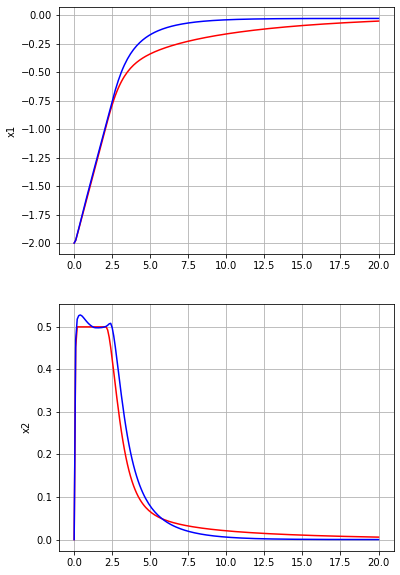

In [45]:
x_plot_real = np.array(x_real_list)
x_plot_pred = np.array(x_pred_list)
tgrid = [delta_t * k for k in range(N_sim + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (2):
    plt.subplot( str(2) + str(1) + str(i + 1) )
    plt.grid()
    
#     if i == 1:
#         constr_plot_temp = [0.65] * (N_sim + 1)
#         plt.plot(tgrid, constr_plot_temp, color="k")
    
    x_opt_real = x_plot_real[:,i]
    x_opt_pred = x_plot_pred[:,i]
    plt.plot(tgrid, x_opt_real, 'r')
    plt.plot(tgrid, x_opt_pred, 'b')
    plt.ylabel('x' + str(i + 1))

With slack variable for constraints

In [46]:
obj = 0

N_pred = 5
rho = 1e5

zi_var = ca.SX.sym('z', N_lift, N_pred+1)
z0_para = ca.SX.sym('z0', N_lift, 1)
ui_var = ca.SX.sym('u', 1, N_pred)

theta_slack_var = ca.SX.sym("theta",N_pred+1, 1)

# Q = 10 * np.eye(N_lift)
Q = np.diag([0]* (N_lift-2) + [20, 10] )
R = 1 * np.eye(1)
Qf = np.diag([0]* (N_lift-2) + [20, 10])
# Qf = 10 * np.eye(N_lift)

g = []


for i in range(N_pred):
    obj +=  zi_var[:,i].T @ Q @  zi_var[:,i] + ui_var[:,i].T @ R @ ui_var[:,i]
    if i == 0:
        g += [zi_var[:,i] - z0_para]
    else:
        g += [zi_var[:,i] - (A_lift_np @ zi_var[:,i-1] + B_lift_np @ ui_var[:,i-1])]

obj += zi_var[:, -1].T @ Qf @ zi_var[:, -1] + rho * ca.norm_2(theta_slack_var)
g += [zi_var[:, -1] - (A_lift_np @ zi_var[:,-2] + B_lift_np @ ui_var[:,-1])] # Terminal state 
for i in range(N_pred + 1):
    g += [zi_var[-1,i] - theta_slack_var[i,0]]
# g += [terminal_state - integrator_rk4(ode, xi_var[:,-2], ui_var[:,-1], delta_t)] # Terminal state         
dec_list = [ca.reshape(zi_var,-1,1), ca.reshape(ui_var,-1,1),ca.reshape(theta_slack_var,-1,1)]
para_list = [z0_para]
nlp_prob = {
    'f': obj,
    'x': ca.vertcat(*dec_list),
    'g': ca.vertcat(*g),
    'p': ca.vertcat(*para_list)
}
    

solver_opt = {}
solver_opt['print_time'] = False
solver_opt['ipopt'] = {
    'max_iter': 1500,
    'print_level': 3,
    'acceptable_constr_viol_tol': 0.1,
    'acceptable_tol': 5e-1,
}


solver_real = ca.nlpsol("solver", "ipopt", nlp_prob, solver_opt)  

In [47]:
ca.reshape(zi_var,-1,1).shape

(312, 1)

In [48]:
N_dec = ca.vertcat(*dec_list).shape

In [49]:
lbg =  [0] * N_lift * (N_pred + 1) + [-ca.inf] * (N_pred + 1)
ubg =  [0] * N_lift * (N_pred + 1) + [x2_ub] * (N_pred + 1)
lbx = [-ca.inf] * N_lift * (N_pred+1) + [-ca.inf] * (N_pred) + [0] * (N_pred + 1)
ubx = [ca.inf] * N_lift * (N_pred+1) + [ca.inf] * (N_pred) + [ca.inf] * (N_pred + 1)
# ubx = ([ca.inf] * (N_lift-2) + [x1_ub, x2_ub])  * (N_pred+1) + [ca.inf] * (N_pred)
nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg
nl['lbx'] = lbx
nl['ubx'] = ubx

In [50]:
x0 = np.array([[x1_start],[x2_start]])
z0 = lift_func(x0, Xc)
u0 = np.array([[0]])

x_pred_list = []
z_pred_list = []
xk = x0
zk = z0
uk = u0


x_pred_list.append(xk.flatten().tolist())
z_pred_list.append(zk.flatten().tolist())

u_ind = ca.reshape(zi_var,-1,1).shape[0]

In [51]:
# Simulation for 20 seconds
for i in range(N_sim):
#     print(xk.shape)
    p = np.vstack([zk])
#     print(p.shape)
    nl['p'] = p
#     print(zk)
    sol = solver_real(**nl)
    uk = sol['x'].full()[u_ind,0]
    zk = sol['x'].full()[:u_ind]
    z_pred_list += [zk]
    print("zk",zk[50::52],zk[51::52])
    x_next = integrator_rk4(ode,xk,uk,delta_t)
    print(uk,xk)
#     print("zk",zk)
#     print(zk[50::52],zk[51::52])
    x_pred_list.append(x_next.full().flatten().tolist())
    
    xk = x_next.full()
    zk = lift_func(xk, Xc)
#     print(xk.shape)

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Total number of variables............................:      323
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      312
Total number of inequality constraints...............:        6
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        6


Number of Iterations....: 176

                                   (scaled)                 (unscaled)
Objective...............:  1.1700183846549182e+004   1.1700183846549182e+004
Dual infeasibility......:  5.1233562504090798e+004   5.1233562504090798e+004
Constraint violation....:  2.3432367157738554e-012   2.7178259642823832e-012
Complementarity.........:  2.5059008927487806e-009   2.5059008927487806e-009
Overall NLP 

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]



Number of Iterations....: 87

                                   (scaled)                 (unscaled)
Objective...............:  6.0610835706397220e+003   6.0610835706397220e+003
Dual infeasibility......:  5.5590324500160881e+004   5.5590324500160881e+004
Constraint violation....:  2.1126696164184635e-012   2.5801583092288638e-012
Complementarity.........:  2.5059035380938585e-009   2.5059035380938585e-009
Overall NLP error.......:  5.5590324500160881e+004   5.5590324500160881e+004


Number of objective function evaluations             = 749
Number of objective gradient evaluations             = 64
Number of equality constraint evaluations            = 750
Number of inequality constraint evaluations          = 750
Number of equality constraint Jacobian evaluations   = 90
Number of inequality constraint Jacobian evaluations = 90
Number of Lagrangian Hessian evaluations             = 88
Total CPU secs in IPOPT (w/o function evaluations)   =      0.545
Total CPU secs in NLP function evalu

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]



                                   (scaled)                 (unscaled)
Objective...............:  1.8961546780849026e+003   1.8961546780849026e+003
Dual infeasibility......:  3.0036062526050955e-010   3.0036062526050955e-010
Constraint violation....:  1.5406629353362673e-012   1.9007018181582680e-012
Complementarity.........:  2.5090818253815933e-009   2.5090818253815933e-009
Overall NLP error.......:  2.9847629755447975e-011   2.5090818253815933e-009


Number of objective function evaluations             = 19
Number of objective gradient evaluations             = 19
Number of equality constraint evaluations            = 19
Number of inequality constraint evaluations          = 19
Number of equality constraint Jacobian evaluations   = 19
Number of inequality constraint Jacobian evaluations = 19
Number of Lagrangian Hessian evaluations             = 18
Total CPU secs in IPOPT (w/o function evaluations)   =      0.098
Total CPU secs in NLP function evaluations           =      0.002

EX

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]



Number of Iterations....: 20

                                   (scaled)                 (unscaled)
Objective...............:  1.1636332385932747e+003   1.1636332385932747e+003
Dual infeasibility......:  3.7431391319842078e-010   3.7431391319842078e-010
Constraint violation....:  1.5513853942511786e-012   1.6420198534206065e-012
Complementarity.........:  2.5090896315708336e-009   2.5090896315708336e-009
Overall NLP error.......:  2.9896710078572783e-011   2.5090896315708336e-009


Number of objective function evaluations             = 21
Number of objective gradient evaluations             = 21
Number of equality constraint evaluations            = 21
Number of inequality constraint evaluations          = 21
Number of equality constraint Jacobian evaluations   = 21
Number of inequality constraint Jacobian evaluations = 21
Number of Lagrangian Hessian evaluations             = 20
Total CPU secs in IPOPT (w/o function evaluations)   =      0.098
Total CPU secs in NLP function evaluati

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]



Number of Iterations....: 23

                                   (scaled)                 (unscaled)
Objective...............:  6.7189140602920179e+002   6.7189140602920179e+002
Dual infeasibility......:  4.7067342922346303e-009   4.7067342922346303e-009
Constraint violation....:  1.7242443702209176e-012   1.7505996652289466e-012
Complementarity.........:  2.5255972763139971e-009   2.5255972763139971e-009
Overall NLP error.......:  3.8362670583845824e-010   4.7067342922346303e-009


Number of objective function evaluations             = 24
Number of objective gradient evaluations             = 24
Number of equality constraint evaluations            = 24
Number of inequality constraint evaluations          = 24
Number of equality constraint Jacobian evaluations   = 24
Number of inequality constraint Jacobian evaluations = 24
Number of Lagrangian Hessian evaluations             = 23
Total CPU secs in IPOPT (w/o function evaluations)   =      0.111
Total CPU secs in NLP function evaluati

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]



Number of Iterations....: 29

                                   (scaled)                 (unscaled)
Objective...............:  3.4952265700941547e+002   3.4952265700941547e+002
Dual infeasibility......:  3.9518927642217785e-009   3.9518927642217785e-009
Constraint violation....:  1.2152501227546963e-012   1.2152501227546963e-012
Complementarity.........:  9.1038111162693812e-010   9.1038111162693812e-010
Overall NLP error.......:  3.4598420200878281e-010   3.9518927642217785e-009


Number of objective function evaluations             = 30
Number of objective gradient evaluations             = 30
Number of equality constraint evaluations            = 30
Number of inequality constraint evaluations          = 30
Number of equality constraint Jacobian evaluations   = 30
Number of inequality constraint Jacobian evaluations = 30
Number of Lagrangian Hessian evaluations             = 29
Total CPU secs in IPOPT (w/o function evaluations)   =      0.133
Total CPU secs in NLP function evaluati

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 4.276870e-011. Abort.

Number of Iterations....: 49

                                   (scaled)                 (unscaled)
Objective...............:  2.9396451501855529e+002   2.9396451501855529e+002
Dual infeasibility......:  2.4968523197822834e+005   2.4968523197822834e+005
Constraint violation....:  1.0410273852786179e-012   1.2843059948863811e-012
Complementarity.........:  2.6840235717120516e-003   2.6840235717120516e-003
Overall NLP error.......:  2.4725196713273886e+004   2.4968523197822834e+005


Number of objective function evaluations             = 495
Number of objective gradient evaluations             = 51
Number of equality constraint evaluations            = 495
Number of inequality constraint evaluations          = 495
Number of equality constraint Jacobian evaluations   = 51
Number of inequality constraint Jacobian evaluations = 51
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]



Number of Iterations....: 64

                                   (scaled)                 (unscaled)
Objective...............:  2.5992944681035323e+002   2.5992944681035323e+002
Dual infeasibility......:  2.5252113606256898e-002   2.5252113606256898e-002
Constraint violation....:  9.9827863328097708e-013   1.0582368314970836e-012
Complementarity.........:  2.8289077950811301e-003   2.8289077950811301e-003
Overall NLP error.......:  2.8145131832048955e-003   2.5252113606256898e-002


Number of objective function evaluations             = 673
Number of objective gradient evaluations             = 66
Number of equality constraint evaluations            = 673
Number of inequality constraint evaluations          = 673
Number of equality constraint Jacobian evaluations   = 66
Number of inequality constraint Jacobian evaluations = 66
Number of Lagrangian Hessian evaluations             = 65
Total CPU secs in IPOPT (w/o function evaluations)   =      0.260
Total CPU secs in NLP function evalu

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 6.107517e-011. Abort.

Number of Iterations....: 128

                                   (scaled)                 (unscaled)
Objective...............:  2.3080083901961555e+002   2.3080083901961555e+002
Dual infeasibility......:  7.0379093808492602e+004   7.0379093808492602e+004
Constraint violation....:  1.3194666386256940e-012   1.4137579995576743e-012
Complementarity.........:  3.6491848488326396e-004   3.6491848488326396e-004
Overall NLP error.......:  1.9133767308984996e+004   7.0379093808492602e+004


Number of objective function evaluations             = 2123
Number of objective gradient evaluations             = 130
Number of equality constraint evaluations            = 2123
Number of inequality constraint evaluations          = 2123
Number of equality constraint Jacobian evaluations   = 130
Number of inequality constraint Jacobian evaluations = 130
Number of Lagrangian Hessian evaluations 

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 5.209689e-011. Abort.

Number of Iterations....: 41

                                   (scaled)                 (unscaled)
Objective...............:  2.0610701832838623e+002   2.0610701832838623e+002
Dual infeasibility......:  8.6892053854309866e+004   8.6892053854309866e+004
Constraint violation....:  1.0341704934107539e-012   1.0844658504538529e-012
Complementarity.........:  3.7768445756455659e-004   3.7768445756455659e-004
Overall NLP error.......:  4.3744981804917719e+004   8.6892053854309866e+004


Number of objective function evaluations             = 344
Number of objective gradient evaluations             = 43
Number of equality constraint evaluations            = 344
Number of inequality constraint evaluations          = 344
Number of equality constraint Jacobian evaluations   = 43
Number of inequality constraint Jacobian evaluations = 43
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 5.351119e-011. Abort.

Number of Iterations....: 36

                                   (scaled)                 (unscaled)
Objective...............:  1.8510201646898423e+002   1.8510201646898423e+002
Dual infeasibility......:  6.3601361873300862e+004   6.3601361873300862e+004
Constraint violation....:  1.0371323455180567e-012   1.1883827255587676e-012
Complementarity.........:  4.3518337553186256e-004   4.3518337553186256e-004
Overall NLP error.......:  6.3601361873300862e+004   6.3601361873300862e+004


Number of objective function evaluations             = 359
Number of objective gradient evaluations             = 38
Number of equality constraint evaluations            = 359
Number of inequality constraint evaluations          = 359
Number of equality constraint Jacobian evaluations   = 38
Number of inequality constraint Jacobian evaluations = 38
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 3.764355e-011. Abort.

Number of Iterations....: 62

                                   (scaled)                 (unscaled)
Objective...............:  1.6690637841625554e+002   1.6690637841625554e+002
Dual infeasibility......:  4.7823946454837838e+004   4.7823946454837838e+004
Constraint violation....:  1.1427615627296627e-012   1.1723955140041653e-012
Complementarity.........:  2.9589670916698482e-004   2.9589670916698482e-004
Overall NLP error.......:  3.2819515938340694e+004   4.7823946454837838e+004


Number of objective function evaluations             = 938
Number of objective gradient evaluations             = 64
Number of equality constraint evaluations            = 938
Number of inequality constraint evaluations          = 938
Number of equality constraint Jacobian evaluations   = 64
Number of inequality constraint Jacobian evaluations = 64
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 3.710978e-011. Abort.

Number of Iterations....: 50

                                   (scaled)                 (unscaled)
Objective...............:  1.5081824619402681e+002   1.5081824619402681e+002
Dual infeasibility......:  9.7299087660671823e+004   9.7299087660671823e+004
Constraint violation....:  9.5272762532286394e-013   1.2079226507921703e-012
Complementarity.........:  1.6011661666008798e-004   1.6011661666008798e-004
Overall NLP error.......:  9.7299087660671823e+004   9.7299087660671823e+004


Number of objective function evaluations             = 429
Number of objective gradient evaluations             = 52
Number of equality constraint evaluations            = 429
Number of inequality constraint evaluations          = 429
Number of equality constraint Jacobian evaluations   = 52
Number of inequality constraint Jacobian evaluations = 52
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 3.496727e-011. Abort.

Number of Iterations....: 218

                                   (scaled)                 (unscaled)
Objective...............:  1.3645097941535144e+002   1.3645097941535144e+002
Dual infeasibility......:  7.0384260291710088e+004   7.0384260291710088e+004
Constraint violation....:  8.5992254075346592e-013   9.2137408813641741e-013
Complementarity.........:  4.2768340322876921e-004   4.2768340322876921e-004
Overall NLP error.......:  1.7873991542391752e+004   7.0384260291710088e+004


Number of objective function evaluations             = 3019
Number of objective gradient evaluations             = 220
Number of equality constraint evaluations            = 3019
Number of inequality constraint evaluations          = 3019
Number of equality constraint Jacobian evaluations   = 220
Number of inequality constraint Jacobian evaluations = 220
Number of Lagrangian Hessian evaluations 

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 2.838671e-011. Abort.

Number of Iterations....: 51

                                   (scaled)                 (unscaled)
Objective...............:  1.1146177931067598e+002   1.1146177931067598e+002
Dual infeasibility......:  5.5742480187074136e+004   5.5742480187074136e+004
Constraint violation....:  6.2719590484413855e-013   6.6102678886181820e-013
Complementarity.........:  1.9410542402501776e-004   1.9410542402501776e-004
Overall NLP error.......:  4.3276010435037453e+004   5.5742480187074136e+004


Number of objective function evaluations             = 571
Number of objective gradient evaluations             = 53
Number of equality constraint evaluations            = 571
Number of inequality constraint evaluations          = 571
Number of equality constraint Jacobian evaluations   = 53
Number of inequality constraint Jacobian evaluations = 53
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      312
Total number of inequality constraints...............:        6
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        6


Number of Iterations....: 27

                                   (scaled)                 (unscaled)
Objective...............:  3.1142947148657538e+002   3.1142947148657538e+002
Dual infeasibility......:  6.9226080125255486e-006   6.9226080125255486e-006
Constraint violation....:  7.3857775580388478e-013   7.4640293945549274e-013
Complementarity.........:  8.6320678092608967e-009   8.6320678092608967e-009
Overall NLP error.......:  7.5560495022715367e-007   6.9226080125255486e-006


CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 2.463145e-011. Abort.

Number of Iterations....: 23

                                   (scaled)                 (unscaled)
Objective...............:  7.1642065094269256e+001   7.1642065094269256e+001
Dual infeasibility......:  9.1453859546698397e+004   9.1453859546698397e+004
Constraint violation....:  5.1987238478109141e-013   5.3024251656097476e-013
Complementarity.........:  1.2316872613048349e-003   1.2316872613048349e-003
Overall NLP error.......:  9.1453859546698397e+004   9.1453859546698397e+004


Number of objective function evaluations             = 154
Number of objective gradient evaluations             = 25
Number of equality constraint evaluations            = 154
Number of inequality constraint evaluations          = 154
Number of equality constraint Jacobian evaluations   = 25
Number of inequality constraint Jacobian evaluations = 25
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.987957e-011. Abort.

Number of Iterations....: 62

                                   (scaled)                 (unscaled)
Objective...............:  6.3458065317939408e+001   6.3458065317939408e+001
Dual infeasibility......:  8.1539001449039526e+004   8.1539001449039526e+004
Constraint violation....:  3.7399469325698055e-013   3.8369307731045410e-013
Complementarity.........:  1.0011472550220718e-003   1.0011472550220718e-003
Overall NLP error.......:  2.6036770471777898e+004   8.1539001449039526e+004


Number of objective function evaluations             = 750
Number of objective gradient evaluations             = 64
Number of equality constraint evaluations            = 750
Number of inequality constraint evaluations          = 750
Number of equality constraint Jacobian evaluations   = 64
Number of inequality constraint Jacobian evaluations = 64
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.976162e-011. Abort.

Number of Iterations....: 62

                                   (scaled)                 (unscaled)
Objective...............:  5.6100010064191864e+001   5.6100010064191864e+001
Dual infeasibility......:  5.2480203895821316e+004   5.2480203895821316e+004
Constraint violation....:  4.0639255050738746e-013   5.0626169922907138e-013
Complementarity.........:  2.5519795991681745e-005   2.5519795991681745e-005
Overall NLP error.......:  5.2480203895821316e+004   5.2480203895821316e+004


Number of objective function evaluations             = 810
Number of objective gradient evaluations             = 64
Number of equality constraint evaluations            = 810
Number of inequality constraint evaluations          = 810
Number of equality constraint Jacobian evaluations   = 64
Number of inequality constraint Jacobian evaluations = 64
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 2.000299e-011. Abort.

Number of Iterations....: 149

                                   (scaled)                 (unscaled)
Objective...............:  4.9570251478974981e+001   4.9570251478974981e+001
Dual infeasibility......:  9.6302498815940446e+004   9.6302498815940446e+004
Constraint violation....:  5.5714412986599632e-013   7.1764816311770119e-013
Complementarity.........:  1.8449226412199363e-006   1.8449226412199363e-006
Overall NLP error.......:  9.6302498815940446e+004   9.6302498815940446e+004


Number of objective function evaluations             = 1346
Number of objective gradient evaluations             = 151
Number of equality constraint evaluations            = 1346
Number of inequality constraint evaluations          = 1346
Number of equality constraint Jacobian evaluations   = 151
Number of inequality constraint Jacobian evaluations = 151
Number of Lagrangian Hessian evaluations 

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.821126e-011. Abort.

Number of Iterations....: 36

                                   (scaled)                 (unscaled)
Objective...............:  4.3838218728361852e+001   4.3838218728361852e+001
Dual infeasibility......:  1.1611271753347399e+005   1.1611271753347399e+005
Constraint violation....:  4.4672451154556092e-013   4.5563552930616424e-013
Complementarity.........:  1.6683312496859545e-003   1.6683312496859545e-003
Overall NLP error.......:  2.2891870734836302e+004   1.1611271753347399e+005


Number of objective function evaluations             = 316
Number of objective gradient evaluations             = 38
Number of equality constraint evaluations            = 316
Number of inequality constraint evaluations          = 316
Number of equality constraint Jacobian evaluations   = 38
Number of inequality constraint Jacobian evaluations = 38
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Total number of variables............................:      323
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      312
Total number of inequality constraints...............:        6
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        6

Restoration phase is called at point that is almost feasible,
  with constraint violation 1.482199e-011. Abort.

Number of Iterations....: 36

                                   (scaled)                 (unscaled)
Objective...............:  3.4517136752131393e+001   3.4517136752131393e+001
Dual infeasibility......:  5.0404349999970153e+004   5.0404349999970153e+004
Constraint violation....:  3.2957508068000216e-013   3.

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Total number of variables............................:      323
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      312
Total number of inequality constraints...............:        6
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        6


Number of Iterations....: 88

                                   (scaled)                 (unscaled)
Objective...............:  2.7569887949331701e+001   2.7569887949331701e+001
Dual infeasibility......:  4.4148407177999616e-003   4.4148407177999616e-003
Constraint violation....:  3.7745760708343407e-013   4.2277292777725961e-013
Complementarity.........:  2.8284629102244782e-003   2.8284629102244782e-003
Overall NLP e

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]



Number of Iterations....: 50

                                   (scaled)                 (unscaled)
Objective...............:  2.4782928213651576e+001   2.4782928213651576e+001
Dual infeasibility......:  2.8911349436384626e-003   2.8911349436384626e-003
Constraint violation....:  4.1891994113461224e-013   5.3113069498067489e-013
Complementarity.........:  2.8284443674553394e-003   2.8284443674553394e-003
Overall NLP error.......:  3.8692428484303720e-004   2.8911349436384626e-003


Number of objective function evaluations             = 470
Number of objective gradient evaluations             = 52
Number of equality constraint evaluations            = 470
Number of inequality constraint evaluations          = 470
Number of equality constraint Jacobian evaluations   = 52
Number of inequality constraint Jacobian evaluations = 52
Number of Lagrangian Hessian evaluations             = 51
Total CPU secs in IPOPT (w/o function evaluations)   =      0.203
Total CPU secs in NLP function evalu

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]



Number of Iterations....: 91

                                   (scaled)                 (unscaled)
Objective...............:  2.2368289674951342e+001   2.2368289674951342e+001
Dual infeasibility......:  2.1702195081161335e-003   2.1702195081161335e-003
Constraint violation....:  2.7865856470678264e-013   3.3395508580724704e-013
Complementarity.........:  2.8284366940645308e-003   2.8284366940645308e-003
Overall NLP error.......:  2.9020366927373376e-004   2.8284366940645308e-003


Number of objective function evaluations             = 760
Number of objective gradient evaluations             = 93
Number of equality constraint evaluations            = 760
Number of inequality constraint evaluations          = 760
Number of equality constraint Jacobian evaluations   = 93
Number of inequality constraint Jacobian evaluations = 93
Number of Lagrangian Hessian evaluations             = 92
Total CPU secs in IPOPT (w/o function evaluations)   =      0.366
Total CPU secs in NLP function evalu

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]



Number of Iterations....: 1500

                                   (scaled)                 (unscaled)
Objective...............:  2.0253906999470164e+001   2.0253906999470164e+001
Dual infeasibility......:  4.1370622732426098e+004   4.1370622732426098e+004
Constraint violation....:  3.4771002832563210e-013   3.6859404417555197e-013
Complementarity.........:  4.4900059836655752e-005   4.4900059836655752e-005
Overall NLP error.......:  4.1370622732426098e+004   4.1370622732426098e+004


Number of objective function evaluations             = 48490
Number of objective gradient evaluations             = 1501
Number of equality constraint evaluations            = 48490
Number of inequality constraint evaluations          = 48490
Number of equality constraint Jacobian evaluations   = 1501
Number of inequality constraint Jacobian evaluations = 1501
Number of Lagrangian Hessian evaluations             = 1500
Total CPU secs in IPOPT (w/o function evaluations)   =      9.559
Total CPU secs in NL

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]



Number of Iterations....: 71

                                   (scaled)                 (unscaled)
Objective...............:  1.8434052308759536e+001   1.8434052308759536e+001
Dual infeasibility......:  1.2444761596270837e-003   1.2444761596270837e-003
Constraint violation....:  3.0797586703101842e-013   3.5171865420124959e-013
Complementarity.........:  2.8284312081525002e-003   2.8284312081525002e-003
Overall NLP error.......:  1.6618463839619170e-004   2.8284312081525002e-003


Number of objective function evaluations             = 963
Number of objective gradient evaluations             = 73
Number of equality constraint evaluations            = 963
Number of inequality constraint evaluations          = 963
Number of equality constraint Jacobian evaluations   = 73
Number of inequality constraint Jacobian evaluations = 73
Number of Lagrangian Hessian evaluations             = 72
Total CPU secs in IPOPT (w/o function evaluations)   =      0.293
Total CPU secs in NLP function evalu

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]



Number of Iterations....: 1500

                                   (scaled)                 (unscaled)
Objective...............:  1.6809646837473430e+001   1.6809646837473430e+001
Dual infeasibility......:  2.9720390461257409e+005   2.9720390461257409e+005
Constraint violation....:  4.1102138294250442e-013   4.1922021409845911e-013
Complementarity.........:  2.6024121631953029e-003   2.6024121631953029e-003
Overall NLP error.......:  3.6172843711483336e+004   2.9720390461257409e+005


Number of objective function evaluations             = 45885
Number of objective gradient evaluations             = 1501
Number of equality constraint evaluations            = 45885
Number of inequality constraint evaluations          = 45885
Number of equality constraint Jacobian evaluations   = 1501
Number of inequality constraint Jacobian evaluations = 1501
Number of Lagrangian Hessian evaluations             = 1500
Total CPU secs in IPOPT (w/o function evaluations)   =      8.831
Total CPU secs in NL

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]



Number of Iterations....: 49

                                   (scaled)                 (unscaled)
Objective...............:  1.4145370198851140e+001   1.4145370198851140e+001
Dual infeasibility......:  5.2041465824004263e-004   5.2041465824004263e-004
Constraint violation....:  3.8062321743320539e-013   4.9027448767446913e-013
Complementarity.........:  2.8284291517554523e-003   2.8284291517554523e-003
Overall NLP error.......:  6.9395696904244798e-005   2.8284291517554523e-003


Number of objective function evaluations             = 433
Number of objective gradient evaluations             = 51
Number of equality constraint evaluations            = 433
Number of inequality constraint evaluations          = 433
Number of equality constraint Jacobian evaluations   = 51
Number of inequality constraint Jacobian evaluations = 51
Number of Lagrangian Hessian evaluations             = 50
Total CPU secs in IPOPT (w/o function evaluations)   =      0.196
Total CPU secs in NLP function evalu

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.529030e-011. Abort.

Number of Iterations....: 137

                                   (scaled)                 (unscaled)
Objective...............:  1.3009963559032535e+001   1.3009963559032535e+001
Dual infeasibility......:  3.7481533596024587e+004   3.7481533596024587e+004
Constraint violation....:  3.0403219808097276e-013   3.8546943414985435e-013
Complementarity.........:  7.8887020409167086e-004   7.8887020409167086e-004
Overall NLP error.......:  4.9911616068162539e+003   3.7481533596024587e+004


Number of objective function evaluations             = 2196
Number of objective gradient evaluations             = 139
Number of equality constraint evaluations            = 2196
Number of inequality constraint evaluations          = 2196
Number of equality constraint Jacobian evaluations   = 139
Number of inequality constraint Jacobian evaluations = 139
Number of Lagrangian Hessian evaluations 

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.528963e-011. Abort.

Number of Iterations....: 177

                                   (scaled)                 (unscaled)
Objective...............:  1.2008865299246445e+001   1.2008865299246445e+001
Dual infeasibility......:  6.0606767557106818e+004   6.0606767557106818e+004
Constraint violation....:  3.1346326742971390e-013   3.4816594052244909e-013
Complementarity.........:  1.5042412733453568e-004   1.5042412733453568e-004
Overall NLP error.......:  5.0088803407581996e+004   6.0606767557106818e+004


Number of objective function evaluations             = 3437
Number of objective gradient evaluations             = 179
Number of equality constraint evaluations            = 3437
Number of inequality constraint evaluations          = 3437
Number of equality constraint Jacobian evaluations   = 179
Number of inequality constraint Jacobian evaluations = 179
Number of Lagrangian Hessian evaluations 

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.313438e-011. Abort.

Number of Iterations....: 61

                                   (scaled)                 (unscaled)
Objective...............:  1.1107163073548143e+001   1.1107163073548143e+001
Dual infeasibility......:  4.7738142127161700e+004   4.7738142127161700e+004
Constraint violation....:  2.3831888762821123e-013   2.6467716907063732e-013
Complementarity.........:  1.9330180909540813e-004   1.9330180909540813e-004
Overall NLP error.......:  4.7738142127161700e+004   4.7738142127161700e+004


Number of objective function evaluations             = 677
Number of objective gradient evaluations             = 63
Number of equality constraint evaluations            = 677
Number of inequality constraint evaluations          = 677
Number of equality constraint Jacobian evaluations   = 63
Number of inequality constraint Jacobian evaluations = 63
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]



Number of Iterations....: 1500

                                   (scaled)                 (unscaled)
Objective...............:  1.0295953883529016e+001   1.0295953883529016e+001
Dual infeasibility......:  4.1444267751957566e+004   4.1444267751957566e+004
Constraint violation....:  3.0615345750062175e-013   3.9435121834685565e-013
Complementarity.........:  1.5042414305734860e-004   1.5042414305734860e-004
Overall NLP error.......:  4.1444267751957566e+004   4.1444267751957566e+004


Number of objective function evaluations             = 48521
Number of objective gradient evaluations             = 1501
Number of equality constraint evaluations            = 48521
Number of inequality constraint evaluations          = 48521
Number of equality constraint Jacobian evaluations   = 1501
Number of inequality constraint Jacobian evaluations = 1501
Number of Lagrangian Hessian evaluations             = 1500
Total CPU secs in IPOPT (w/o function evaluations)   =      9.351
Total CPU secs in NL

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.150968e-011. Abort.

Number of Iterations....: 153

                                   (scaled)                 (unscaled)
Objective...............:  9.5564247272353953e+000   9.5564247272353953e+000
Dual infeasibility......:  9.9370126196980214e+004   9.9370126196980214e+004
Constraint violation....:  2.2206969970179852e-013   4.3343106881366111e-013
Complementarity.........:  1.5042439311693565e-004   1.5042439311693565e-004
Overall NLP error.......:  9.9370126196980214e+004   9.9370126196980214e+004


Number of objective function evaluations             = 2397
Number of objective gradient evaluations             = 155
Number of equality constraint evaluations            = 2397
Number of inequality constraint evaluations          = 2397
Number of equality constraint Jacobian evaluations   = 155
Number of inequality constraint Jacobian evaluations = 155
Number of Lagrangian Hessian evaluations 

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.323220e-011. Abort.

Number of Iterations....: 76

                                   (scaled)                 (unscaled)
Objective...............:  8.8882553137491698e+000   8.8882553137491698e+000
Dual infeasibility......:  5.1940919093713877e+004   5.1940919093713877e+004
Constraint violation....:  2.7544952363189520e-013   3.4816594052244909e-013
Complementarity.........:  3.6089187853984050e-004   3.6089187853984050e-004
Overall NLP error.......:  2.6799093795587884e+004   5.1940919093713877e+004


Number of objective function evaluations             = 868
Number of objective gradient evaluations             = 78
Number of equality constraint evaluations            = 868
Number of inequality constraint evaluations          = 868
Number of equality constraint Jacobian evaluations   = 78
Number of inequality constraint Jacobian evaluations = 78
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.055401e-011. Abort.

Number of Iterations....: 494

                                   (scaled)                 (unscaled)
Objective...............:  8.2781153649764114e+000   8.2781153649764114e+000
Dual infeasibility......:  6.9625587625636515e+004   6.9625587625636515e+004
Constraint violation....:  1.8718334728384556e-013   2.7000623958883807e-013
Complementarity.........:  3.0747326767897681e-004   3.0747326767897681e-004
Overall NLP error.......:  2.5974139890955248e+004   6.9625587625636515e+004


Number of objective function evaluations             = 11379
Number of objective gradient evaluations             = 496
Number of equality constraint evaluations            = 11379
Number of inequality constraint evaluations          = 11379
Number of equality constraint Jacobian evaluations   = 496
Number of inequality constraint Jacobian evaluations = 496
Number of Lagrangian Hessian evaluatio

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.354602e-011. Abort.

Number of Iterations....: 131

                                   (scaled)                 (unscaled)
Objective...............:  7.7223166371369079e+000   7.7223166371369079e+000
Dual infeasibility......:  8.1675812396018184e+004   8.1675812396018184e+004
Constraint violation....:  3.6959066040615598e-013   4.7606363295926712e-013
Complementarity.........:  1.5042419379162963e-004   1.5042419379162963e-004
Overall NLP error.......:  8.1675812396018184e+004   8.1675812396018184e+004


Number of objective function evaluations             = 1761
Number of objective gradient evaluations             = 133
Number of equality constraint evaluations            = 1761
Number of inequality constraint evaluations          = 1761
Number of equality constraint Jacobian evaluations   = 133
Number of inequality constraint Jacobian evaluations = 133
Number of Lagrangian Hessian evaluations 

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.426198e-011. Abort.

Number of Iterations....: 128

                                   (scaled)                 (unscaled)
Objective...............:  7.2118401081397163e+000   7.2118401081397163e+000
Dual infeasibility......:  6.4236979325663546e+004   6.4236979325663546e+004
Constraint violation....:  2.8862042767133822e-013   3.6592950891645165e-013
Complementarity.........:  1.5732272069675582e-004   1.5732272069675582e-004
Overall NLP error.......:  6.4236979325663546e+004   6.4236979325663546e+004


Number of objective function evaluations             = 1697
Number of objective gradient evaluations             = 130
Number of equality constraint evaluations            = 1697
Number of inequality constraint evaluations          = 1697
Number of equality constraint Jacobian evaluations   = 130
Number of inequality constraint Jacobian evaluations = 130
Number of Lagrangian Hessian evaluations 

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.081483e-011. Abort.

Number of Iterations....: 201

                                   (scaled)                 (unscaled)
Objective...............:  6.7440120676279482e+000   6.7440120676279482e+000
Dual infeasibility......:  6.9621821537872296e+004   6.9621821537872296e+004
Constraint violation....:  2.2697334603279993e-013   2.8776980798284058e-013
Complementarity.........:  7.9542329937850025e-004   7.9542329937850025e-004
Overall NLP error.......:  2.3136561156495838e+004   6.9621821537872296e+004


Number of objective function evaluations             = 4422
Number of objective gradient evaluations             = 203
Number of equality constraint evaluations            = 4422
Number of inequality constraint evaluations          = 4422
Number of equality constraint Jacobian evaluations   = 203
Number of inequality constraint Jacobian evaluations = 203
Number of Lagrangian Hessian evaluations 

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 9.846298e-012. Abort.

Number of Iterations....: 233

                                   (scaled)                 (unscaled)
Objective...............:  6.3116252187417254e+000   6.3116252187417254e+000
Dual infeasibility......:  2.1558234620096179e+005   2.1558234620096179e+005
Constraint violation....:  1.8065812131793443e-013   2.6645352591003757e-013
Complementarity.........:  2.2174305262236908e-003   2.2174305262236908e-003
Overall NLP error.......:  1.6835419898981232e+004   2.1558234620096179e+005


Number of objective function evaluations             = 3648
Number of objective gradient evaluations             = 235
Number of equality constraint evaluations            = 3648
Number of inequality constraint evaluations          = 3648
Number of equality constraint Jacobian evaluations   = 235
Number of inequality constraint Jacobian evaluations = 235
Number of Lagrangian Hessian evaluations 

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.046791e-011. Abort.

Number of Iterations....: 247

                                   (scaled)                 (unscaled)
Objective...............:  5.9144414717515490e+000   5.9144414717515490e+000
Dual infeasibility......:  7.2839483045243484e+004   7.2839483045243484e+004
Constraint violation....:  2.1723462932709217e-013   2.4868995751603507e-013
Complementarity.........:  1.5042412390103160e-004   1.5042412390103160e-004
Overall NLP error.......:  7.2839483045243484e+004   7.2839483045243484e+004


Number of objective function evaluations             = 3555
Number of objective gradient evaluations             = 249
Number of equality constraint evaluations            = 3555
Number of inequality constraint evaluations          = 3555
Number of equality constraint Jacobian evaluations   = 249
Number of inequality constraint Jacobian evaluations = 249
Number of Lagrangian Hessian evaluations 

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.130105e-011. Abort.

Number of Iterations....: 109

                                   (scaled)                 (unscaled)
Objective...............:  5.5502256437003137e+000   5.5502256437003137e+000
Dual infeasibility......:  6.2993284709763218e+004   6.2993284709763218e+004
Constraint violation....:  1.8729498132564298e-013   3.3395508580724709e-013
Complementarity.........:  1.6710462128444544e-004   1.6710462128444544e-004
Overall NLP error.......:  3.3341327444134084e+004   6.2993284709763218e+004


Number of objective function evaluations             = 1753
Number of objective gradient evaluations             = 111
Number of equality constraint evaluations            = 1753
Number of inequality constraint evaluations          = 1753
Number of equality constraint Jacobian evaluations   = 111
Number of inequality constraint Jacobian evaluations = 111
Number of Lagrangian Hessian evaluations 

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.202380e-011. Abort.

Number of Iterations....: 128

                                   (scaled)                 (unscaled)
Objective...............:  5.2088431723424549e+000   5.2088431723424549e+000
Dual infeasibility......:  8.4631161477211208e+004   8.4631161477211208e+004
Constraint violation....:  2.4823253310861222e-013   4.2632564145606011e-013
Complementarity.........:  1.5042414647468492e-004   1.5042414647468492e-004
Overall NLP error.......:  6.2099951817650472e+004   8.4631161477211208e+004


Number of objective function evaluations             = 1662
Number of objective gradient evaluations             = 130
Number of equality constraint evaluations            = 1662
Number of inequality constraint evaluations          = 1662
Number of equality constraint Jacobian evaluations   = 130
Number of inequality constraint Jacobian evaluations = 130
Number of Lagrangian Hessian evaluations 

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.070410e-011. Abort.

Number of Iterations....: 199

                                   (scaled)                 (unscaled)
Objective...............:  4.8951799713635848e+000   4.8951799713635848e+000
Dual infeasibility......:  9.9664755701708578e+004   9.9664755701708578e+004
Constraint violation....:  1.7139732351102976e-013   3.4816594052244909e-013
Complementarity.........:  6.7461213089303285e-004   6.7461213089303285e-004
Overall NLP error.......:  3.9074772641163298e+004   9.9664755701708578e+004


Number of objective function evaluations             = 3517
Number of objective gradient evaluations             = 201
Number of equality constraint evaluations            = 3517
Number of inequality constraint evaluations          = 3517
Number of equality constraint Jacobian evaluations   = 201
Number of inequality constraint Jacobian evaluations = 201
Number of Lagrangian Hessian evaluations 

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.013587e-011. Abort.

Number of Iterations....: 138

                                   (scaled)                 (unscaled)
Objective...............:  4.6045178711966175e+000   4.6045178711966175e+000
Dual infeasibility......:  1.8159091809566889e+004   1.8159091809566889e+004
Constraint violation....:  2.5017892513355618e-013   3.6948222259525210e-013
Complementarity.........:  5.7850298880220705e-004   5.7850298880220705e-004
Overall NLP error.......:  2.3831392655389927e+003   1.8159091809566889e+004


Number of objective function evaluations             = 2478
Number of objective gradient evaluations             = 140
Number of equality constraint evaluations            = 2478
Number of inequality constraint evaluations          = 2478
Number of equality constraint Jacobian evaluations   = 140
Number of inequality constraint Jacobian evaluations = 140
Number of Lagrangian Hessian evaluations 

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.070929e-011. Abort.

Number of Iterations....: 180

                                   (scaled)                 (unscaled)
Objective...............:  4.3365573470948320e+000   4.3365573470948320e+000
Dual infeasibility......:  6.1730947713706817e+004   6.1730947713706817e+004
Constraint violation....:  1.9698628519626118e-013   2.4868995751603507e-013
Complementarity.........:  2.1666498180476329e-004   2.1666498180476329e-004
Overall NLP error.......:  3.7405730475542674e+004   6.1730947713706817e+004


Number of objective function evaluations             = 2729
Number of objective gradient evaluations             = 182
Number of equality constraint evaluations            = 2729
Number of inequality constraint evaluations          = 2729
Number of equality constraint Jacobian evaluations   = 182
Number of inequality constraint Jacobian evaluations = 182
Number of Lagrangian Hessian evaluations 

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.093551e-011. Abort.

Number of Iterations....: 314

                                   (scaled)                 (unscaled)
Objective...............:  4.0916250257733591e+000   4.0916250257733591e+000
Dual infeasibility......:  9.7322288728080268e+004   9.7322288728080268e+004
Constraint violation....:  2.2697334603279993e-013   2.8776980798284058e-013
Complementarity.........:  1.5042412373580073e-004   1.5042412373580073e-004
Overall NLP error.......:  6.6519215746620495e+004   9.7322288728080268e+004


Number of objective function evaluations             = 4602
Number of objective gradient evaluations             = 316
Number of equality constraint evaluations            = 4602
Number of inequality constraint evaluations          = 4602
Number of equality constraint Jacobian evaluations   = 316
Number of inequality constraint Jacobian evaluations = 316
Number of Lagrangian Hessian evaluations 

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.073027e-011. Abort.

Number of Iterations....: 143

                                   (scaled)                 (unscaled)
Objective...............:  3.8526361647773069e+000   3.8526361647773069e+000
Dual infeasibility......:  8.0315332314573126e+004   8.0315332314573126e+004
Constraint violation....:  2.5788602050728049e-013   3.3217872896784689e-013
Complementarity.........:  1.5042423505862639e-004   1.5042423505862639e-004
Overall NLP error.......:  8.0315332314573126e+004   8.0315332314573126e+004


Number of objective function evaluations             = 2124
Number of objective gradient evaluations             = 145
Number of equality constraint evaluations            = 2124
Number of inequality constraint evaluations          = 2124
Number of equality constraint Jacobian evaluations   = 145
Number of inequality constraint Jacobian evaluations = 145
Number of Lagrangian Hessian evaluations 

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.202704e-011. Abort.

Number of Iterations....: 179

                                   (scaled)                 (unscaled)
Objective...............:  3.6368417821288048e+000   3.6368417821288048e+000
Dual infeasibility......:  7.3842615542403888e+004   7.3842615542403888e+004
Constraint violation....:  2.1856692580936290e-013   3.1263880373444408e-013
Complementarity.........:  1.5042415595732607e-004   1.5042415595732607e-004
Overall NLP error.......:  7.3842615542403888e+004   7.3842615542403888e+004


Number of objective function evaluations             = 2535
Number of objective gradient evaluations             = 181
Number of equality constraint evaluations            = 2535
Number of inequality constraint evaluations          = 2535
Number of equality constraint Jacobian evaluations   = 181
Number of inequality constraint Jacobian evaluations = 181
Number of Lagrangian Hessian evaluations 

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.366771e-011. Abort.

Number of Iterations....: 59

                                   (scaled)                 (unscaled)
Objective...............:  3.4362677253075073e+000   3.4362677253075073e+000
Dual infeasibility......:  2.6369253253853756e+004   2.6369253253853756e+004
Constraint violation....:  2.5070981752251420e-013   4.0500935938325711e-013
Complementarity.........:  5.5316961608713492e-004   5.5316961608713492e-004
Overall NLP error.......:  3.4998892003880178e+003   2.6369253253853756e+004


Number of objective function evaluations             = 765
Number of objective gradient evaluations             = 61
Number of equality constraint evaluations            = 765
Number of inequality constraint evaluations          = 765
Number of equality constraint Jacobian evaluations   = 61
Number of inequality constraint Jacobian evaluations = 61
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.274614e-011. Abort.

Number of Iterations....: 249

                                   (scaled)                 (unscaled)
Objective...............:  3.2504825731674947e+000   3.2504825731674947e+000
Dual infeasibility......:  6.3733667294948951e+004   6.3733667294948951e+004
Constraint violation....:  2.6693226529812144e-013   4.2277292777725961e-013
Complementarity.........:  1.5355439479431343e-004   1.5355439479431343e-004
Overall NLP error.......:  5.3145321653338557e+004   6.3733667294948951e+004


Number of objective function evaluations             = 4464
Number of objective gradient evaluations             = 251
Number of equality constraint evaluations            = 4464
Number of inequality constraint evaluations          = 4464
Number of equality constraint Jacobian evaluations   = 251
Number of inequality constraint Jacobian evaluations = 251
Number of Lagrangian Hessian evaluations 

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.158336e-011. Abort.

Number of Iterations....: 140

                                   (scaled)                 (unscaled)
Objective...............:  3.0764502484225797e+000   3.0764502484225797e+000
Dual infeasibility......:  7.5812664165239010e+004   7.5812664165239010e+004
Constraint violation....:  2.1470065724011847e-013   2.3270274596143281e-013
Complementarity.........:  1.5042413645206069e-004   1.5042413645206069e-004
Overall NLP error.......:  7.5812664165239010e+004   7.5812664165239010e+004


Number of objective function evaluations             = 2017
Number of objective gradient evaluations             = 142
Number of equality constraint evaluations            = 2017
Number of inequality constraint evaluations          = 2017
Number of equality constraint Jacobian evaluations   = 142
Number of inequality constraint Jacobian evaluations = 142
Number of Lagrangian Hessian evaluations 

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]



Number of Iterations....: 1500

                                   (scaled)                 (unscaled)
Objective...............:  2.9176506011249566e+000   2.9176506011249566e+000
Dual infeasibility......:  1.0078830581014219e+005   1.0078830581014219e+005
Constraint violation....:  3.1580694489928996e-013   4.1922021409845911e-013
Complementarity.........:  1.5042414836897547e-004   1.5042414836897547e-004
Overall NLP error.......:  1.3519348159181332e+004   1.0078830581014219e+005


Number of objective function evaluations             = 50204
Number of objective gradient evaluations             = 1501
Number of equality constraint evaluations            = 50204
Number of inequality constraint evaluations          = 50204
Number of equality constraint Jacobian evaluations   = 1501
Number of inequality constraint Jacobian evaluations = 1501
Number of Lagrangian Hessian evaluations             = 1500
Total CPU secs in IPOPT (w/o function evaluations)   =      9.502
Total CPU secs in NL

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 9.697739e-012. Abort.

Number of Iterations....: 220

                                   (scaled)                 (unscaled)
Objective...............:  2.7653425616034659e+000   2.7653425616034659e+000
Dual infeasibility......:  7.8782083411929576e+004   7.8782083411929576e+004
Constraint violation....:  1.9047907363971416e-013   2.2382096176443156e-013
Complementarity.........:  2.3076982974131542e-004   2.3076982974131542e-004
Overall NLP error.......:  2.4265664866931478e+004   7.8782083411929576e+004


Number of objective function evaluations             = 4470
Number of objective gradient evaluations             = 222
Number of equality constraint evaluations            = 4470
Number of inequality constraint evaluations          = 4470
Number of equality constraint Jacobian evaluations   = 222
Number of inequality constraint Jacobian evaluations = 222
Number of Lagrangian Hessian evaluations 

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.002993e-011. Abort.

Number of Iterations....: 219

                                   (scaled)                 (unscaled)
Objective...............:  2.6259734973505964e+000   2.6259734973505964e+000
Dual infeasibility......:  9.1895022386784665e+004   9.1895022386784665e+004
Constraint violation....:  2.7988397801743607e-013   3.5349501104064984e-013
Complementarity.........:  9.3449225077354579e-004   9.3449225077354579e-004
Overall NLP error.......:  1.6264957110391169e+004   9.1895022386784665e+004


Number of objective function evaluations             = 4577
Number of objective gradient evaluations             = 221
Number of equality constraint evaluations            = 4577
Number of inequality constraint evaluations          = 4577
Number of equality constraint Jacobian evaluations   = 221
Number of inequality constraint Jacobian evaluations = 221
Number of Lagrangian Hessian evaluations 

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.157230e-011. Abort.

Number of Iterations....: 100

                                   (scaled)                 (unscaled)
Objective...............:  2.4964310901242421e+000   2.4964310901242421e+000
Dual infeasibility......:  7.6164866348461233e+004   7.6164866348461233e+004
Constraint violation....:  2.8303070318139692e-013   3.2507330161024584e-013
Complementarity.........:  8.9125802618669758e-004   8.9125802618669758e-004
Overall NLP error.......:  1.1177532829021728e+004   7.6164866348461233e+004


Number of objective function evaluations             = 1708
Number of objective gradient evaluations             = 102
Number of equality constraint evaluations            = 1708
Number of inequality constraint evaluations          = 1708
Number of equality constraint Jacobian evaluations   = 102
Number of inequality constraint Jacobian evaluations = 102
Number of Lagrangian Hessian evaluations 

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 9.963031e-012. Abort.

Number of Iterations....: 168

                                   (scaled)                 (unscaled)
Objective...............:  2.3760670980622161e+000   2.3760670980622161e+000
Dual infeasibility......:  8.8263200349430088e+004   8.8263200349430088e+004
Constraint violation....:  1.8902835612717864e-013   2.9132252166164108e-013
Complementarity.........:  1.5042419278212969e-004   1.5042419278212969e-004
Overall NLP error.......:  8.8263200349430088e+004   8.8263200349430088e+004


Number of objective function evaluations             = 2459
Number of objective gradient evaluations             = 170
Number of equality constraint evaluations            = 2459
Number of inequality constraint evaluations          = 2459
Number of equality constraint Jacobian evaluations   = 170
Number of inequality constraint Jacobian evaluations = 170
Number of Lagrangian Hessian evaluations 

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.184523e-011. Abort.

Number of Iterations....: 100

                                   (scaled)                 (unscaled)
Objective...............:  2.2643078714814786e+000   2.2643078714814786e+000
Dual infeasibility......:  7.6704729605161221e+004   7.6704729605161221e+004
Constraint violation....:  1.9950125047966156e-013   2.2648549702353191e-013
Complementarity.........:  1.5042418726179870e-004   1.5042418726179870e-004
Overall NLP error.......:  7.6704729605161221e+004   7.6704729605161221e+004


Number of objective function evaluations             = 1164
Number of objective gradient evaluations             = 102
Number of equality constraint evaluations            = 1164
Number of inequality constraint evaluations          = 1164
Number of equality constraint Jacobian evaluations   = 102
Number of inequality constraint Jacobian evaluations = 102
Number of Lagrangian Hessian evaluations 

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.046097e-011. Abort.

Number of Iterations....: 114

                                   (scaled)                 (unscaled)
Objective...............:  2.1605346677789612e+000   2.1605346677789612e+000
Dual infeasibility......:  8.1327664517762285e+004   8.1327664517762285e+004
Constraint violation....:  1.7857889605492901e-013   2.4158453015843406e-013
Complementarity.........:  1.7120310089572299e-004   1.7120310089572299e-004
Overall NLP error.......:  8.1327664517762285e+004   8.1327664517762285e+004


Number of objective function evaluations             = 1247
Number of objective gradient evaluations             = 116
Number of equality constraint evaluations            = 1247
Number of inequality constraint evaluations          = 1247
Number of equality constraint Jacobian evaluations   = 116
Number of inequality constraint Jacobian evaluations = 116
Number of Lagrangian Hessian evaluations 

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 9.112967e-012. Abort.

Number of Iterations....: 219

                                   (scaled)                 (unscaled)
Objective...............:  2.0642622453148811e+000   2.0642622453148811e+000
Dual infeasibility......:  7.2744253161328234e+004   7.2744253161328234e+004
Constraint violation....:  1.6016852689542348e-013   1.9184653865522702e-013
Complementarity.........:  1.5045800025708021e-004   1.5045800025708021e-004
Overall NLP error.......:  7.2744253161328234e+004   7.2744253161328234e+004


Number of objective function evaluations             = 3696
Number of objective gradient evaluations             = 221
Number of equality constraint evaluations            = 3696
Number of inequality constraint evaluations          = 3696
Number of equality constraint Jacobian evaluations   = 221
Number of inequality constraint Jacobian evaluations = 221
Number of Lagrangian Hessian evaluations 

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.220816e-011. Abort.

Number of Iterations....: 139

                                   (scaled)                 (unscaled)
Objective...............:  1.9785411464350811e+000   1.9785411464350811e+000
Dual infeasibility......:  5.6511633605686300e+004   5.6511633605686300e+004
Constraint violation....:  2.1828394390266555e-013   3.4106051316484809e-013
Complementarity.........:  1.5042412186261347e-004   1.5042412186261347e-004
Overall NLP error.......:  5.6511633605686300e+004   5.6511633605686300e+004


Number of objective function evaluations             = 2527
Number of objective gradient evaluations             = 141
Number of equality constraint evaluations            = 2527
Number of inequality constraint evaluations          = 2527
Number of equality constraint Jacobian evaluations   = 141
Number of inequality constraint Jacobian evaluations = 141
Number of Lagrangian Hessian evaluations 

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.501450e-011. Abort.

Number of Iterations....: 1412

                                   (scaled)                 (unscaled)
Objective...............:  1.8924011842690605e+000   1.8924011842690605e+000
Dual infeasibility......:  5.6548791251340444e+004   5.6548791251340444e+004
Constraint violation....:  2.1634420816768905e-013   4.1922021409845911e-013
Complementarity.........:  2.6695011351850705e-004   2.6695011351850705e-004
Overall NLP error.......:  2.4529256575956180e+004   5.6548791251340444e+004


Number of objective function evaluations             = 48502
Number of objective gradient evaluations             = 1414
Number of equality constraint evaluations            = 48502
Number of inequality constraint evaluations          = 48502
Number of equality constraint Jacobian evaluations   = 1414
Number of inequality constraint Jacobian evaluations = 1414
Number of Lagrangian Hessian evalu

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.194218e-011. Abort.

Number of Iterations....: 88

                                   (scaled)                 (unscaled)
Objective...............:  1.8159091397680589e+000   1.8159091397680589e+000
Dual infeasibility......:  5.2815088132564691e+004   5.2815088132564691e+004
Constraint violation....:  2.2855231254593255e-013   2.8421709430404007e-013
Complementarity.........:  1.5042413960479831e-004   1.5042413960479831e-004
Overall NLP error.......:  5.2815088132564691e+004   5.2815088132564691e+004


Number of objective function evaluations             = 840
Number of objective gradient evaluations             = 90
Number of equality constraint evaluations            = 840
Number of inequality constraint evaluations          = 840
Number of equality constraint Jacobian evaluations   = 90
Number of inequality constraint Jacobian evaluations = 90
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.649681e-011. Abort.

Number of Iterations....: 237

                                   (scaled)                 (unscaled)
Objective...............:  1.7461879977628167e+000   1.7461879977628167e+000
Dual infeasibility......:  8.8858375186971010e+004   8.8858375186971010e+004
Constraint violation....:  2.6318145081046779e-013   3.5527136788005009e-013
Complementarity.........:  1.6228451956687732e-004   1.6228451956687732e-004
Overall NLP error.......:  7.3949881291114594e+004   8.8858375186971010e+004


Number of objective function evaluations             = 3789
Number of objective gradient evaluations             = 239
Number of equality constraint evaluations            = 3789
Number of inequality constraint evaluations          = 3789
Number of equality constraint Jacobian evaluations   = 239
Number of inequality constraint Jacobian evaluations = 239
Number of Lagrangian Hessian evaluations 

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.027066e-011. Abort.

Number of Iterations....: 153

                                   (scaled)                 (unscaled)
Objective...............:  1.6799755281658295e+000   1.6799755281658295e+000
Dual infeasibility......:  8.4841285002950157e+004   8.4841285002950157e+004
Constraint violation....:  1.9167176201614383e-013   2.4513724383723456e-013
Complementarity.........:  1.5042412365752787e-004   1.5042412365752787e-004
Overall NLP error.......:  3.7955119504442337e+004   8.4841285002950157e+004


Number of objective function evaluations             = 2185
Number of objective gradient evaluations             = 155
Number of equality constraint evaluations            = 2185
Number of inequality constraint evaluations          = 2185
Number of equality constraint Jacobian evaluations   = 155
Number of inequality constraint Jacobian evaluations = 155
Number of Lagrangian Hessian evaluations 

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.234190e-011. Abort.

Number of Iterations....: 64

                                   (scaled)                 (unscaled)
Objective...............:  1.6198160562195256e+000   1.6198160562195256e+000
Dual infeasibility......:  7.5883418581856517e+004   7.5883418581856517e+004
Constraint violation....:  2.5698675748631916e-013   3.3395508580724709e-013
Complementarity.........:  1.0160881809697742e-004   1.0160881809697742e-004
Overall NLP error.......:  7.5883418581856517e+004   7.5883418581856517e+004


Number of objective function evaluations             = 523
Number of objective gradient evaluations             = 66
Number of equality constraint evaluations            = 523
Number of inequality constraint evaluations          = 523
Number of equality constraint Jacobian evaluations   = 66
Number of inequality constraint Jacobian evaluations = 66
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.338805e-011. Abort.

Number of Iterations....: 61

                                   (scaled)                 (unscaled)
Objective...............:  1.5144352304030435e+000   1.5144352304030435e+000
Dual infeasibility......:  7.4822288960113976e+004   7.4822288960113976e+004
Constraint violation....:  2.2036798737132399e-013   4.4764192352886312e-013
Complementarity.........:  1.8935299181368803e-004   1.8935299181368803e-004
Overall NLP error.......:  7.4822288960113976e+004   7.4822288960113976e+004


Number of objective function evaluations             = 841
Number of objective gradient evaluations             = 63
Number of equality constraint evaluations            = 841
Number of inequality constraint evaluations          = 841
Number of equality constraint Jacobian evaluations   = 63
Number of inequality constraint Jacobian evaluations = 63
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.053857e-011. Abort.

Number of Iterations....: 61

                                   (scaled)                 (unscaled)
Objective...............:  1.4668467500967139e+000   1.4668467500967139e+000
Dual infeasibility......:  8.4839942261638935e+004   8.4839942261638935e+004
Constraint violation....:  2.2459303412902208e-013   3.6237679523765109e-013
Complementarity.........:  1.9983867275744175e-006   1.9983867275744175e-006
Overall NLP error.......:  8.4839942261638935e+004   8.4839942261638935e+004


Number of objective function evaluations             = 620
Number of objective gradient evaluations             = 63
Number of equality constraint evaluations            = 620
Number of inequality constraint evaluations          = 620
Number of equality constraint Jacobian evaluations   = 63
Number of inequality constraint Jacobian evaluations = 63
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.124567e-011. Abort.

Number of Iterations....: 133

                                   (scaled)                 (unscaled)
Objective...............:  1.4260408122088801e+000   1.4260408122088801e+000
Dual infeasibility......:  6.9722370452204355e+004   6.9722370452204355e+004
Constraint violation....:  2.0048008142015615e-013   3.3395508580724709e-013
Complementarity.........:  1.0046023233533933e-004   1.0046023233533933e-004
Overall NLP error.......:  6.9722370452204355e+004   6.9722370452204355e+004


Number of objective function evaluations             = 1483
Number of objective gradient evaluations             = 135
Number of equality constraint evaluations            = 1483
Number of inequality constraint evaluations          = 1483
Number of equality constraint Jacobian evaluations   = 135
Number of inequality constraint Jacobian evaluations = 135
Number of Lagrangian Hessian evaluations 

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.206950e-011. Abort.

Number of Iterations....: 97

                                   (scaled)                 (unscaled)
Objective...............:  1.3851205498938097e+000   1.3851205498938097e+000
Dual infeasibility......:  9.1979239197242685e+004   9.1979239197242685e+004
Constraint violation....:  1.9739528862382089e-013   3.1263880373444408e-013
Complementarity.........:  1.8449183567022636e-006   1.8449183567022636e-006
Overall NLP error.......:  9.1979239197242685e+004   9.1979239197242685e+004


Number of objective function evaluations             = 896
Number of objective gradient evaluations             = 99
Number of equality constraint evaluations            = 896
Number of inequality constraint evaluations          = 896
Number of equality constraint Jacobian evaluations   = 99
Number of inequality constraint Jacobian evaluations = 99
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.366092e-011. Abort.

Number of Iterations....: 52

                                   (scaled)                 (unscaled)
Objective...............:  1.3495991464420030e+000   1.3495991464420030e+000
Dual infeasibility......:  1.0598079621500656e+005   1.0598079621500656e+005
Constraint violation....:  2.3894105402529314e-013   2.5579538487363607e-013
Complementarity.........:  1.0647501697159522e-003   1.0647501697159522e-003
Overall NLP error.......:  3.1909445071679424e+004   1.0598079621500656e+005


Number of objective function evaluations             = 445
Number of objective gradient evaluations             = 54
Number of equality constraint evaluations            = 445
Number of inequality constraint evaluations          = 445
Number of equality constraint Jacobian evaluations   = 54
Number of inequality constraint Jacobian evaluations = 54
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 9.366408e-012. Abort.

Number of Iterations....: 61

                                   (scaled)                 (unscaled)
Objective...............:  1.3173860634512546e+000   1.3173860634512546e+000
Dual infeasibility......:  9.7029945112915884e+004   9.7029945112915884e+004
Constraint violation....:  1.5567077929576947e-013   2.1316282072803006e-013
Complementarity.........:  1.8449145729314879e-006   1.8449145729314879e-006
Overall NLP error.......:  9.7029945112915884e+004   9.7029945112915884e+004


Number of objective function evaluations             = 558
Number of objective gradient evaluations             = 63
Number of equality constraint evaluations            = 558
Number of inequality constraint evaluations          = 558
Number of equality constraint Jacobian evaluations   = 63
Number of inequality constraint Jacobian evaluations = 63
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.241147e-011. Abort.

Number of Iterations....: 65

                                   (scaled)                 (unscaled)
Objective...............:  1.2882105683685288e+000   1.2882105683685288e+000
Dual infeasibility......:  6.2524375375874653e+004   6.2524375375874653e+004
Constraint violation....:  2.2431282798161467e-013   3.5527136788005009e-013
Complementarity.........:  5.3912924892022835e-004   5.3912924892022835e-004
Overall NLP error.......:  3.6140069254897338e+004   6.2524375375874653e+004


Number of objective function evaluations             = 580
Number of objective gradient evaluations             = 67
Number of equality constraint evaluations            = 580
Number of inequality constraint evaluations          = 580
Number of equality constraint Jacobian evaluations   = 67
Number of inequality constraint Jacobian evaluations = 67
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.136550e-011. Abort.

Number of Iterations....: 38

                                   (scaled)                 (unscaled)
Objective...............:  1.2630744855409781e+000   1.2630744855409781e+000
Dual infeasibility......:  8.9810082040746289e+004   8.9810082040746289e+004
Constraint violation....:  2.0792457378450252e-013   3.1263880373444408e-013
Complementarity.........:  1.8449152862693032e-006   1.8449152862693032e-006
Overall NLP error.......:  8.9810082040746289e+004   8.9810082040746289e+004


Number of objective function evaluations             = 249
Number of objective gradient evaluations             = 40
Number of equality constraint evaluations            = 249
Number of inequality constraint evaluations          = 249
Number of equality constraint Jacobian evaluations   = 40
Number of inequality constraint Jacobian evaluations = 40
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Total number of variables............................:      323
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      312
Total number of inequality constraints...............:        6
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        6

Restoration phase is called at point that is almost feasible,
  with constraint violation 1.114967e-011. Abort.

Number of Iterations....: 21

                                   (scaled)                 (unscaled)
Objective...............:  1.2186351033616791e+000   1.2186351033616791e+000
Dual infeasibility......:  2.5744863661477128e+006   2.5744863661477128e+006
Constraint violation....:  2.6283759085883886e-013   3.

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.065057e-011. Abort.

Number of Iterations....: 47

                                   (scaled)                 (unscaled)
Objective...............:  1.1824016200396641e+000   1.1824016200396641e+000
Dual infeasibility......:  2.1963137634057933e+006   2.1963137634057933e+006
Constraint violation....:  2.0945993012214121e-013   2.1793677973391823e-013
Complementarity.........:  2.1986065492531719e-002   2.1986065492531719e-002
Overall NLP error.......:  1.9944500334871471e+004   2.1963137634057933e+006


Number of objective function evaluations             = 458
Number of objective gradient evaluations             = 49
Number of equality constraint evaluations            = 458
Number of inequality constraint evaluations          = 458
Number of equality constraint Jacobian evaluations   = 49
Number of inequality constraint Jacobian evaluations = 49
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.181318e-011. Abort.

Number of Iterations....: 126

                                   (scaled)                 (unscaled)
Objective...............:  1.1691680031593865e+000   1.1691680031593865e+000
Dual infeasibility......:  5.0137530109225726e+006   5.0137530109225726e+006
Constraint violation....:  2.3719997608156276e-013   3.0553337637684303e-013
Complementarity.........:  5.1285919551437166e-002   5.1285919551437166e-002
Overall NLP error.......:  3.2963972225094047e+004   5.0137530109225726e+006


Number of objective function evaluations             = 1903
Number of objective gradient evaluations             = 128
Number of equality constraint evaluations            = 1903
Number of inequality constraint evaluations          = 1903
Number of equality constraint Jacobian evaluations   = 128
Number of inequality constraint Jacobian evaluations = 128
Number of Lagrangian Hessian evaluations 

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.311167e-011. Abort.

Number of Iterations....: 88

                                   (scaled)                 (unscaled)
Objective...............:  1.1558178424205880e+000   1.1558178424205880e+000
Dual infeasibility......:  5.9374225080050179e+004   5.9374225080050179e+004
Constraint violation....:  1.9200613321501692e-013   2.4158453015843406e-013
Complementarity.........:  1.8601916660435079e-006   1.8601916660435079e-006
Overall NLP error.......:  5.9374225080050179e+004   5.9374225080050179e+004


Number of objective function evaluations             = 966
Number of objective gradient evaluations             = 90
Number of equality constraint evaluations            = 966
Number of inequality constraint evaluations          = 966
Number of equality constraint Jacobian evaluations   = 90
Number of inequality constraint Jacobian evaluations = 90
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Total number of variables............................:      323
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      312
Total number of inequality constraints...............:        6
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        6

Restoration phase is called at point that is almost feasible,
  with constraint violation 1.159933e-011. Abort.

Number of Iterations....: 152

                                   (scaled)                 (unscaled)
Objective...............:  1.1376998404554455e+000   1.1376998404554455e+000
Dual infeasibility......:  9.1974253858332027e+004   9.1974253858332027e+004
Constraint violation....:  2.3857904570994396e-013   3

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.432582e-011. Abort.

Number of Iterations....: 62

                                   (scaled)                 (unscaled)
Objective...............:  1.1312346815120815e+000   1.1312346815120815e+000
Dual infeasibility......:  5.7909066110582084e+004   5.7909066110582084e+004
Constraint violation....:  2.8395893376918893e-013   2.9132252166164108e-013
Complementarity.........:  3.9602742500257129e-006   3.9602742500257129e-006
Overall NLP error.......:  5.7909066110582084e+004   5.7909066110582084e+004


Number of objective function evaluations             = 686
Number of objective gradient evaluations             = 64
Number of equality constraint evaluations            = 686
Number of inequality constraint evaluations          = 686
Number of equality constraint Jacobian evaluations   = 64
Number of inequality constraint Jacobian evaluations = 64
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.234823e-011. Abort.

Number of Iterations....: 34

                                   (scaled)                 (unscaled)
Objective...............:  1.1251122947830177e+000   1.1251122947830177e+000
Dual infeasibility......:  1.2217077172636804e+006   1.2217077172636804e+006
Constraint violation....:  2.3552846938069541e-013   3.7303493627405260e-013
Complementarity.........:  1.2990093689717890e-002   1.2990093689717890e-002
Overall NLP error.......:  3.2461761058930206e+004   1.2217077172636804e+006


Number of objective function evaluations             = 305
Number of objective gradient evaluations             = 36
Number of equality constraint evaluations            = 305
Number of inequality constraint evaluations          = 305
Number of equality constraint Jacobian evaluations   = 36
Number of inequality constraint Jacobian evaluations = 36
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Total number of variables............................:      323
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      312
Total number of inequality constraints...............:        6
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        6

Restoration phase is called at point that is almost feasible,
  with constraint violation 1.739952e-011. Abort.

Number of Iterations....: 48

                                   (scaled)                 (unscaled)
Objective...............:  1.1177962607254748e+000   1.1177962607254748e+000
Dual infeasibility......:  1.6962930635473330e+006   1.6962930635473330e+006
Constraint violation....:  2.7346331356657435e-013   4.

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Total number of variables............................:      323
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      312
Total number of inequality constraints...............:        6
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        6

Restoration phase is called at point that is almost feasible,
  with constraint violation 1.901376e-011. Abort.

Number of Iterations....: 34

                                   (scaled)                 (unscaled)
Objective...............:  1.1158533890351938e+000   1.1158533890351938e+000
Dual infeasibility......:  1.1672078356708195e+006   1.1672078356708195e+006
Constraint violation....:  3.2132990951895084e-013   3.

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.299178e-011. Abort.

Number of Iterations....: 34

                                   (scaled)                 (unscaled)
Objective...............:  1.1164212181798132e+000   1.1164212181798132e+000
Dual infeasibility......:  7.2564267197728832e+005   7.2564267197728832e+005
Constraint violation....:  2.5639581681482954e-013   3.2507330161024584e-013
Complementarity.........:  8.2215160765118471e-003   8.2215160765118471e-003
Overall NLP error.......:  3.2203825525256580e+004   7.2564267197728832e+005


Number of objective function evaluations             = 286
Number of objective gradient evaluations             = 36
Number of equality constraint evaluations            = 286
Number of inequality constraint evaluations          = 286
Number of equality constraint Jacobian evaluations   = 36
Number of inequality constraint Jacobian evaluations = 36
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Total number of variables............................:      323
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      312
Total number of inequality constraints...............:        6
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        6

Restoration phase is called at point that is almost feasible,
  with constraint violation 1.097139e-011. Abort.

Number of Iterations....: 74

                                   (scaled)                 (unscaled)
Objective...............:  1.1192017611074332e+000   1.1192017611074332e+000
Dual infeasibility......:  5.2163785751498919e+006   5.2163785751498919e+006
Constraint violation....:  1.9515216034400477e-013   3.

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.132999e-011. Abort.

Number of Iterations....: 76

                                   (scaled)                 (unscaled)
Objective...............:  1.1225511403329786e+000   1.1225511403329786e+000
Dual infeasibility......:  9.9848723984445853e+004   9.9848723984445853e+004
Constraint violation....:  2.1264364835334871e-013   3.0553337637684308e-013
Complementarity.........:  9.0901651145014917e-005   9.0901651145014917e-005
Overall NLP error.......:  9.9848723984445853e+004   9.9848723984445853e+004


Number of objective function evaluations             = 835
Number of objective gradient evaluations             = 78
Number of equality constraint evaluations            = 835
Number of inequality constraint evaluations          = 835
Number of equality constraint Jacobian evaluations   = 78
Number of inequality constraint Jacobian evaluations = 78
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.298389e-011. Abort.

Number of Iterations....: 79

                                   (scaled)                 (unscaled)
Objective...............:  1.1276728567202721e+000   1.1276728567202721e+000
Dual infeasibility......:  1.1596745332760543e+006   1.1596745332760543e+006
Constraint violation....:  2.0947624970826746e-013   2.8421709430404007e-013
Complementarity.........:  1.2522640167208752e-002   1.2522640167208752e-002
Overall NLP error.......:  3.2694138355713516e+004   1.1596745332760543e+006


Number of objective function evaluations             = 974
Number of objective gradient evaluations             = 81
Number of equality constraint evaluations            = 974
Number of inequality constraint evaluations          = 974
Number of equality constraint Jacobian evaluations   = 81
Number of inequality constraint Jacobian evaluations = 81
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.096277e-011. Abort.

Number of Iterations....: 36

                                   (scaled)                 (unscaled)
Objective...............:  1.1331132048294867e+000   1.1331132048294867e+000
Dual infeasibility......:  8.0559804861077282e+004   8.0559804861077282e+004
Constraint violation....:  2.4283728206921375e-013   2.7799984536613920e-013
Complementarity.........:  8.2456536882759778e-004   8.2456536882759778e-004
Overall NLP error.......:  1.6985726456290118e+004   8.0559804861077282e+004


Number of objective function evaluations             = 246
Number of objective gradient evaluations             = 38
Number of equality constraint evaluations            = 246
Number of inequality constraint evaluations          = 246
Number of equality constraint Jacobian evaluations   = 38
Number of inequality constraint Jacobian evaluations = 38
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Total number of variables............................:      323
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      312
Total number of inequality constraints...............:        6
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        6

Restoration phase is called at point that is almost feasible,
  with constraint violation 2.171456e-011. Abort.

Number of Iterations....: 34

                                   (scaled)                 (unscaled)
Objective...............:  1.1445315638632341e+000   1.1445315638632341e+000
Dual infeasibility......:  4.5364658198185393e+005   4.5364658198185393e+005
Constraint violation....:  3.0511086610351287e-013   3.

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.272348e-011. Abort.

Number of Iterations....: 62

                                   (scaled)                 (unscaled)
Objective...............:  1.1500266197605424e+000   1.1500266197605424e+000
Dual infeasibility......:  9.4202532698082086e+005   9.4202532698082086e+005
Constraint violation....:  2.3554082015980747e-013   2.5579538487363607e-013
Complementarity.........:  9.5068208893094239e-003   9.5068208893094239e-003
Overall NLP error.......:  3.2576400762720939e+004   9.4202532698082086e+005


Number of objective function evaluations             = 918
Number of objective gradient evaluations             = 64
Number of equality constraint evaluations            = 918
Number of inequality constraint evaluations          = 918
Number of equality constraint Jacobian evaluations   = 64
Number of inequality constraint Jacobian evaluations = 64
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.397742e-011. Abort.

Number of Iterations....: 34

                                   (scaled)                 (unscaled)
Objective...............:  1.1585317402843378e+000   1.1585317402843378e+000
Dual infeasibility......:  5.6970965856879670e+005   5.6970965856879670e+005
Constraint violation....:  2.2547803911743150e-013   2.7000623958883807e-013
Complementarity.........:  6.1356207570545836e-003   6.1356207570545836e-003
Overall NLP error.......:  2.9480510275920024e+004   5.6970965856879670e+005


Number of objective function evaluations             = 326
Number of objective gradient evaluations             = 36
Number of equality constraint evaluations            = 326
Number of inequality constraint evaluations          = 326
Number of equality constraint Jacobian evaluations   = 36
Number of inequality constraint Jacobian evaluations = 36
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.107114e-011. Abort.

Number of Iterations....: 49

                                   (scaled)                 (unscaled)
Objective...............:  1.1749519727788940e+000   1.1749519727788940e+000
Dual infeasibility......:  7.7825608354557131e+004   7.7825608354557131e+004
Constraint violation....:  2.1837889553497631e-013   3.4106051316484809e-013
Complementarity.........:  2.2719363699929948e-006   2.2719363699929948e-006
Overall NLP error.......:  7.7825608354557131e+004   7.7825608354557131e+004


Number of objective function evaluations             = 512
Number of objective gradient evaluations             = 51
Number of equality constraint evaluations            = 512
Number of inequality constraint evaluations          = 512
Number of equality constraint Jacobian evaluations   = 51
Number of inequality constraint Jacobian evaluations = 51
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.172623e-011. Abort.

Number of Iterations....: 354

                                   (scaled)                 (unscaled)
Objective...............:  1.1819714818395370e+000   1.1819714818395370e+000
Dual infeasibility......:  8.7271449846191809e+007   8.7271449846191809e+007
Constraint violation....:  2.0589172189739192e-013   2.4158453015843406e-013
Complementarity.........:  8.7271505265112204e-001   8.7271505265112204e-001
Overall NLP error.......:  1.5809951671253935e+004   8.7271449846191809e+007


Number of objective function evaluations             = 9681
Number of objective gradient evaluations             = 356
Number of equality constraint evaluations            = 9681
Number of inequality constraint evaluations          = 9681
Number of equality constraint Jacobian evaluations   = 356
Number of inequality constraint Jacobian evaluations = 356
Number of Lagrangian Hessian evaluations 

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.055643e-011. Abort.

Number of Iterations....: 77

                                   (scaled)                 (unscaled)
Objective...............:  1.1925360999800723e+000   1.1925360999800723e+000
Dual infeasibility......:  1.2533235256467534e+005   1.2533235256467534e+005
Constraint violation....:  2.6300655220733943e-013   3.3217872896784684e-013
Complementarity.........:  1.2677160637774158e-003   1.2677160637774158e-003
Overall NLP error.......:  3.1747474383868361e+004   1.2533235256467534e+005


Number of objective function evaluations             = 661
Number of objective gradient evaluations             = 79
Number of equality constraint evaluations            = 661
Number of inequality constraint evaluations          = 661
Number of equality constraint Jacobian evaluations   = 79
Number of inequality constraint Jacobian evaluations = 79
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.123484e-011. Abort.

Number of Iterations....: 100

                                   (scaled)                 (unscaled)
Objective...............:  1.2003139714697988e+000   1.2003139714697988e+000
Dual infeasibility......:  1.6624735033808930e+006   1.6624735033808930e+006
Constraint violation....:  1.7434288622885202e-013   2.9842794901924208e-013
Complementarity.........:  1.6648466801039950e-002   1.6648466801039950e-002
Overall NLP error.......:  3.0460522309830318e+004   1.6624735033808930e+006


Number of objective function evaluations             = 1403
Number of objective gradient evaluations             = 102
Number of equality constraint evaluations            = 1403
Number of inequality constraint evaluations          = 1403
Number of equality constraint Jacobian evaluations   = 102
Number of inequality constraint Jacobian evaluations = 102
Number of Lagrangian Hessian evaluations 

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.085384e-011. Abort.

Number of Iterations....: 101

                                   (scaled)                 (unscaled)
Objective...............:  1.2109786566785619e+000   1.2109786566785619e+000
Dual infeasibility......:  1.4193974777891969e+006   1.4193974777891969e+006
Constraint violation....:  2.2520696669219844e-013   3.5527136788005009e-013
Complementarity.........:  1.4644334231753237e-002   1.4644334231753237e-002
Overall NLP error.......:  1.4469126569227359e+004   1.4193974777891969e+006


Number of objective function evaluations             = 1848
Number of objective gradient evaluations             = 103
Number of equality constraint evaluations            = 1848
Number of inequality constraint evaluations          = 1848
Number of equality constraint Jacobian evaluations   = 103
Number of inequality constraint Jacobian evaluations = 103
Number of Lagrangian Hessian evaluations 

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      312
Total number of inequality constraints...............:        6
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        6

Restoration phase is called at point that is almost feasible,
  with constraint violation 1.636902e-011. Abort.

Number of Iterations....: 21

                                   (scaled)                 (unscaled)
Objective...............:  1.2313535991822735e+000   1.2313535991822735e+000
Dual infeasibility......:  8.0098486352623918e+005   8.0098486352623918e+005
Constraint violation....:  2.9249091162969197e-013   4.3343106881366111e-013
Complementarity.........:  8.8538681900972

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.568743e-011. Abort.

Number of Iterations....: 51

                                   (scaled)                 (unscaled)
Objective...............:  1.2417740571383755e+000   1.2417740571383755e+000
Dual infeasibility......:  1.1366656552053663e+005   1.1366656552053663e+005
Constraint violation....:  3.7148695076332425e-013   4.5830006456526462e-013
Complementarity.........:  1.1366836105913556e-003   1.1366836105913556e-003
Overall NLP error.......:  2.9199392179819508e+004   1.1366656552053663e+005


Number of objective function evaluations             = 401
Number of objective gradient evaluations             = 53
Number of equality constraint evaluations            = 401
Number of inequality constraint evaluations          = 401
Number of equality constraint Jacobian evaluations   = 53
Number of inequality constraint Jacobian evaluations = 53
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.405160e-011. Abort.

Number of Iterations....: 33

                                   (scaled)                 (unscaled)
Objective...............:  1.2617368002847700e+000   1.2617368002847700e+000
Dual infeasibility......:  6.5708128533421637e+004   6.5708128533421637e+004
Constraint violation....:  2.6682897773092048e-013   2.8954616482224083e-013
Complementarity.........:  5.6738443153251685e-004   5.6738443153251685e-004
Overall NLP error.......:  2.5289860868495503e+004   6.5708128533421637e+004


Number of objective function evaluations             = 397
Number of objective gradient evaluations             = 35
Number of equality constraint evaluations            = 397
Number of inequality constraint evaluations          = 397
Number of equality constraint Jacobian evaluations   = 35
Number of inequality constraint Jacobian evaluations = 35
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.171004e-011. Abort.

Number of Iterations....: 51

                                   (scaled)                 (unscaled)
Objective...............:  1.2736239476221187e+000   1.2736239476221187e+000
Dual infeasibility......:  3.8214095100250246e+005   3.8214095100250246e+005
Constraint violation....:  2.5456783930229111e-013   3.2152058793144533e-013
Complementarity.........:  4.6512361064122631e-003   4.6512361064122631e-003
Overall NLP error.......:  2.7380343738716303e+004   3.8214095100250246e+005


Number of objective function evaluations             = 569
Number of objective gradient evaluations             = 53
Number of equality constraint evaluations            = 569
Number of inequality constraint evaluations          = 569
Number of equality constraint Jacobian evaluations   = 53
Number of inequality constraint Jacobian evaluations = 53
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.156704e-011. Abort.

Number of Iterations....: 60

                                   (scaled)                 (unscaled)
Objective...............:  1.2836166025960827e+000   1.2836166025960827e+000
Dual infeasibility......:  7.5959312504966510e+004   7.5959312504966510e+004
Constraint violation....:  1.9739528862382089e-013   3.1263880373444408e-013
Complementarity.........:  1.1291638877832796e-004   1.1291638877832796e-004
Overall NLP error.......:  7.5959312504966510e+004   7.5959312504966510e+004


Number of objective function evaluations             = 543
Number of objective gradient evaluations             = 62
Number of equality constraint evaluations            = 543
Number of inequality constraint evaluations          = 543
Number of equality constraint Jacobian evaluations   = 62
Number of inequality constraint Jacobian evaluations = 62
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.111123e-011. Abort.

Number of Iterations....: 48

                                   (scaled)                 (unscaled)
Objective...............:  1.2959718445331434e+000   1.2959718445331434e+000
Dual infeasibility......:  8.1280267774319509e+004   8.1280267774319509e+004
Constraint violation....:  2.2105251219785483e-013   3.6237679523765109e-013
Complementarity.........:  1.4660957808174081e-003   1.4660957808174081e-003
Overall NLP error.......:  2.0361330556025459e+004   8.1280267774319509e+004


Number of objective function evaluations             = 489
Number of objective gradient evaluations             = 50
Number of equality constraint evaluations            = 489
Number of inequality constraint evaluations          = 489
Number of equality constraint Jacobian evaluations   = 50
Number of inequality constraint Jacobian evaluations = 50
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.142707e-011. Abort.

Number of Iterations....: 61

                                   (scaled)                 (unscaled)
Objective...............:  1.3069189904924485e+000   1.3069189904924485e+000
Dual infeasibility......:  2.4696081261640312e+006   2.4696081261640312e+006
Constraint violation....:  2.1856692580936290e-013   2.7711166694643907e-013
Complementarity.........:  2.5636727330386064e-002   2.5636727330386064e-002
Overall NLP error.......:  3.1664186850232476e+004   2.4696081261640312e+006


Number of objective function evaluations             = 781
Number of objective gradient evaluations             = 63
Number of equality constraint evaluations            = 781
Number of inequality constraint evaluations          = 781
Number of equality constraint Jacobian evaluations   = 63
Number of inequality constraint Jacobian evaluations = 63
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.105942e-011. Abort.

Number of Iterations....: 34

                                   (scaled)                 (unscaled)
Objective...............:  1.3184221979643733e+000   1.3184221979643733e+000
Dual infeasibility......:  6.5286048434239079e+005   6.5286048434239079e+005
Constraint violation....:  2.2212220466582327e-013   3.1263880373444408e-013
Complementarity.........:  7.4765166344031688e-003   7.4765166344031688e-003
Overall NLP error.......:  3.0839245309014470e+004   6.5286048434239079e+005


Number of objective function evaluations             = 292
Number of objective gradient evaluations             = 36
Number of equality constraint evaluations            = 292
Number of inequality constraint evaluations          = 292
Number of equality constraint Jacobian evaluations   = 36
Number of inequality constraint Jacobian evaluations = 36
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.501052e-011. Abort.

Number of Iterations....: 34

                                   (scaled)                 (unscaled)
Objective...............:  1.3410607750768087e+000   1.3410607750768087e+000
Dual infeasibility......:  6.2724446251246158e+005   6.2724446251246158e+005
Constraint violation....:  2.7173994051124416e-013   3.1974423109204508e-013
Complementarity.........:  7.2265401636805856e-003   7.2265401636805856e-003
Overall NLP error.......:  3.0722691268830986e+004   6.2724446251246158e+005


Number of objective function evaluations             = 296
Number of objective gradient evaluations             = 36
Number of equality constraint evaluations            = 296
Number of inequality constraint evaluations          = 296
Number of equality constraint Jacobian evaluations   = 36
Number of inequality constraint Jacobian evaluations = 36
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Total number of variables............................:      323
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      312
Total number of inequality constraints...............:        6
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        6

Restoration phase is called at point that is almost feasible,
  with constraint violation 1.304172e-011. Abort.

Number of Iterations....: 34

                                   (scaled)                 (unscaled)
Objective...............:  1.3637865187424976e+000   1.3637865187424976e+000
Dual infeasibility......:  5.6570775852664339e+005   5.6570775852664339e+005
Constraint violation....:  3.1625967163501849e-013   3.

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Total number of variables............................:      323
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      312
Total number of inequality constraints...............:        6
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        6

Restoration phase is called at point that is almost feasible,
  with constraint violation 1.510482e-011. Abort.

Number of Iterations....: 50

                                   (scaled)                 (unscaled)
Objective...............:  1.3865539799142188e+000   1.3865539799142188e+000
Dual infeasibility......:  4.2754771965083311e+005   4.2754771965083311e+005
Constraint violation....:  2.6272626848207507e-013   3.

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.079279e-011. Abort.

Number of Iterations....: 87

                                   (scaled)                 (unscaled)
Objective...............:  1.3965578234821558e+000   1.3965578234821558e+000
Dual infeasibility......:  5.9368197490146495e+006   5.9368197490146495e+006
Constraint violation....:  1.7921856919485106e-013   2.9842794901924208e-013
Complementarity.........:  5.9368283560310514e-002   5.9368283560310514e-002
Overall NLP error.......:  1.9632576832494196e+004   5.9368197490146495e+006


Number of objective function evaluations             = 1071
Number of objective gradient evaluations             = 89
Number of equality constraint evaluations            = 1071
Number of inequality constraint evaluations          = 1071
Number of equality constraint Jacobian evaluations   = 89
Number of inequality constraint Jacobian evaluations = 89
Number of Lagrangian Hessian evaluations     

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.443119e-011. Abort.

Number of Iterations....: 79

                                   (scaled)                 (unscaled)
Objective...............:  1.4088380998873917e+000   1.4088380998873917e+000
Dual infeasibility......:  1.5030093768186560e+006   1.5030093768186560e+006
Constraint violation....:  3.2973985713297354e-013   5.2224891078367364e-013
Complementarity.........:  1.5963079845650596e-002   1.5963079845650596e-002
Overall NLP error.......:  3.1984734617825146e+004   1.5030093768186560e+006


Number of objective function evaluations             = 928
Number of objective gradient evaluations             = 81
Number of equality constraint evaluations            = 928
Number of inequality constraint evaluations          = 928
Number of equality constraint Jacobian evaluations   = 81
Number of inequality constraint Jacobian evaluations = 81
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.160089e-011. Abort.

Number of Iterations....: 91

                                   (scaled)                 (unscaled)
Objective...............:  1.4203610899952437e+000   1.4203610899952437e+000
Dual infeasibility......:  7.6839626633958702e+004   7.6839626633958702e+004
Constraint violation....:  2.2736379649422315e-013   4.6185277824406512e-013
Complementarity.........:  3.5732237029204963e-006   3.5732237029204963e-006
Overall NLP error.......:  7.6839626633958702e+004   7.6839626633958702e+004


Number of objective function evaluations             = 955
Number of objective gradient evaluations             = 93
Number of equality constraint evaluations            = 955
Number of inequality constraint evaluations          = 955
Number of equality constraint Jacobian evaluations   = 93
Number of inequality constraint Jacobian evaluations = 93
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.470526e-011. Abort.

Number of Iterations....: 50

                                   (scaled)                 (unscaled)
Objective...............:  1.4316033223153344e+000   1.4316033223153344e+000
Dual infeasibility......:  5.7169395062354452e+005   5.7169395062354452e+005
Constraint violation....:  3.6444812883707756e-013   4.3165471197426086e-013
Complementarity.........:  6.7534434297975747e-003   6.7534434297975747e-003
Overall NLP error.......:  3.1766129040625587e+004   5.7169395062354452e+005


Number of objective function evaluations             = 453
Number of objective gradient evaluations             = 52
Number of equality constraint evaluations            = 453
Number of inequality constraint evaluations          = 453
Number of equality constraint Jacobian evaluations   = 52
Number of inequality constraint Jacobian evaluations = 52
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.303711e-011. Abort.

Number of Iterations....: 80

                                   (scaled)                 (unscaled)
Objective...............:  1.4413580780739252e+000   1.4413580780739252e+000
Dual infeasibility......:  8.8518969589792687e+004   8.8518969589792687e+004
Constraint violation....:  2.6224876835162132e-013   2.9132252166164108e-013
Complementarity.........:  1.9785243692733324e-006   1.9785243692733324e-006
Overall NLP error.......:  8.8518969589792687e+004   8.8518969589792687e+004


Number of objective function evaluations             = 778
Number of objective gradient evaluations             = 82
Number of equality constraint evaluations            = 778
Number of inequality constraint evaluations          = 778
Number of equality constraint Jacobian evaluations   = 82
Number of inequality constraint Jacobian evaluations = 82
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.232024e-011. Abort.

Number of Iterations....: 60

                                   (scaled)                 (unscaled)
Objective...............:  1.4523840263750507e+000   1.4523840263750507e+000
Dual infeasibility......:  8.2532588306704958e+004   8.2532588306704958e+004
Constraint violation....:  1.9950125047966156e-013   2.6290081223123707e-013
Complementarity.........:  1.0918660163314556e-004   1.0918660163314556e-004
Overall NLP error.......:  8.2532588306704958e+004   8.2532588306704958e+004


Number of objective function evaluations             = 598
Number of objective gradient evaluations             = 62
Number of equality constraint evaluations            = 598
Number of inequality constraint evaluations          = 598
Number of equality constraint Jacobian evaluations   = 62
Number of inequality constraint Jacobian evaluations = 62
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.156545e-011. Abort.

Number of Iterations....: 76

                                   (scaled)                 (unscaled)
Objective...............:  1.4633375189706666e+000   1.4633375189706666e+000
Dual infeasibility......:  5.6868228132209159e+004   5.6868228132209159e+004
Constraint violation....:  2.6205668619738375e-013   3.2329694477084558e-013
Complementarity.........:  1.8449166560713244e-006   1.8449166560713244e-006
Overall NLP error.......:  5.6868228132209159e+004   5.6868228132209159e+004


Number of objective function evaluations             = 709
Number of objective gradient evaluations             = 78
Number of equality constraint evaluations            = 709
Number of inequality constraint evaluations          = 709
Number of equality constraint Jacobian evaluations   = 78
Number of inequality constraint Jacobian evaluations = 78
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.271336e-011. Abort.

Number of Iterations....: 34

                                   (scaled)                 (unscaled)
Objective...............:  1.4754771869947434e+000   1.4754771869947434e+000
Dual infeasibility......:  4.5611779389236291e+005   4.5611779389236291e+005
Constraint violation....:  3.4992801165131887e-013   5.5422333389287814e-013
Complementarity.........:  5.4914773263313619e-003   5.4914773263313619e-003
Overall NLP error.......:  2.9944855538689008e+004   4.5611779389236291e+005


Number of objective function evaluations             = 317
Number of objective gradient evaluations             = 36
Number of equality constraint evaluations            = 317
Number of inequality constraint evaluations          = 317
Number of equality constraint Jacobian evaluations   = 36
Number of inequality constraint Jacobian evaluations = 36
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Total number of variables............................:      323
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      312
Total number of inequality constraints...............:        6
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        6

Restoration phase is called at point that is almost feasible,
  with constraint violation 1.383806e-011. Abort.

Number of Iterations....: 63

                                   (scaled)                 (unscaled)
Objective...............:  1.4969479836403563e+000   1.4969479836403563e+000
Dual infeasibility......:  5.3346187789929460e+005   5.3346187789929460e+005
Constraint violation....:  2.8861172182027961e-013   3.

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.214188e-011. Abort.

Number of Iterations....: 33

                                   (scaled)                 (unscaled)
Objective...............:  1.5062709833360319e+000   1.5062709833360319e+000
Dual infeasibility......:  4.4310135801674169e+005   4.4310135801674169e+005
Constraint violation....:  2.0209470984424112e-013   2.9132252166164108e-013
Complementarity.........:  4.5705206266449059e-003   4.5705206266449059e-003
Overall NLP error.......:  3.0267380808546517e+004   4.4310135801674169e+005


Number of objective function evaluations             = 331
Number of objective gradient evaluations             = 35
Number of equality constraint evaluations            = 331
Number of inequality constraint evaluations          = 331
Number of equality constraint Jacobian evaluations   = 35
Number of inequality constraint Jacobian evaluations = 35
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Total number of variables............................:      323
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      312
Total number of inequality constraints...............:        6
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        6

Restoration phase is called at point that is almost feasible,
  with constraint violation 1.337860e-011. Abort.

Number of Iterations....: 76

                                   (scaled)                 (unscaled)
Objective...............:  1.5271171514964816e+000   1.5271171514964816e+000
Dual infeasibility......:  2.3515408610548368e+006   2.3515408610548368e+006
Constraint violation....:  2.7707107371575329e-013   3.

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.201578e-011. Abort.

Number of Iterations....: 134

                                   (scaled)                 (unscaled)
Objective...............:  1.5373781921918221e+000   1.5373781921918221e+000
Dual infeasibility......:  5.9806125369146336e+006   5.9806125369146336e+006
Constraint violation....:  2.1518976962548663e-013   4.2632564145606011e-013
Complementarity.........:  5.9822175628464633e-002   5.9822175628464633e-002
Overall NLP error.......:  3.2974412730165976e+004   5.9806125369146336e+006


Number of objective function evaluations             = 1386
Number of objective gradient evaluations             = 136
Number of equality constraint evaluations            = 1386
Number of inequality constraint evaluations          = 1386
Number of equality constraint Jacobian evaluations   = 136
Number of inequality constraint Jacobian evaluations = 136
Number of Lagrangian Hessian evaluations 

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.355884e-011. Abort.

Number of Iterations....: 62

                                   (scaled)                 (unscaled)
Objective...............:  1.5485732608591745e+000   1.5485732608591745e+000
Dual infeasibility......:  9.4701754670244001e+004   9.4701754670244001e+004
Constraint violation....:  2.4855638770789748e-013   2.9487523534044158e-013
Complementarity.........:  1.6139548204244286e-003   1.6139548204244286e-003
Overall NLP error.......:  2.4567420260558523e+004   9.4701754670244001e+004


Number of objective function evaluations             = 623
Number of objective gradient evaluations             = 64
Number of equality constraint evaluations            = 623
Number of inequality constraint evaluations          = 623
Number of equality constraint Jacobian evaluations   = 64
Number of inequality constraint Jacobian evaluations = 64
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.411114e-011. Abort.

Number of Iterations....: 34

                                   (scaled)                 (unscaled)
Objective...............:  1.5587983710736495e+000   1.5587983710736495e+000
Dual infeasibility......:  3.3935416451784520e+005   3.3935416451784520e+005
Constraint violation....:  2.8974680403909766e-013   4.1922021409845911e-013
Complementarity.........:  4.2791839004904198e-003   4.2791839004904198e-003
Overall NLP error.......:  2.9355604703644130e+004   3.3935416451784520e+005


Number of objective function evaluations             = 304
Number of objective gradient evaluations             = 36
Number of equality constraint evaluations            = 304
Number of inequality constraint evaluations          = 304
Number of equality constraint Jacobian evaluations   = 36
Number of inequality constraint Jacobian evaluations = 36
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Total number of variables............................:      323
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      312
Total number of inequality constraints...............:        6
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        6

Restoration phase is called at point that is almost feasible,
  with constraint violation 1.317543e-011. Abort.

Number of Iterations....: 34

                                   (scaled)                 (unscaled)
Objective...............:  1.5784768423854374e+000   1.5784768423854374e+000
Dual infeasibility......:  3.2509379476552887e+005   3.2509379476552887e+005
Constraint violation....:  2.1935633752112480e-013   2.

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Total number of variables............................:      323
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      312
Total number of inequality constraints...............:        6
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        6

Restoration phase is called at point that is almost feasible,
  with constraint violation 1.201274e-011. Abort.

Number of Iterations....: 34

                                   (scaled)                 (unscaled)
Objective...............:  1.5976564849955928e+000   1.5976564849955928e+000
Dual infeasibility......:  3.3468299343175982e+005   3.3468299343175982e+005
Constraint violation....:  2.4396804091686677e-013   4.

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.333514e-011. Abort.

Number of Iterations....: 115

                                   (scaled)                 (unscaled)
Objective...............:  1.6150360177109180e+000   1.6150360177109180e+000
Dual infeasibility......:  9.8182758935452483e+004   9.8182758935452483e+004
Constraint violation....:  2.0725230750066959e-013   3.2684965844964609e-013
Complementarity.........:  1.8449171700046861e-006   1.8449171700046861e-006
Overall NLP error.......:  9.8182758935452483e+004   9.8182758935452483e+004


Number of objective function evaluations             = 1429
Number of objective gradient evaluations             = 117
Number of equality constraint evaluations            = 1429
Number of inequality constraint evaluations          = 1429
Number of equality constraint Jacobian evaluations   = 117
Number of inequality constraint Jacobian evaluations = 117
Number of Lagrangian Hessian evaluations 

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.352421e-011. Abort.

Number of Iterations....: 66

                                   (scaled)                 (unscaled)
Objective...............:  1.6253689237907483e+000   1.6253689237907483e+000
Dual infeasibility......:  8.2983875520191737e+004   8.2983875520191737e+004
Constraint violation....:  3.1852421573389284e-013   5.0448534238967113e-013
Complementarity.........:  1.8850222679826092e-006   1.8850222679826092e-006
Overall NLP error.......:  8.2983875520191737e+004   8.2983875520191737e+004


Number of objective function evaluations             = 572
Number of objective gradient evaluations             = 68
Number of equality constraint evaluations            = 572
Number of inequality constraint evaluations          = 572
Number of equality constraint Jacobian evaluations   = 68
Number of inequality constraint Jacobian evaluations = 68
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.400181e-011. Abort.

Number of Iterations....: 50

                                   (scaled)                 (unscaled)
Objective...............:  1.6342371839361263e+000   1.6342371839361263e+000
Dual infeasibility......:  8.8937597063664428e+005   8.8937597063664428e+005
Constraint violation....:  2.7619831443016003e-013   3.2684965844964609e-013
Complementarity.........:  9.7453882719453089e-003   9.7453882719453089e-003
Overall NLP error.......:  3.1980589359836380e+004   8.8937597063664428e+005


Number of objective function evaluations             = 523
Number of objective gradient evaluations             = 52
Number of equality constraint evaluations            = 523
Number of inequality constraint evaluations          = 523
Number of equality constraint Jacobian evaluations   = 52
Number of inequality constraint Jacobian evaluations = 52
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.480170e-011. Abort.

Number of Iterations....: 34

                                   (scaled)                 (unscaled)
Objective...............:  1.6433108575234752e+000   1.6433108575234752e+000
Dual infeasibility......:  2.9616908391395921e+005   2.9616908391395921e+005
Constraint violation....:  2.7064553173525488e-013   2.8377300509419001e-013
Complementarity.........:  3.8211462403427011e-003   3.8211462403427011e-003
Overall NLP error.......:  2.8596308451951623e+004   2.9616908391395921e+005


Number of objective function evaluations             = 370
Number of objective gradient evaluations             = 36
Number of equality constraint evaluations            = 370
Number of inequality constraint evaluations          = 370
Number of equality constraint Jacobian evaluations   = 36
Number of inequality constraint Jacobian evaluations = 36
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Total number of variables............................:      323
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      312
Total number of inequality constraints...............:        6
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        6

Restoration phase is called at point that is almost feasible,
  with constraint violation 1.322997e-011. Abort.

Number of Iterations....: 140

                                   (scaled)                 (unscaled)
Objective...............:  1.6593621595806951e+000   1.6593621595806951e+000
Dual infeasibility......:  8.8424157070581685e+004   8.8424157070581685e+004
Constraint violation....:  3.0206193645685763e-013   3

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.213612e-011. Abort.

Number of Iterations....: 47

                                   (scaled)                 (unscaled)
Objective...............:  1.6678345852042495e+000   1.6678345852042495e+000
Dual infeasibility......:  9.9980349965228801e+004   9.9980349965228801e+004
Constraint violation....:  2.2386589193277357e-013   4.5474735088646412e-013
Complementarity.........:  3.2863732885230863e-005   3.2863732885230863e-005
Overall NLP error.......:  9.9980349965228801e+004   9.9980349965228801e+004


Number of objective function evaluations             = 478
Number of objective gradient evaluations             = 49
Number of equality constraint evaluations            = 478
Number of inequality constraint evaluations          = 478
Number of equality constraint Jacobian evaluations   = 49
Number of inequality constraint Jacobian evaluations = 49
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.018474e-011. Abort.

Number of Iterations....: 47

                                   (scaled)                 (unscaled)
Objective...............:  1.6761538754300558e+000   1.6761538754300558e+000
Dual infeasibility......:  9.9970571142181361e+004   9.9970571142181361e+004
Constraint violation....:  2.0099237506327252e-013   2.4291679778798425e-013
Complementarity.........:  3.3036814090091222e-006   3.3036814090091222e-006
Overall NLP error.......:  9.9970571142181361e+004   9.9970571142181361e+004


Number of objective function evaluations             = 405
Number of objective gradient evaluations             = 49
Number of equality constraint evaluations            = 405
Number of inequality constraint evaluations          = 405
Number of equality constraint Jacobian evaluations   = 49
Number of inequality constraint Jacobian evaluations = 49
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.179097e-011. Abort.

Number of Iterations....: 47

                                   (scaled)                 (unscaled)
Objective...............:  1.6843603842713579e+000   1.6843603842713579e+000
Dual infeasibility......:  6.3245551149188781e+004   6.3245551149188781e+004
Constraint violation....:  1.7697984752925830e-013   3.4816594052244909e-013
Complementarity.........:  1.8807301000518596e-006   1.8807301000518596e-006
Overall NLP error.......:  6.3245551149188781e+004   6.3245551149188781e+004


Number of objective function evaluations             = 374
Number of objective gradient evaluations             = 49
Number of equality constraint evaluations            = 374
Number of inequality constraint evaluations          = 374
Number of equality constraint Jacobian evaluations   = 49
Number of inequality constraint Jacobian evaluations = 49
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      312
Total number of inequality constraints...............:        6
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        6

Restoration phase is called at point that is almost feasible,
  with constraint violation 1.310046e-011. Abort.

Number of Iterations....: 131

                                   (scaled)                 (unscaled)
Objective...............:  1.7003513393286194e+000   1.7003513393286194e+000
Dual infeasibility......:  6.8160077577503771e+005   6.8160077577503771e+005
Constraint violation....:  2.6002616600515004e-013   2.8421709430404007e-013
Complementarity.........:  6.926331965388

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.525077e-011. Abort.

Number of Iterations....: 62

                                   (scaled)                 (unscaled)
Objective...............:  1.7081449072593773e+000   1.7081449072593773e+000
Dual infeasibility......:  6.5076826017129340e+005   6.5076826017129340e+005
Constraint violation....:  2.5554185794556163e-013   3.5527136788005009e-013
Complementarity.........:  6.6139703328423850e-003   6.6139703328423850e-003
Overall NLP error.......:  3.2302176538919895e+004   6.5076826017129340e+005


Number of objective function evaluations             = 835
Number of objective gradient evaluations             = 64
Number of equality constraint evaluations            = 835
Number of inequality constraint evaluations          = 835
Number of equality constraint Jacobian evaluations   = 64
Number of inequality constraint Jacobian evaluations = 64
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.279022e-011. Abort.

Number of Iterations....: 81

                                   (scaled)                 (unscaled)
Objective...............:  1.7161692438805889e+000   1.7161692438805889e+000
Dual infeasibility......:  4.5078040187672368e+005   4.5078040187672368e+005
Constraint violation....:  2.2538687518212650e-013   4.1211478674085811e-013
Complementarity.........:  4.5433699952855296e-003   4.5433699952855296e-003
Overall NLP error.......:  1.8179567242730143e+004   4.5078040187672368e+005


Number of objective function evaluations             = 803
Number of objective gradient evaluations             = 83
Number of equality constraint evaluations            = 803
Number of inequality constraint evaluations          = 803
Number of equality constraint Jacobian evaluations   = 83
Number of inequality constraint Jacobian evaluations = 83
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.254397e-011. Abort.

Number of Iterations....: 93

                                   (scaled)                 (unscaled)
Objective...............:  1.7233529448256060e+000   1.7233529448256060e+000
Dual infeasibility......:  3.1402304260667940e+006   3.1402304260667940e+006
Constraint violation....:  2.1700093449427702e-013   2.8066438062523957e-013
Complementarity.........:  3.1431402374245389e-002   3.1431402374245389e-002
Overall NLP error.......:  3.2910543608656946e+004   3.1402304260667940e+006


Number of objective function evaluations             = 879
Number of objective gradient evaluations             = 95
Number of equality constraint evaluations            = 879
Number of inequality constraint evaluations          = 879
Number of equality constraint Jacobian evaluations   = 95
Number of inequality constraint Jacobian evaluations = 95
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.436455e-011. Abort.

Number of Iterations....: 50

                                   (scaled)                 (unscaled)
Objective...............:  1.7318357615623841e+000   1.7318357615623841e+000
Dual infeasibility......:  5.3208376400803134e+005   5.3208376400803134e+005
Constraint violation....:  3.0487583531967341e-013   4.0500935938325711e-013
Complementarity.........:  6.1877986544349745e-003   6.1877986544349745e-003
Overall NLP error.......:  3.1062189952964152e+004   5.3208376400803134e+005


Number of objective function evaluations             = 501
Number of objective gradient evaluations             = 52
Number of equality constraint evaluations            = 501
Number of inequality constraint evaluations          = 501
Number of equality constraint Jacobian evaluations   = 52
Number of inequality constraint Jacobian evaluations = 52
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.302691e-011. Abort.

Number of Iterations....: 62

                                   (scaled)                 (unscaled)
Objective...............:  1.7390438617901798e+000   1.7390438617901798e+000
Dual infeasibility......:  6.1441657175707747e+005   6.1441657175707747e+005
Constraint violation....:  2.1013003584639495e-013   3.6948222259525210e-013
Complementarity.........:  6.9688389971156476e-003   6.9688389971156476e-003
Overall NLP error.......:  2.8142622536097788e+004   6.1441657175707747e+005


Number of objective function evaluations             = 668
Number of objective gradient evaluations             = 64
Number of equality constraint evaluations            = 668
Number of inequality constraint evaluations          = 668
Number of equality constraint Jacobian evaluations   = 64
Number of inequality constraint Jacobian evaluations = 64
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.016487e-011. Abort.

Number of Iterations....: 121

                                   (scaled)                 (unscaled)
Objective...............:  1.7451991985317059e+000   1.7451991985317059e+000
Dual infeasibility......:  6.8492584400822714e+004   6.8492584400822714e+004
Constraint violation....:  2.2754127548833094e-013   3.1619151741324458e-013
Complementarity.........:  5.6710658454372370e-006   5.6710658454372370e-006
Overall NLP error.......:  6.8492584400822714e+004   6.8492584400822714e+004


Number of objective function evaluations             = 1258
Number of objective gradient evaluations             = 123
Number of equality constraint evaluations            = 1258
Number of inequality constraint evaluations          = 1258
Number of equality constraint Jacobian evaluations   = 123
Number of inequality constraint Jacobian evaluations = 123
Number of Lagrangian Hessian evaluations 

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.370742e-011. Abort.

Number of Iterations....: 50

                                   (scaled)                 (unscaled)
Objective...............:  1.7533400212451822e+000   1.7533400212451822e+000
Dual infeasibility......:  1.0878433820499361e+006   1.0878433820499361e+006
Constraint violation....:  2.3995811533832511e-013   3.5527136788005009e-013
Complementarity.........:  1.1819420809480790e-002   1.1819420809480790e-002
Overall NLP error.......:  3.2456332333460465e+004   1.0878433820499361e+006


Number of objective function evaluations             = 505
Number of objective gradient evaluations             = 52
Number of equality constraint evaluations            = 505
Number of inequality constraint evaluations          = 505
Number of equality constraint Jacobian evaluations   = 52
Number of inequality constraint Jacobian evaluations = 52
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.271300e-011. Abort.

Number of Iterations....: 48

                                   (scaled)                 (unscaled)
Objective...............:  1.7591038730179362e+000   1.7591038730179362e+000
Dual infeasibility......:  8.3722286769037310e+004   8.3722286769037310e+004
Constraint violation....:  2.2021648508337100e-013   3.3395508580724709e-013
Complementarity.........:  1.8569858335464827e-006   1.8569858335464827e-006
Overall NLP error.......:  8.3722286769037310e+004   8.3722286769037310e+004


Number of objective function evaluations             = 396
Number of objective gradient evaluations             = 50
Number of equality constraint evaluations            = 396
Number of inequality constraint evaluations          = 396
Number of equality constraint Jacobian evaluations   = 50
Number of inequality constraint Jacobian evaluations = 50
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.315765e-011. Abort.

Number of Iterations....: 75

                                   (scaled)                 (unscaled)
Objective...............:  1.7658733910200870e+000   1.7658733910200870e+000
Dual infeasibility......:  9.9108834173793221e+004   9.9108834173793221e+004
Constraint violation....:  2.2804482335415475e-013   2.4513724383723456e-013
Complementarity.........:  2.5474992464392651e-006   2.5474992464392651e-006
Overall NLP error.......:  9.9108834173793221e+004   9.9108834173793221e+004


Number of objective function evaluations             = 1237
Number of objective gradient evaluations             = 77
Number of equality constraint evaluations            = 1237
Number of inequality constraint evaluations          = 1237
Number of equality constraint Jacobian evaluations   = 77
Number of inequality constraint Jacobian evaluations = 77
Number of Lagrangian Hessian evaluations     

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.418827e-011. Abort.

Number of Iterations....: 80

                                   (scaled)                 (unscaled)
Objective...............:  1.7738088838015411e+000   1.7738088838015411e+000
Dual infeasibility......:  7.7133494532395183e+004   7.7133494532395183e+004
Constraint violation....:  2.3425705819590803e-013   2.4868995751603507e-013
Complementarity.........:  1.8449231020780683e-006   1.8449231020780683e-006
Overall NLP error.......:  7.7133494532395183e+004   7.7133494532395183e+004


Number of objective function evaluations             = 759
Number of objective gradient evaluations             = 82
Number of equality constraint evaluations            = 759
Number of inequality constraint evaluations          = 759
Number of equality constraint Jacobian evaluations   = 82
Number of inequality constraint Jacobian evaluations = 82
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.097145e-011. Abort.

Number of Iterations....: 193

                                   (scaled)                 (unscaled)
Objective...............:  1.7800498089286001e+000   1.7800498089286001e+000
Dual infeasibility......:  9.9297580830263090e+004   9.9297580830263090e+004
Constraint violation....:  1.6702514065327756e-013   2.0961010704922955e-013
Complementarity.........:  1.8449204910646650e-006   1.8449204910646650e-006
Overall NLP error.......:  9.9297580830263090e+004   9.9297580830263090e+004


Number of objective function evaluations             = 2195
Number of objective gradient evaluations             = 195
Number of equality constraint evaluations            = 2195
Number of inequality constraint evaluations          = 2195
Number of equality constraint Jacobian evaluations   = 195
Number of inequality constraint Jacobian evaluations = 195
Number of Lagrangian Hessian evaluations 

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.489265e-011. Abort.

Number of Iterations....: 51

                                   (scaled)                 (unscaled)
Objective...............:  1.7872261113379624e+000   1.7872261113379624e+000
Dual infeasibility......:  6.2179279003116615e+004   6.2179279003116615e+004
Constraint violation....:  2.7899904608830184e-013   3.6948222259525210e-013
Complementarity.........:  5.3300797013797011e-006   5.3300797013797011e-006
Overall NLP error.......:  6.2179279003116615e+004   6.2179279003116615e+004


Number of objective function evaluations             = 487
Number of objective gradient evaluations             = 53
Number of equality constraint evaluations            = 487
Number of inequality constraint evaluations          = 487
Number of equality constraint Jacobian evaluations   = 53
Number of inequality constraint Jacobian evaluations = 53
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.135778e-011. Abort.

Number of Iterations....: 93

                                   (scaled)                 (unscaled)
Objective...............:  1.7933040232796169e+000   1.7933040232796169e+000
Dual infeasibility......:  9.2282072766980171e+004   9.2282072766980171e+004
Constraint violation....:  2.1427304375265521e-013   2.7000623958883807e-013
Complementarity.........:  8.1480762146546066e-004   8.1480762146546066e-004
Overall NLP error.......:  3.1226472459074423e+004   9.2282072766980171e+004


Number of objective function evaluations             = 938
Number of objective gradient evaluations             = 95
Number of equality constraint evaluations            = 938
Number of inequality constraint evaluations          = 938
Number of equality constraint Jacobian evaluations   = 95
Number of inequality constraint Jacobian evaluations = 95
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.132405e-011. Abort.

Number of Iterations....: 64

                                   (scaled)                 (unscaled)
Objective...............:  1.7994047970267002e+000   1.7994047970267002e+000
Dual infeasibility......:  6.6148502252711056e+004   6.6148502252711056e+004
Constraint violation....:  1.8989056083918267e-013   2.2648549702353191e-013
Complementarity.........:  1.8468317710337756e-006   1.8468317710337756e-006
Overall NLP error.......:  6.6148502252711056e+004   6.6148502252711056e+004


Number of objective function evaluations             = 597
Number of objective gradient evaluations             = 66
Number of equality constraint evaluations            = 597
Number of inequality constraint evaluations          = 597
Number of equality constraint Jacobian evaluations   = 66
Number of inequality constraint Jacobian evaluations = 66
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.578160e-011. Abort.

Number of Iterations....: 34

                                   (scaled)                 (unscaled)
Objective...............:  1.8052352274409529e+000   1.8052352274409529e+000
Dual infeasibility......:  2.4826997578385874e+005   2.4826997578385874e+005
Constraint violation....:  2.3369497356534063e-013   3.4106051316484809e-013
Complementarity.........:  3.3064783309557887e-003   3.3064783309557887e-003
Overall NLP error.......:  2.7280384875659496e+004   2.4826997578385874e+005


Number of objective function evaluations             = 283
Number of objective gradient evaluations             = 36
Number of equality constraint evaluations            = 283
Number of inequality constraint evaluations          = 283
Number of equality constraint Jacobian evaluations   = 36
Number of inequality constraint Jacobian evaluations = 36
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Total number of variables............................:      323
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      312
Total number of inequality constraints...............:        6
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        6

Restoration phase is called at point that is almost feasible,
  with constraint violation 1.255586e-011. Abort.

Number of Iterations....: 78

                                   (scaled)                 (unscaled)
Objective...............:  1.8157040476020576e+000   1.8157040476020576e+000
Dual infeasibility......:  9.8532156918287583e+004   9.8532156918287583e+004
Constraint violation....:  2.3983475179636539e-013   2.

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.233538e-011. Abort.

Number of Iterations....: 50

                                   (scaled)                 (unscaled)
Objective...............:  1.8225570071513681e+000   1.8225570071513681e+000
Dual infeasibility......:  8.0758298133081885e+005   8.0758298133081885e+005
Constraint violation....:  2.7697415239204250e-013   3.1707969583294466e-013
Complementarity.........:  8.9009331702447955e-003   8.9009331702447955e-003
Overall NLP error.......:  3.2135137056185027e+004   8.0758298133081885e+005


Number of objective function evaluations             = 458
Number of objective gradient evaluations             = 52
Number of equality constraint evaluations            = 458
Number of inequality constraint evaluations          = 458
Number of equality constraint Jacobian evaluations   = 52
Number of inequality constraint Jacobian evaluations = 52
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.365075e-011. Abort.

Number of Iterations....: 80

                                   (scaled)                 (unscaled)
Objective...............:  1.8282796943320760e+000   1.8282796943320760e+000
Dual infeasibility......:  8.2077280874959266e+004   8.2077280874959266e+004
Constraint violation....:  2.0637636912552563e-013   4.1922021409845911e-013
Complementarity.........:  4.7258913175554068e-006   4.7258913175554068e-006
Overall NLP error.......:  8.2077280874959266e+004   8.2077280874959266e+004


Number of objective function evaluations             = 755
Number of objective gradient evaluations             = 82
Number of equality constraint evaluations            = 755
Number of inequality constraint evaluations          = 755
Number of equality constraint Jacobian evaluations   = 82
Number of inequality constraint Jacobian evaluations = 82
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Total number of variables............................:      323
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      312
Total number of inequality constraints...............:        6
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        6

Restoration phase is called at point that is almost feasible,
  with constraint violation 1.380553e-011. Abort.

Number of Iterations....: 66

                                   (scaled)                 (unscaled)
Objective...............:  1.8388834434216705e+000   1.8388834434216705e+000
Dual infeasibility......:  9.9998733628235059e+004   9.9998733628235059e+004
Constraint violation....:  1.9608444121759238e-013   2.

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Total number of variables............................:      323
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      312
Total number of inequality constraints...............:        6
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        6

Restoration phase is called at point that is almost feasible,
  with constraint violation 1.041856e-011. Abort.

Number of Iterations....: 120

                                   (scaled)                 (unscaled)
Objective...............:  1.8483136128779618e+000   1.8483136128779618e+000
Dual infeasibility......:  7.7994869461355702e+004   7.7994869461355702e+004
Constraint violation....:  2.2973289937056052e-013   3

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.145347e-011. Abort.

Number of Iterations....: 92

                                   (scaled)                 (unscaled)
Objective...............:  1.8547556742233726e+000   1.8547556742233726e+000
Dual infeasibility......:  7.2451429581296761e+004   7.2451429581296761e+004
Constraint violation....:  2.2827581457426643e-013   3.1974423109204508e-013
Complementarity.........:  1.8449145887120721e-006   1.8449145887120721e-006
Overall NLP error.......:  7.2451429581296761e+004   7.2451429581296761e+004


Number of objective function evaluations             = 1015
Number of objective gradient evaluations             = 94
Number of equality constraint evaluations            = 1015
Number of inequality constraint evaluations          = 1015
Number of equality constraint Jacobian evaluations   = 94
Number of inequality constraint Jacobian evaluations = 94
Number of Lagrangian Hessian evaluations     

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.134209e-011. Abort.

Number of Iterations....: 62

                                   (scaled)                 (unscaled)
Objective...............:  1.8598071997118302e+000   1.8598071997118302e+000
Dual infeasibility......:  6.8726949949887043e+004   6.8726949949887043e+004
Constraint violation....:  1.9403675793129043e-013   2.9842794901924208e-013
Complementarity.........:  2.5263675379292607e-006   2.5263675379292607e-006
Overall NLP error.......:  6.8726949949887043e+004   6.8726949949887043e+004


Number of objective function evaluations             = 559
Number of objective gradient evaluations             = 64
Number of equality constraint evaluations            = 559
Number of inequality constraint evaluations          = 559
Number of equality constraint Jacobian evaluations   = 64
Number of inequality constraint Jacobian evaluations = 64
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.581312e-011. Abort.

Number of Iterations....: 49

                                   (scaled)                 (unscaled)
Objective...............:  1.8679838563186282e+000   1.8679838563186282e+000
Dual infeasibility......:  8.5920527085279246e+004   8.5920527085279246e+004
Constraint violation....:  3.1051659625590451e-013   3.5882408155885059e-013
Complementarity.........:  2.8232107717521975e-005   2.8232107717521975e-005
Overall NLP error.......:  8.5920527085279246e+004   8.5920527085279246e+004


Number of objective function evaluations             = 499
Number of objective gradient evaluations             = 51
Number of equality constraint evaluations            = 499
Number of inequality constraint evaluations          = 499
Number of equality constraint Jacobian evaluations   = 51
Number of inequality constraint Jacobian evaluations = 51
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.241167e-011. Abort.

Number of Iterations....: 47

                                   (scaled)                 (unscaled)
Objective...............:  1.8726457444409874e+000   1.8726457444409874e+000
Dual infeasibility......:  5.4399662169434642e+005   5.4399662169434642e+005
Constraint violation....:  2.0887598547616851e-013   2.3425705819590803e-013
Complementarity.........:  5.4569130117140523e-003   5.4569130117140523e-003
Overall NLP error.......:  2.0539100693945031e+004   5.4399662169434642e+005


Number of objective function evaluations             = 476
Number of objective gradient evaluations             = 49
Number of equality constraint evaluations            = 476
Number of inequality constraint evaluations          = 476
Number of equality constraint Jacobian evaluations   = 49
Number of inequality constraint Jacobian evaluations = 49
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.113527e-011. Abort.

Number of Iterations....: 48

                                   (scaled)                 (unscaled)
Objective...............:  1.8782616196520574e+000   1.8782616196520574e+000
Dual infeasibility......:  9.9950012538925614e+004   9.9950012538925614e+004
Constraint violation....:  1.7999440715673353e-013   2.6645352591003757e-013
Complementarity.........:  2.8229469553385632e-006   2.8229469553385632e-006
Overall NLP error.......:  9.9950012538925614e+004   9.9950012538925614e+004


Number of objective function evaluations             = 444
Number of objective gradient evaluations             = 50
Number of equality constraint evaluations            = 444
Number of inequality constraint evaluations          = 444
Number of equality constraint Jacobian evaluations   = 50
Number of inequality constraint Jacobian evaluations = 50
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.212881e-011. Abort.

Number of Iterations....: 75

                                   (scaled)                 (unscaled)
Objective...............:  1.8830429615133812e+000   1.8830429615133812e+000
Dual infeasibility......:  7.6375803874005680e+004   7.6375803874005680e+004
Constraint violation....:  2.7224601888436288e-013   3.6948222259525210e-013
Complementarity.........:  1.3875693092281184e-005   1.3875693092281184e-005
Overall NLP error.......:  7.6375803874005680e+004   7.6375803874005680e+004


Number of objective function evaluations             = 865
Number of objective gradient evaluations             = 77
Number of equality constraint evaluations            = 865
Number of inequality constraint evaluations          = 865
Number of equality constraint Jacobian evaluations   = 77
Number of inequality constraint Jacobian evaluations = 77
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.283684e-011. Abort.

Number of Iterations....: 92

                                   (scaled)                 (unscaled)
Objective...............:  1.8870914327756849e+000   1.8870914327756849e+000
Dual infeasibility......:  2.2077041761332855e+007   2.2077041761332855e+007
Constraint violation....:  2.2893507248955098e-013   3.1263880373444408e-013
Complementarity.........:  2.1982123709494347e-001   2.1982123709494347e-001
Overall NLP error.......:  2.1922602635308438e+004   2.2077041761332855e+007


Number of objective function evaluations             = 1105
Number of objective gradient evaluations             = 94
Number of equality constraint evaluations            = 1105
Number of inequality constraint evaluations          = 1105
Number of equality constraint Jacobian evaluations   = 94
Number of inequality constraint Jacobian evaluations = 94
Number of Lagrangian Hessian evaluations     

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.210363e-011. Abort.

Number of Iterations....: 146

                                   (scaled)                 (unscaled)
Objective...............:  1.8914865267176650e+000   1.8914865267176650e+000
Dual infeasibility......:  5.2028231510590785e+005   5.2028231510590785e+005
Constraint violation....:  2.0215795602000385e-013   3.0553337637684308e-013
Complementarity.........:  5.2704702166248927e-003   5.2704702166248927e-003
Overall NLP error.......:  3.2749502309114432e+004   5.2028231510590785e+005


Number of objective function evaluations             = 2102
Number of objective gradient evaluations             = 148
Number of equality constraint evaluations            = 2102
Number of inequality constraint evaluations          = 2102
Number of equality constraint Jacobian evaluations   = 148
Number of inequality constraint Jacobian evaluations = 148
Number of Lagrangian Hessian evaluations 

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.413948e-011. Abort.

Number of Iterations....: 34

                                   (scaled)                 (unscaled)
Objective...............:  1.8958831067736246e+000   1.8958831067736246e+000
Dual infeasibility......:  2.3226443596091616e+005   2.3226443596091616e+005
Constraint violation....:  2.7425816941407052e-013   4.9737991503207013e-013
Complementarity.........:  3.1346941151397072e-003   3.1346941151397072e-003
Overall NLP error.......:  2.6912486132565045e+004   2.3226443596091616e+005


Number of objective function evaluations             = 317
Number of objective gradient evaluations             = 36
Number of equality constraint evaluations            = 317
Number of inequality constraint evaluations          = 317
Number of equality constraint Jacobian evaluations   = 36
Number of inequality constraint Jacobian evaluations = 36
Number of Lagrangian Hessian evaluations        

CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 317, col 0).") [.../casadi/core/oracle_function.cpp:265]


Restoration phase is called at point that is almost feasible,
  with constraint violation 1.172548e-011. Abort.

Number of Iterations....: 47

                                   (scaled)                 (unscaled)
Objective...............:  1.8987201443001047e+000   1.8987201443001047e+000
Dual infeasibility......:  9.9734087259706939e+004   9.9734087259706939e+004
Constraint violation....:  1.9847441442529101e-013   2.5579538487363607e-013
Complementarity.........:  2.7194081618185642e-006   2.7194081618185642e-006
Overall NLP error.......:  9.9734087259706939e+004   9.9734087259706939e+004


Number of objective function evaluations             = 454
Number of objective gradient evaluations             = 49
Number of equality constraint evaluations            = 454
Number of inequality constraint evaluations          = 454
Number of equality constraint Jacobian evaluations   = 49
Number of inequality constraint Jacobian evaluations = 49
Number of Lagrangian Hessian evaluations        

In [52]:
obj = 0

N_pred = 5

xi_var = ca.SX.sym('x', 2, N_pred+1)
x0_para = ca.SX.sym('x0', 2, 1)
ui_var = ca.SX.sym('u', 1, N_pred)


Q = 10 * np.eye(2)
R = 1 * np.eye(1)
Qf = 10 * np.eye(2)

g = []


for i in range(N_pred):
    obj +=  xi_var[:,i].T @ Q @  xi_var[:,i] + ui_var[:,i].T @ R @ ui_var[:,i]
    if i == 0:
        g += [xi_var[:,i] - x0_para]
    else:
        g += [xi_var[:,i] - integrator_rk4(ode, xi_var[:,i-1], ui_var[:,i-1], delta_t)]

obj += xi_var[:, -1].T @ Qf @ xi_var[:, -1]
g += [xi_var[:, -1] - integrator_rk4(ode, xi_var[:,-2], ui_var[:,-1], delta_t)] # Terminal state        
# g += [terminal_state - integrator_rk4(ode, xi_var[:,-2], ui_var[:,-1], delta_t)] # Terminal state         
dec_list = [ca.reshape(xi_var,-1,1), ca.reshape(ui_var,-1,1)]
para_list = [x0_para]
nlp_prob = {
    'f': obj,
    'x': ca.vertcat(*dec_list),
    'g': ca.vertcat(*g),
    'p': ca.vertcat(*para_list)
}
    

solver_opt = {}
solver_opt['print_time'] = False
solver_opt['ipopt'] = {
    'max_iter': 500,
    'print_level': 1,
    'acceptable_tol': 1e-6,
    'acceptable_obj_change_tol': 1e-6}


solver_real = ca.nlpsol("solver", "ipopt", nlp_prob, solver_opt)  



lbg =  [0] * 2 * (N_pred + 1)
ubg =  [0] * 2 * (N_pred + 1)
lbx = [-ca.inf] * 2 * (N_pred+1) + [-ca.inf] * (N_pred)
ubx = [x1_ub, x2_ub] * (N_pred+1) + [ca.inf] * (N_pred)
nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg
nl['lbx'] = lbx
nl['ubx'] = ubx

In [53]:
x0 = np.array([[x1_start],[x2_start]])
u0 = np.array([[0]])

x_real_list = []
x_real_pred_list = []
xk = x0
uk = u0


x_real_list.append(xk.flatten().tolist())

u_ind = ca.reshape(xi_var,-1,1).shape[0]

In [54]:
# Simulation for 20 seconds
for i in range(N_sim):
    p = np.vstack([xk])
    nl['p'] = p
    
    sol = solver_real(**nl)
    uk = sol['x'].full()[u_ind,0]
#     print(uk)
    x_real_pred_list += [sol['x'].full()[:u_ind]]
    
    x_next = integrator_rk4(ode,xk,uk,delta_t)
    print(uk,xk)
    x_real_list.append(x_next.full().flatten().tolist())

    x_lin = xk
    xk = x_next

-6.064159111006248 [[-2]
 [ 0]]
-12.49966270653167 [-1.9766, 0.452216]
-12.277396008982803 [-1.92848, 0.5]
-11.21055130758434 [-1.87803, 0.5]
-10.200710437266796 [-1.8276, 0.5]
-9.246242150484505 [-1.77719, 0.5]
-8.345533061025852 [-1.72681, 0.5]
-7.496965938492215 [-1.67645, 0.5]
-6.698935365426342 [-1.62611, 0.5]
-5.949841157147646 [-1.57578, 0.5]
-5.248089321441184 [-1.52548, 0.5]
-4.5920918042827354 [-1.4752, 0.5]
-3.980266294483294 [-1.42494, 0.5]
-3.4110360264055832 [-1.37469, 0.5]
-2.8828295808939237 [-1.32447, 0.5]
-2.3940806840480984 [-1.27426, 0.5]
-1.9432280161219744 [-1.22406, 0.5]
-1.5287150092305557 [-1.17388, 0.5]
-1.1489896542366902 [-1.12372, 0.5]
-0.8025043052058953 [-1.07356, 0.5]
-0.487715490526916 [-1.02343, 0.5]
-0.3577462553166079 [-0.973302, 0.5]
-0.3420741303905245 [-0.923557, 0.49285]
-0.31857346452109003 [-0.875051, 0.475737]
-0.29027677271872276 [-0.828612, 0.451962]
-0.25953155215323964 [-0.784768, 0.424172]
-0.22808317466348205 [-0.743817, 0.394403]
-0.197

C:\Users\ZHENGA~1\AppData\Local\Temp/ipykernel_3676/500681851.py:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(2) + str(1) + str(i + 1) )
C:\Users\ZHENGA~1\AppData\Local\Temp/ipykernel_3676/500681851.py:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(2) + str(1) + str(i + 1) )


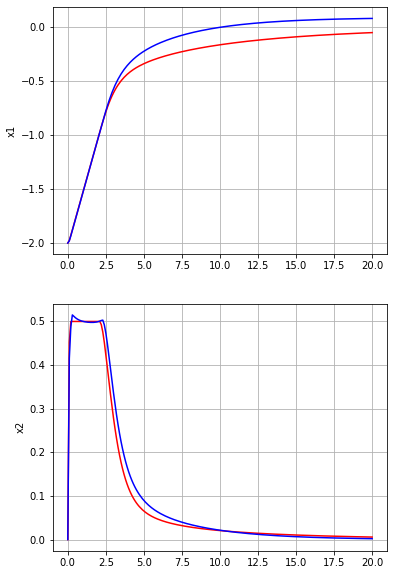

In [55]:
x_plot_real = np.array(x_real_list)
x_plot_pred = np.array(x_pred_list)
tgrid = [delta_t * k for k in range(N_sim + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (2):
    plt.subplot( str(2) + str(1) + str(i + 1) )
    plt.grid()
    
#     if i == 1:
#         constr_plot_temp = [0.65] * (N_sim + 1)
#         plt.plot(tgrid, constr_plot_temp, color="k")
    
    x_opt_real = x_plot_real[:,i]
    x_opt_pred = x_plot_pred[:,i]
    plt.plot(tgrid, x_opt_real, 'r')
    plt.plot(tgrid, x_opt_pred, 'b')
    plt.ylabel('x' + str(i + 1))

#### Add noise

In [69]:
N_sim = 200
x1_start = -2
x2_start = 0
x1_ub = ca.inf
x2_ub = 0.5

In [70]:
C_real = np.array([[5e-2, 0], [0, 5e-2]])
sin_const = 2

In [71]:
obj = 0

N_pred = 8

zi_var = ca.SX.sym('z', N_lift, N_pred+1)
z0_para = ca.SX.sym('z0', N_lift, 1)
ui_var = ca.SX.sym('u', 1, N_pred)


# Q = 10 * np.eye(N_lift)
Q = np.diag([0]* (N_lift-2) + [20, 10] )
R = 1 * np.eye(1)
Qf = np.diag([0]* (N_lift-2) + [20, 10])
# Qf = 10 * np.eye(N_lift)

g = []

for i in range(N_pred):
    obj +=  zi_var[:,i].T @ Q @  zi_var[:,i] + ui_var[:,i].T @ R @ ui_var[:,i]
    if i == 0:
        g += [zi_var[:,i] - z0_para]
    else:
        g += [zi_var[:,i] - (A_lift_np @ zi_var[:,i-1] + B_lift_np @ ui_var[:,i-1])]

obj += zi_var[:, -1].T @ Qf @ zi_var[:, -1]
g += [zi_var[:, -1] - (A_lift_np @ zi_var[:,-2] + B_lift_np @ ui_var[:,-1])] # Terminal state        
# g += [terminal_state - integrator_rk4(ode, xi_var[:,-2], ui_var[:,-1], delta_t)] # Terminal state         
dec_list = [ca.reshape(zi_var,-1,1), ca.reshape(ui_var,-1,1)]
para_list = [z0_para]
nlp_prob = {
    'f': obj,
    'x': ca.vertcat(*dec_list),
    'g': ca.vertcat(*g),
    'p': ca.vertcat(*para_list)
}
    

solver_opt = {}
solver_opt['print_time'] = False
solver_opt['ipopt'] = {
    'max_iter': 1500,
    'print_level': 3,
    'acceptable_constr_viol_tol': 0.1,
    'acceptable_tol': 5e-1,
}
#    'acceptable_obj_change_tol': 5e-4}


solver_real = ca.nlpsol("solver", "ipopt", nlp_prob, solver_opt)  

In [72]:
lbg =  [0] * N_lift * (N_pred + 1)
ubg =  [0] * N_lift * (N_pred + 1)
lbx = [-ca.inf] * N_lift * (N_pred+1) + [-ca.inf] * (N_pred)
ubx = ([ca.inf] * (N_lift-2) + [x1_ub, x2_ub])  * (N_pred+1) + [ca.inf] * (N_pred)
nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg
nl['lbx'] = lbx
nl['ubx'] = ubx

In [73]:
x0 = np.array([[x1_start],[x2_start]])
z0 = lift_func(x0, Xc)
u0 = np.array([[0]])

x_pred_list = []
z_pred_list = []
xk = x0
zk = z0
uk = u0


x_pred_list.append(xk.flatten().tolist())
z_pred_list.append(zk.flatten().tolist())

u_ind = ca.reshape(zi_var,-1,1).shape[0]

In [74]:
# Simulation for 20 seconds
for i in range(N_sim):
#     print(xk.shape)
    p = np.vstack([zk])
#     print(p.shape)
    nl['p'] = p
#     print(zk)
    sol = solver_real(**nl)
    uk = sol['x'].full()[u_ind,0]
    zk = sol['x'].full()[:u_ind]
    z_pred_list += [zk]
    print("zk",zk[50::52],zk[51::52])
    wk = sin_const * np.sin(np.random.randn(2, 1))
    x_next = integrator_rk4(ode,xk,uk,delta_t) + C_real @ wk
    print(uk,xk)
#     print("zk",zk)
#     print(zk[50::52],zk[51::52])
    x_pred_list.append(x_next.full().flatten().tolist())
    
    xk = x_next.full()
    zk = lift_func(xk, Xc)
#     print(xk.shape)

Total number of variables............................:      476
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        9
Total number of equality constraints.................:      468
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:  1.3958764310307718e+003   1.3958764310307718e+003
Dual infeasibility......:  6.4187588577624410e-010   6.4187588577624410e-010
Constraint violation....:  2.8534201621967190e-012   2.9103386367523854e-012
Complementarity.........:  2.5085527889724587e-009   2.5085527889724587e-009
Overall NLP e


Number of Iterations....: 14

                                   (scaled)                 (unscaled)
Objective...............:  7.1211252726450107e+002   7.1211252726450107e+002
Dual infeasibility......:  2.8286024189583259e-008   2.8286024189583259e-008
Constraint violation....:  2.9291167473706747e-002   2.9291167473706747e-002
Complementarity.........:  3.0002455148644604e-003   3.0002455148644604e-003
Overall NLP error.......:  2.9291167473706747e-002   2.9291167473706747e-002


Number of objective function evaluations             = 37
Number of objective gradient evaluations             = 16
Number of equality constraint evaluations            = 37
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 16
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 15
Total CPU secs in IPOPT (w/o function evaluations)   =      0.176
Total CPU secs in NLP function evaluation


Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:  3.4768469192928228e+002   3.4768469192928228e+002
Dual infeasibility......:  1.0714984455262311e-010   1.0714984455262311e-010
Constraint violation....:  1.4298886819540371e-012   1.5070167336261875e-012
Complementarity.........:  4.6726131799410007e-009   4.6726131799410007e-009
Overall NLP error.......:  4.6726131799410007e-009   4.6726131799410007e-009


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 11
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 11
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 10
Total CPU secs in IPOPT (w/o function evaluations)   =      0.139
Total CPU secs in NLP function evaluation

Total number of variables............................:      476
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        9
Total number of equality constraints.................:      468
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:  1.1525224267693190e+002   1.1525224267693190e+002
Dual infeasibility......:  2.6308732969937410e-011   2.6308732969937410e-011
Constraint violation....:  1.0143747069614021e-012   1.2860823517257813e-012
Complementarity.........:  5.6220722228343759e-009   5.6220722228343759e-009
Overall NLP er


Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  5.7180826918582028e+001   5.7180826918582028e+001
Dual infeasibility......:  1.5127454844332533e-011   1.5127454844332533e-011
Constraint violation....:  6.3269890137414672e-013   7.7804429565730970e-013
Complementarity.........:  2.5066262625927446e-009   2.5066262625927446e-009
Overall NLP error.......:  2.5066262625927446e-009   2.5066262625927446e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 6
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 5
Total CPU secs in IPOPT (w/o function evaluations)   =      0.102
Total CPU secs in NLP function evaluations     


Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  2.6573939094547747e+001   2.6573939094547747e+001
Dual infeasibility......:  3.4816594052244909e-011   3.4816594052244909e-011
Constraint violation....:  3.8760717339676684e-013   4.6185277824406512e-013
Complementarity.........:  2.5059782104051909e-009   2.5059782104051909e-009
Overall NLP error.......:  2.5059782104051909e-009   2.5059782104051909e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o function evaluations)   =      0.113
Total CPU secs in NLP function evaluations     


Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  1.2511807692019481e+001   1.2511807692019481e+001
Dual infeasibility......:  1.5589307622576598e-011   1.5589307622576598e-011
Constraint violation....:  2.9088476142209601e-013   5.6132876125047915e-013
Complementarity.........:  2.5059782646013565e-009   2.5059782646013565e-009
Overall NLP error.......:  2.5059782646013565e-009   2.5059782646013565e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o function evaluations)   =      0.114
Total CPU secs in NLP function evaluations     


Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  2.5862076882254620e+001   2.5862076882254620e+001
Dual infeasibility......:  4.2895464957837248e-011   4.2895464957837248e-011
Constraint violation....:  3.9253663000753260e-013   5.4711790653527714e-013
Complementarity.........:  2.5059717819442688e-009   2.5059717819442688e-009
Overall NLP error.......:  2.5059717819442688e-009   2.5059717819442688e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o function evaluations)   =      0.115
Total CPU secs in NLP function evaluations     


Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  1.3652988885776239e+001   1.3652988885776239e+001
Dual infeasibility......:  2.6110669182344282e-011   2.6110669182344282e-011
Constraint violation....:  3.4556408916058212e-013   4.1922021409845911e-013
Complementarity.........:  2.5059885808886437e-009   2.5059885808886437e-009
Overall NLP error.......:  2.5059885808886437e-009   2.5059885808886437e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o function evaluations)   =      0.114
Total CPU secs in NLP function evaluations     


Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  3.5618237074664350e+001   3.5618237074664350e+001
Dual infeasibility......:  2.5806912162806839e-011   2.5806912162806839e-011
Constraint violation....:  4.9408093300508145e-013   6.2527760746888826e-013
Complementarity.........:  2.5059874656977129e-009   2.5059874656977129e-009
Overall NLP error.......:  2.5059874656977129e-009   2.5059874656977129e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 6
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 5
Total CPU secs in IPOPT (w/o function evaluations)   =      0.105
Total CPU secs in NLP function evaluations     


Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  2.7455555739587751e+001   2.7455555739587751e+001
Dual infeasibility......:  2.2254198484006338e-011   2.2254198484006338e-011
Constraint violation....:  4.0862383152151580e-013   4.1922021409845911e-013
Complementarity.........:  2.5059898129709694e-009   2.5059898129709694e-009
Overall NLP error.......:  2.5059898129709694e-009   2.5059898129709694e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o function evaluations)   =      0.115
Total CPU secs in NLP function evaluations     


Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  2.7508666969683897e+001   2.7508666969683897e+001
Dual infeasibility......:  2.6458835122866731e-011   2.6458835122866731e-011
Constraint violation....:  5.7306901706900404e-013   8.2422957348171622e-013
Complementarity.........:  2.5060251049885103e-009   2.5060251049885103e-009
Overall NLP error.......:  2.5060251049885103e-009   2.5060251049885103e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 6
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 5
Total CPU secs in IPOPT (w/o function evaluations)   =      0.106
Total CPU secs in NLP function evaluations     


Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  1.6178124893926114e+001   1.6178124893926114e+001
Dual infeasibility......:  3.4908964607893722e-011   3.4908964607893722e-011
Constraint violation....:  3.8127159719800501e-013   7.7449158197850920e-013
Complementarity.........:  2.5059548185986109e-009   2.5059548185986109e-009
Overall NLP error.......:  2.5059548185986109e-009   2.5059548185986109e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o function evaluations)   =      0.112
Total CPU secs in NLP function evaluations     


Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  1.3660553338783647e+001   1.3660553338783647e+001
Dual infeasibility......:  4.9290349579678150e-011   4.9290349579678150e-011
Constraint violation....:  4.1372088851435369e-013   5.3290705182007514e-013
Complementarity.........:  2.5059687160242857e-009   2.5059687160242857e-009
Overall NLP error.......:  2.5059687160242857e-009   2.5059687160242857e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o function evaluations)   =      0.112
Total CPU secs in NLP function evaluations     


Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  1.5797574504669532e+001   1.5797574504669532e+001
Dual infeasibility......:  2.4730439918130287e-011   2.4730439918130287e-011
Constraint violation....:  3.5198618616624232e-013   3.5571545708990016e-013
Complementarity.........:  2.5059734712566873e-009   2.5059734712566873e-009
Overall NLP error.......:  2.5059734712566873e-009   2.5059734712566873e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o function evaluations)   =      0.113
Total CPU secs in NLP function evaluations     


Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  2.3341116966760406e+001   2.3341116966760406e+001
Dual infeasibility......:  1.8575363469608419e-011   1.8575363469608419e-011
Constraint violation....:  3.3230093333771076e-013   6.7501559897209518e-013
Complementarity.........:  2.5059785315407897e-009   2.5059785315407897e-009
Overall NLP error.......:  2.5059785315407897e-009   2.5059785315407897e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o function evaluations)   =      0.109
Total CPU secs in NLP function evaluations     


Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  3.0180728528546261e+001   3.0180728528546261e+001
Dual infeasibility......:  2.6544100251157943e-011   2.6544100251157943e-011
Constraint violation....:  3.4010790555256871e-013   4.9737991503207013e-013
Complementarity.........:  2.5059754313146073e-009   2.5059754313146073e-009
Overall NLP error.......:  2.5059754313146073e-009   2.5059754313146073e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o function evaluations)   =      0.115
Total CPU secs in NLP function evaluations     


Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  2.2992651248811693e+001   2.2992651248811693e+001
Dual infeasibility......:  2.9181990157667315e-011   2.9181990157667315e-011
Constraint violation....:  3.1677181848035398e-013   3.9079850466805505e-013
Complementarity.........:  2.5059526278027361e-009   2.5059526278027361e-009
Overall NLP error.......:  2.5059526278027361e-009   2.5059526278027361e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o function evaluations)   =      0.111
Total CPU secs in NLP function evaluations     


Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  2.6250129928330690e+001   2.6250129928330690e+001
Dual infeasibility......:  4.3645087544064154e-011   4.3645087544064154e-011
Constraint violation....:  4.7803747152489783e-013   5.8975047068088315e-013
Complementarity.........:  2.5059381068593964e-009   2.5059381068593964e-009
Overall NLP error.......:  2.5059381068593964e-009   2.5059381068593964e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o function evaluations)   =      0.112
Total CPU secs in NLP function evaluations     


                                   (scaled)                 (unscaled)
Objective...............:  2.6489792850964374e+001   2.6489792850964374e+001
Dual infeasibility......:  1.9902302028640406e-011   1.9902302028640406e-011
Constraint violation....:  3.8439120929097738e-013   4.3343106881366116e-013
Complementarity.........:  2.5059521594219423e-009   2.5059521594219423e-009
Overall NLP error.......:  2.5059521594219423e-009   2.5059521594219423e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o function evaluations)   =      0.113
Total CPU secs in NLP function evaluations           =      0.003

EXIT: Opt


Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  4.0222482017218290e+001   4.0222482017218290e+001
Dual infeasibility......:  4.1630698888184270e-011   4.1630698888184270e-011
Constraint violation....:  5.1853018027132327e-013   9.3791641120333225e-013
Complementarity.........:  2.5059389004988604e-009   2.5059389004988604e-009
Overall NLP error.......:  2.5059389004988604e-009   2.5059389004988604e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o function evaluations)   =      0.115
Total CPU secs in NLP function evaluations     


Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  3.6133020181790158e+001   3.6133020181790158e+001
Dual infeasibility......:  4.4035886048732209e-011   4.4035886048732209e-011
Constraint violation....:  5.7704287065870611e-013   7.2475359047530219e-013
Complementarity.........:  2.5059339193397295e-009   2.5059339193397295e-009
Overall NLP error.......:  2.5059339193397295e-009   2.5059339193397295e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o function evaluations)   =      0.114
Total CPU secs in NLP function evaluations     


Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  3.6406262086235373e+001   3.6406262086235373e+001
Dual infeasibility......:  2.9952929025967023e-011   2.9952929025967023e-011
Constraint violation....:  5.9227726118669014e-013   8.5265128291212022e-013
Complementarity.........:  2.5059374030397929e-009   2.5059374030397929e-009
Overall NLP error.......:  2.5059374030397929e-009   2.5059374030397929e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o function evaluations)   =      0.116
Total CPU secs in NLP function evaluations     


Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  2.8707672674843991e+001   2.8707672674843991e+001
Dual infeasibility......:  2.4698465495021082e-011   2.4698465495021082e-011
Constraint violation....:  4.5278109891471010e-013   4.9737991503207013e-013
Complementarity.........:  2.5059475187458140e-009   2.5059475187458140e-009
Overall NLP error.......:  2.5059475187458140e-009   2.5059475187458140e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o function evaluations)   =      0.117
Total CPU secs in NLP function evaluations     


Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  2.0912473650019145e+001   2.0912473650019145e+001
Dual infeasibility......:  2.4996893444040325e-011   2.4996893444040325e-011
Constraint violation....:  4.5306539383375792e-013   6.3771210534468992e-013
Complementarity.........:  2.5059443210076027e-009   2.5059443210076027e-009
Overall NLP error.......:  2.5059443210076027e-009   2.5059443210076027e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o function evaluations)   =      0.116
Total CPU secs in NLP function evaluations     

                     variables with only upper bounds:        9
Total number of equality constraints.................:      468
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  1.9363454781897101e+001   1.9363454781897101e+001
Dual infeasibility......:  3.8888003928150283e-011   3.8888003928150283e-011
Constraint violation....:  4.3535227452793484e-013   5.3290705182007514e-013
Complementarity.........:  2.5059453931072795e-009   2.5059453931072795e-009
Overall NLP error.......:  2.5059453931072795e-009   2.5059453931072795e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equ


Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  1.9911867091227538e+001   1.9911867091227538e+001
Dual infeasibility......:  4.1179504250976606e-011   4.1179504250976606e-011
Constraint violation....:  4.6403045274477223e-013   7.5317529990570620e-013
Complementarity.........:  2.5059438023888973e-009   2.5059438023888973e-009
Overall NLP error.......:  2.5059438023888973e-009   2.5059438023888973e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o function evaluations)   =      0.116
Total CPU secs in NLP function evaluations     


Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  1.5175283888068241e+001   1.5175283888068241e+001
Dual infeasibility......:  4.3193892906856490e-011   4.3193892906856490e-011
Constraint violation....:  6.0840221749458578e-013   6.0840221749458578e-013
Complementarity.........:  2.5059597195144966e-009   2.5059597195144966e-009
Overall NLP error.......:  2.5059597195144966e-009   2.5059597195144966e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o function evaluations)   =      0.117
Total CPU secs in NLP function evaluations     


Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  2.1673362669677122e+001   2.1673362669677122e+001
Dual infeasibility......:  3.7715608414146118e-011   3.7715608414146118e-011
Constraint violation....:  7.0332551047440121e-013   9.0594198809412764e-013
Complementarity.........:  2.5059617757930673e-009   2.5059617757930673e-009
Overall NLP error.......:  2.5059617757930673e-009   2.5059617757930673e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o function evaluations)   =      0.114
Total CPU secs in NLP function evaluations     


Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  2.0926679016624078e+001   2.0926679016624078e+001
Dual infeasibility......:  3.3626434969846741e-011   3.3626434969846741e-011
Constraint violation....:  4.7744603623152892e-013   5.5422333389287814e-013
Complementarity.........:  2.5059624821524569e-009   2.5059624821524569e-009
Overall NLP error.......:  2.5059624821524569e-009   2.5059624821524569e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o function evaluations)   =      0.114
Total CPU secs in NLP function evaluations     


Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  2.0140794042483698e+001   2.0140794042483698e+001
Dual infeasibility......:  3.4059866038660402e-011   3.4059866038660402e-011
Constraint violation....:  4.1725203399075853e-013   4.7961634663806763e-013
Complementarity.........:  2.5059627595238051e-009   2.5059627595238051e-009
Overall NLP error.......:  2.5059627595238051e-009   2.5059627595238051e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o function evaluations)   =      0.115
Total CPU secs in NLP function evaluations     


Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  2.5970135358386152e+001   2.5970135358386152e+001
Dual infeasibility......:  3.4084735034412006e-011   3.4084735034412006e-011
Constraint violation....:  5.6606140636279385e-013   6.8922645368729718e-013
Complementarity.........:  2.5059908345603858e-009   2.5059908345603858e-009
Overall NLP error.......:  2.5059908345603858e-009   2.5059908345603858e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o function evaluations)   =      0.116
Total CPU secs in NLP function evaluations     


Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  3.1647330703264135e+001   3.1647330703264135e+001
Dual infeasibility......:  2.9348967700570938e-011   2.9348967700570938e-011
Constraint violation....:  4.6363875250306360e-013   5.7198690228688065e-013
Complementarity.........:  2.5059657896679282e-009   2.5059657896679282e-009
Overall NLP error.......:  2.5059657896679282e-009   2.5059657896679282e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o function evaluations)   =      0.124
Total CPU secs in NLP function evaluations     


Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  3.0103205550905546e+001   3.0103205550905546e+001
Dual infeasibility......:  1.9097612380392093e-011   1.9097612380392093e-011
Constraint violation....:  7.3385741927722847e-013   7.3385741927722847e-013
Complementarity.........:  2.5061663976487159e-009   2.5061663976487159e-009
Overall NLP error.......:  2.5061663976487159e-009   2.5061663976487159e-009


Number of objective function evaluations             = 6
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 6
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 6
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 5
Total CPU secs in IPOPT (w/o function evaluations)   =      0.117
Total CPU secs in NLP function evaluations     


Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  1.8549075765214937e+001   1.8549075765214937e+001
Dual infeasibility......:  2.0737189743158524e-011   2.0737189743158524e-011
Constraint violation....:  5.5633604532101144e-013   6.4304117586289067e-013
Complementarity.........:  2.5060031362566704e-009   2.5060031362566704e-009
Overall NLP error.......:  2.5060031362566704e-009   2.5060031362566704e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 6
Total CPU secs in IPOPT (w/o function evaluations)   =      0.121
Total CPU secs in NLP function evaluations     

In [75]:
obj = 0

N_pred = 5

xi_var = ca.SX.sym('x', 2, N_pred+1)
x0_para = ca.SX.sym('x0', 2, 1)
ui_var = ca.SX.sym('u', 1, N_pred)


Q = 10 * np.eye(2)
R = 1 * np.eye(1)
Qf = 10 * np.eye(2)

g = []


for i in range(N_pred):
    obj +=  xi_var[:,i].T @ Q @  xi_var[:,i] + ui_var[:,i].T @ R @ ui_var[:,i]
    if i == 0:
        g += [xi_var[:,i] - x0_para]
    else:
        g += [xi_var[:,i] - integrator_rk4(ode, xi_var[:,i-1], ui_var[:,i-1], delta_t)]

obj += xi_var[:, -1].T @ Qf @ xi_var[:, -1]
g += [xi_var[:, -1] - integrator_rk4(ode, xi_var[:,-2], ui_var[:,-1], delta_t)] # Terminal state        
# g += [terminal_state - integrator_rk4(ode, xi_var[:,-2], ui_var[:,-1], delta_t)] # Terminal state         
dec_list = [ca.reshape(xi_var,-1,1), ca.reshape(ui_var,-1,1)]
para_list = [x0_para]
nlp_prob = {
    'f': obj,
    'x': ca.vertcat(*dec_list),
    'g': ca.vertcat(*g),
    'p': ca.vertcat(*para_list)
}
    

solver_opt = {}
solver_opt['print_time'] = False
solver_opt['ipopt'] = {
    'max_iter': 500,
    'print_level': 1,
    'acceptable_tol': 1e-6,
    'acceptable_obj_change_tol': 1e-6}


solver_real = ca.nlpsol("solver", "ipopt", nlp_prob, solver_opt)  



lbg =  [0] * 2 * (N_pred + 1)
ubg =  [0] * 2 * (N_pred + 1)
lbx = [-ca.inf] * 2 * (N_pred+1) + [-ca.inf] * (N_pred)
ubx = [x1_ub, x2_ub] * (N_pred+1) + [ca.inf] * (N_pred)
nl = {}
nl['lbg'] = lbg
nl['ubg'] = ubg
nl['lbx'] = lbx
nl['ubx'] = ubx

In [76]:
x0 = np.array([[x1_start],[x2_start]])
u0 = np.array([[0]])

x_real_list = []
x_real_pred_list = []
xk = x0
uk = u0


x_real_list.append(xk.flatten().tolist())

u_ind = ca.reshape(xi_var,-1,1).shape[0]

In [77]:
# Simulation for 20 seconds
for i in range(N_sim):
    p = np.vstack([xk])
    nl['p'] = p
    
    sol = solver_real(**nl)
    uk = sol['x'].full()[u_ind,0]
#     print(uk)
    x_real_pred_list += [sol['x'].full()[:u_ind]]
    wk = sin_const * np.sin(np.random.randn(2, 1))
    x_next = integrator_rk4(ode,xk,uk,delta_t) + C_real @ wk
    print(uk,xk)
    x_real_list.append(x_next.full().flatten().tolist())

    x_lin = xk
    xk = x_next

-6.064159111006248 [[-2]
 [ 0]]
-10.755757432784987 [-1.97719, 0.353338]
-8.721800843063214 [-1.83395, 0.410364]
-9.301023853127855 [-1.78359, 0.496463]
-9.598398520682556 [-1.79114, 0.595841]
-9.169452177785878 [-1.77297, 0.674128]
-9.288770106008204 [-1.77948, 0.690884]
-7.758639816445363 [-1.6916, 0.685764]
-6.0856054382865725 [-1.57872, 0.552521]
-3.57304620902004 [-1.48002, 0.440383]
-5.611954413156418 [-1.53268, 0.558945]
-4.188017530909784 [-1.3783, 0.530319]
-2.41248566650138 [-1.26842, 0.515116]
-1.6216682422545572 [-1.23013, 0.479501]
-0.5874894755894838 [-1.1861, 0.406329]
-0.9113296618179383 [-1.04987, 0.538243]
-0.86169232060386 [-1.08246, 0.592675]
-1.0713575372009285 [-1.11263, 0.645612]
-0.8970210844978416 [-1.0877, 0.587477]
-0.564232457189496 [-0.972345, 0.659133]
-0.48625577175297297 [-0.98759, 0.563296]
-0.4850679131911021 [-0.881875, 0.517877]
-0.47990103209385104 [-0.897219, 0.507211]
-0.21379937393215068 [-0.876754, 0.376275]
-0.17204044990413153 [-0.887985, 0.33

C:\Users\ZHENGA~1\AppData\Local\Temp/ipykernel_3676/192835070.py:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(2) + str(1) + str(i + 1) )
C:\Users\ZHENGA~1\AppData\Local\Temp/ipykernel_3676/192835070.py:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot( str(2) + str(1) + str(i + 1) )


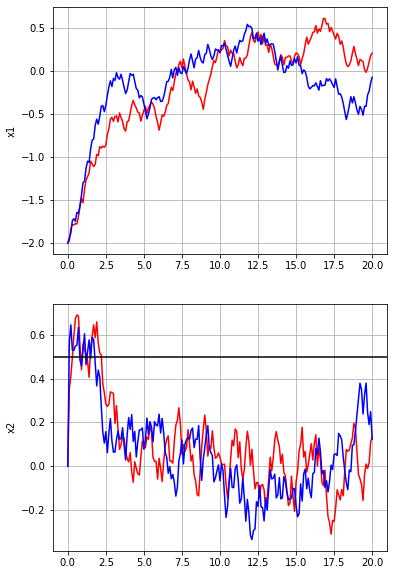

In [81]:
x_plot_real = np.array(x_real_list)
x_plot_pred = np.array(x_pred_list)
tgrid = [delta_t * k for k in range(N_sim + 1)]

plt.figure(1, figsize=(6, 10))
plt.clf()
for i in range (2):
    plt.subplot( str(2) + str(1) + str(i + 1) )
    plt.grid()
    
#     if i == 1:
#         constr_plot_temp = [0.65] * (N_sim + 1)
#         plt.plot(tgrid, constr_plot_temp, color="k")
    
    x_opt_real = x_plot_real[:,i]
    x_opt_pred = x_plot_pred[:,i]
    plt.plot(tgrid, x_opt_real, 'r')
    plt.plot(tgrid, x_opt_pred, 'b')
    plt.ylabel('x' + str(i + 1))
    
    if i == 1:
        plt.axhline(y=0.5, color='k', linestyle='-')